In [13]:
from astropy.table import Table
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [34]:
points = [i / 10 for i in range(1, 41)] + [i for i in range(5, 11)]
a = []
for i in points:
    for j in points:
        b = {}
        b["dim"] = 30
        b["rate"] = i
        b["sigma"] = j
        b["distance"] = "euclidean"
        b["type"] = "noiseless_mag"
        b["iter"] = 1
        a.append(b)

# with open("D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/noiseless_mag_band_cut.pkl",'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [15]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut" or mode == "both":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
        else:
            data = data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            data_err = data_err[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
    if mode == "band_cut" or mode == "both":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        
    return data, data_err, info_data

In [16]:
def grid_search(data, err, file):
    n = 0
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    if "som" not in record[-1]:
        for i in record:
            n += 1
            if "som" not in i:
                som = MiniSom(i["dim"], i["dim"], data.shape[1], sigma = i["sigma"], learning_rate = i["rate"], activation_distance = i["distance"])
                som.random_weights_init(data)
                som.train(data, err, num_iteration = i["iter"], use_epochs = True) 
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                i["som"] = som
                i["band_cut"] = len(data[0])
                i["mag_cut"] = len(data)
                i["preproc"] = "default"
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                print(f"File: {file}, progress: {round(n / len(record) * 100, 2)}%, param: {[i["dim"], i["sigma"], i["rate"]]}", end = "\r")
                try:
                    with open(file, 'wb') as handle:
                        pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
                except KeyboardInterrupt:
                    print('KeyboardInterrupt caught, data saved.')
    else:
        pass

In [17]:
def parameter_space(save, file):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    x_tick_f = list(set([i["rate"] for i in record]))
    x_tick_f.sort()
    y_tick_f = list(set([i["sigma"] for i in record]))
    y_tick_f.sort()
    x_tick_i = [i + 0.5 for i in range(0, len(x_tick_f))]
    y_tick_i = [i + 0.5 for i in range(0, len(y_tick_f))]
    
    quan_map30 = np.zeros((len(y_tick_f), len(x_tick_f)))
    topo_map30 = np.zeros((len(y_tick_f), len(x_tick_f)))
    quan_map50 = np.zeros((len(y_tick_f), len(x_tick_f)))
    topo_map50 = np.zeros((len(y_tick_f), len(x_tick_f)))
    quan_map70 = np.zeros((len(y_tick_f), len(x_tick_f)))
    topo_map70 = np.zeros((len(y_tick_f), len(x_tick_f)))
    quan_map90 = np.zeros((len(y_tick_f), len(x_tick_f)))
    topo_map90 = np.zeros((len(y_tick_f), len(x_tick_f)))

    x_index = dict(zip(x_tick_f, [i - 0.5 for i in x_tick_i]))
    y_index = dict(zip(y_tick_f, [i - 0.5 for i in y_tick_i]))

    for i in record:
        if i["dim"] == 30:
            topo_map30[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["topo_err"]
            quan_map30[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 50:
            topo_map50[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["topo_err"]
            quan_map50[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 70:
            topo_map70[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["topo_err"]
            quan_map70[int(y_index[i["sigma"]]), int(x_index[i["rate"]])] = i["quan_err"]

        elif i["dim"] == 90:
            topo_map90[int(index[i["sigma"]]), int(index[i["rate"]])] = i["topo_err"]
            quan_map90[int(index[i["sigma"]]), int(index[i["rate"]])] = i["quan_err"]

    if np.sum(quan_map30) == 0:
        quan_map30 = np.ones((len(y_tick_f), len(x_tick_f)))
    if np.sum(quan_map50) == 0:
        quan_map50 = np.ones((len(y_tick_f), len(x_tick_f)))
    if np.sum(quan_map70) == 0:
        quan_map70 = np.ones((len(y_tick_f), len(x_tick_f)))
    if np.sum(quan_map90) == 0:
        quan_map90 = np.ones((len(y_tick_f), len(x_tick_f)))
        
    topo_maps = [topo_map30, topo_map50, topo_map70, topo_map90]
    quan_maps = [quan_map30, quan_map50, quan_map70, quan_map90]

    x_tick_f = np.round(x_tick_f, 3)
    
    plt.close()
    plt.figure(figsize = (30, 20))

    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(topo_maps[i - 1].reshape(-1), bins = 20)
        plt.xlabel("Topological Error", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
    
    if save:
        plt.savefig(save + f"{record[0]['type']}_{record[0]['band_cut']}_topo_err_dist.jpg", bbox_inches = "tight")    
    plt.show()

    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(np.log10(quan_maps[i - 1]).reshape(-1), bins = 20)
        plt.xlabel("log(Quantization Error)", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
        plt.yscale("log")
        
    if save:
        plt.savefig(save + f"{record[0]['type']}_{record[0]['band_cut']}_quan_err_dist.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(topo_maps[i - 1], cmap = 'YlGn')
        plt.title(f"Topological Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=15)
        plt.ylabel("Sigma", fontsize=15)
        plt.xticks(x_tick_i, x_tick_f, fontsize=8)
        plt.yticks(y_tick_i, y_tick_f, fontsize=8)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save:
        plt.savefig(save + f"{record[0]['type']}_{record[0]['band_cut']}_topo_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(np.log10(quan_maps[i - 1]), cmap = 'YlGn')
        plt.title(f"Quantizationl Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=15)
        plt.ylabel("Sigma", fontsize=15)
        plt.xticks(x_tick_i, x_tick_f, fontsize=8)
        plt.yticks(y_tick_i, y_tick_f, fontsize=8)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save != False:
        plt.savefig(save + f"{record[0]['type']}_{record[0]['band_cut']}_quan_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()

In [6]:
def visual_map(file, dim, sigma, rate, data, err, info_data, save = False):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    for k in record:
        if k["dim"] == dim and round(k["rate"], 3) == rate and k["sigma"] == sigma:
            pass
        else:
            continue
        som = k["som"]
        print(f"Topological error: {som.topographic_error(data)}")
        print(f"Quantization error: {som.quantization_error(data)}")
        print(f"Topological error: {k["topo_err"]}")
        print(f"Quantization error: {k["quan_err"]}")        
        if "density" in k:
            density_map = k["density"]
            magnitude_map = k["magnitude"]
            z_map = k["z"]
            
            %matplotlib inline
            plt.close()
            plt.figure(figsize = (30, 20))
            plt.subplot(221)
            plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
            plt.colorbar()
            plt.title("Distance map (U-matrix)")
        
            plt.subplot(222)
            plt.pcolor(density_map.T, cmap='YlGn')
            plt.colorbar()
            plt.title("Density Map")
        
            plt.subplot(223)
            plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
            plt.colorbar()
            plt.title("HSC I Magnitude Map")
        
            plt.subplot(224)
            plt.pcolor(z_map.T, cmap="plasma")
            plt.colorbar()
            plt.title("True Redshift Map")
            if save != False:
                plt.savefig(save + f"{i['type']}_{len(data[0])}_{dim}_{sigma}_{rate}_{k['iter']}.jpg", bbox_inches = "tight")
            
            plt.show()
            continue
        else:
            pass
        
        density_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
        magnitude_map.fill(np.nan)
        z_map = np.zeros(dim ** 2).reshape(dim, dim)
        z_map.fill(np.nan)
        
        labels_map_1 = som.labels_map(data, err, [0] * len(data))
        labels_map_2 = som.labels_map(data, err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
        for i in labels_map_1.keys():
            density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]
        
        for i in labels_map_2.keys():
            properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

        %matplotlib inline
        plt.close()
        plt.figure(figsize = (30, 20))
        plt.subplot(221)
        plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
        plt.colorbar()
        plt.title("Distance map (U-matrix)")
        
        plt.subplot(222)
        plt.pcolor(density_map.T, cmap='YlGn')
        plt.colorbar()
        plt.title("Density Map")
    
        plt.subplot(223)
        plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
        plt.colorbar()
        plt.title("HSC I Magnitude Map")
    
        plt.subplot(224)
        plt.pcolor(z_map.T, cmap="plasma")
        plt.colorbar()
        plt.title("True Redshift Map")
        if save != False:
            plt.savefig(save + f"{k['type']}_{len(data[0])}_{dim}_{sigma}_{rate}_{k['iter']}.jpg", bbox_inches = "tight")
        
        plt.show()
    
        k["density"] = density_map
        k["magnitude"] = magnitude_map
        k["z"] = z_map

        try:
            with open(file, 'wb') as handle:
                pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')

In [7]:
info = df_L3_info[-pd.DataFrame(data_noiseless).isna()[0]]
data = pd.DataFrame(data_noiseless).dropna()
info = info[-data[data > 0].isna()[0]]
data = data[data > 0].dropna().to_numpy()
err = np.zeros_like(data)

data, err, info = remove_low_SNR(data = data, data_err = err, info_data = info, mode = "band_cut", mag_cut = None)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\194549841.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_noiseless).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\194549841.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = info[-data[data > 0].isna()[0]]


In [8]:
data = -2.5 * np.log10(data / 10 ** 6) + 8.9
proc_data = (data - np.mean(data, axis=0)) / np.std(data, ddof = 1, axis=0)

In [ ]:
grid_search(data = proc_data, err = err, file = "D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/noiseless_mag_band_cut.pkl")

In [ ]:
parameter_space(save = "D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/diagram/", file = "D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/noiseless_mag_band_cut.pkl")

Topological error: 0.22699861873799818
Quantization error: 0.6464360374065607
Topological error: 0.22699861873799818
Quantization error: 0.6464360374065607


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


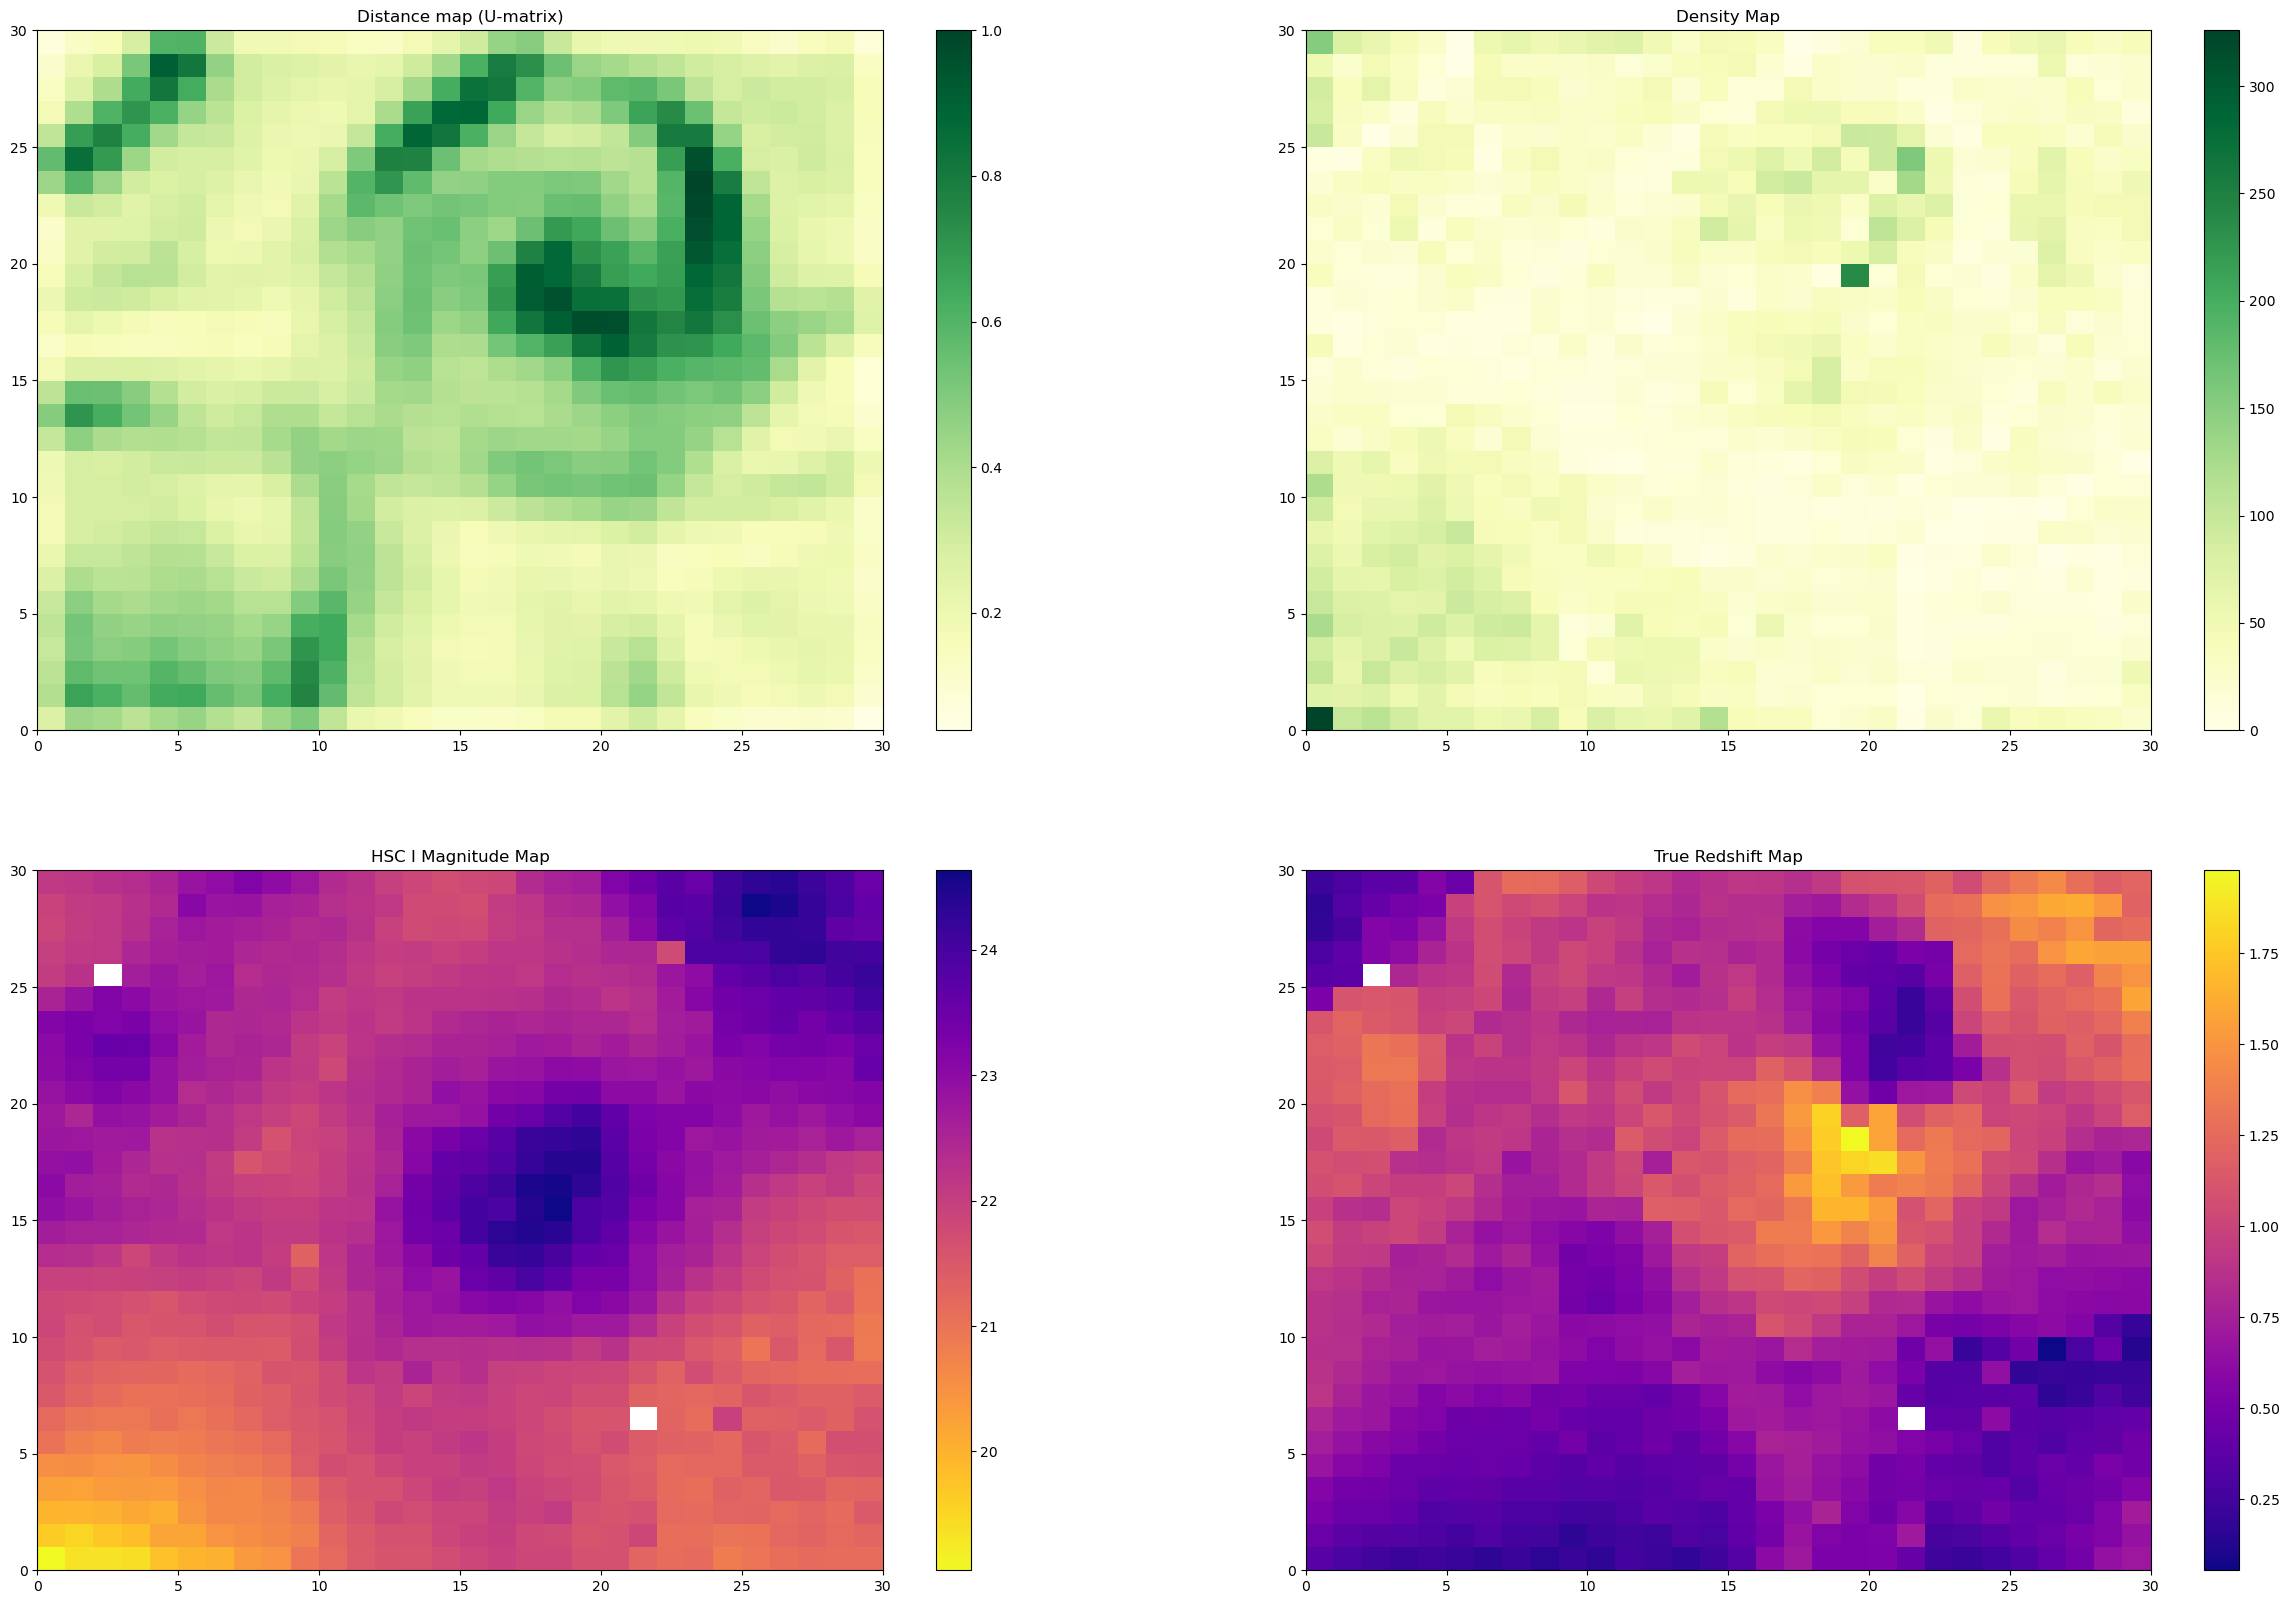

Topological error: 0.17100697368864334
Quantization error: 0.6247044838235402
Topological error: 0.17100697368864334
Quantization error: 0.6247044838235402


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


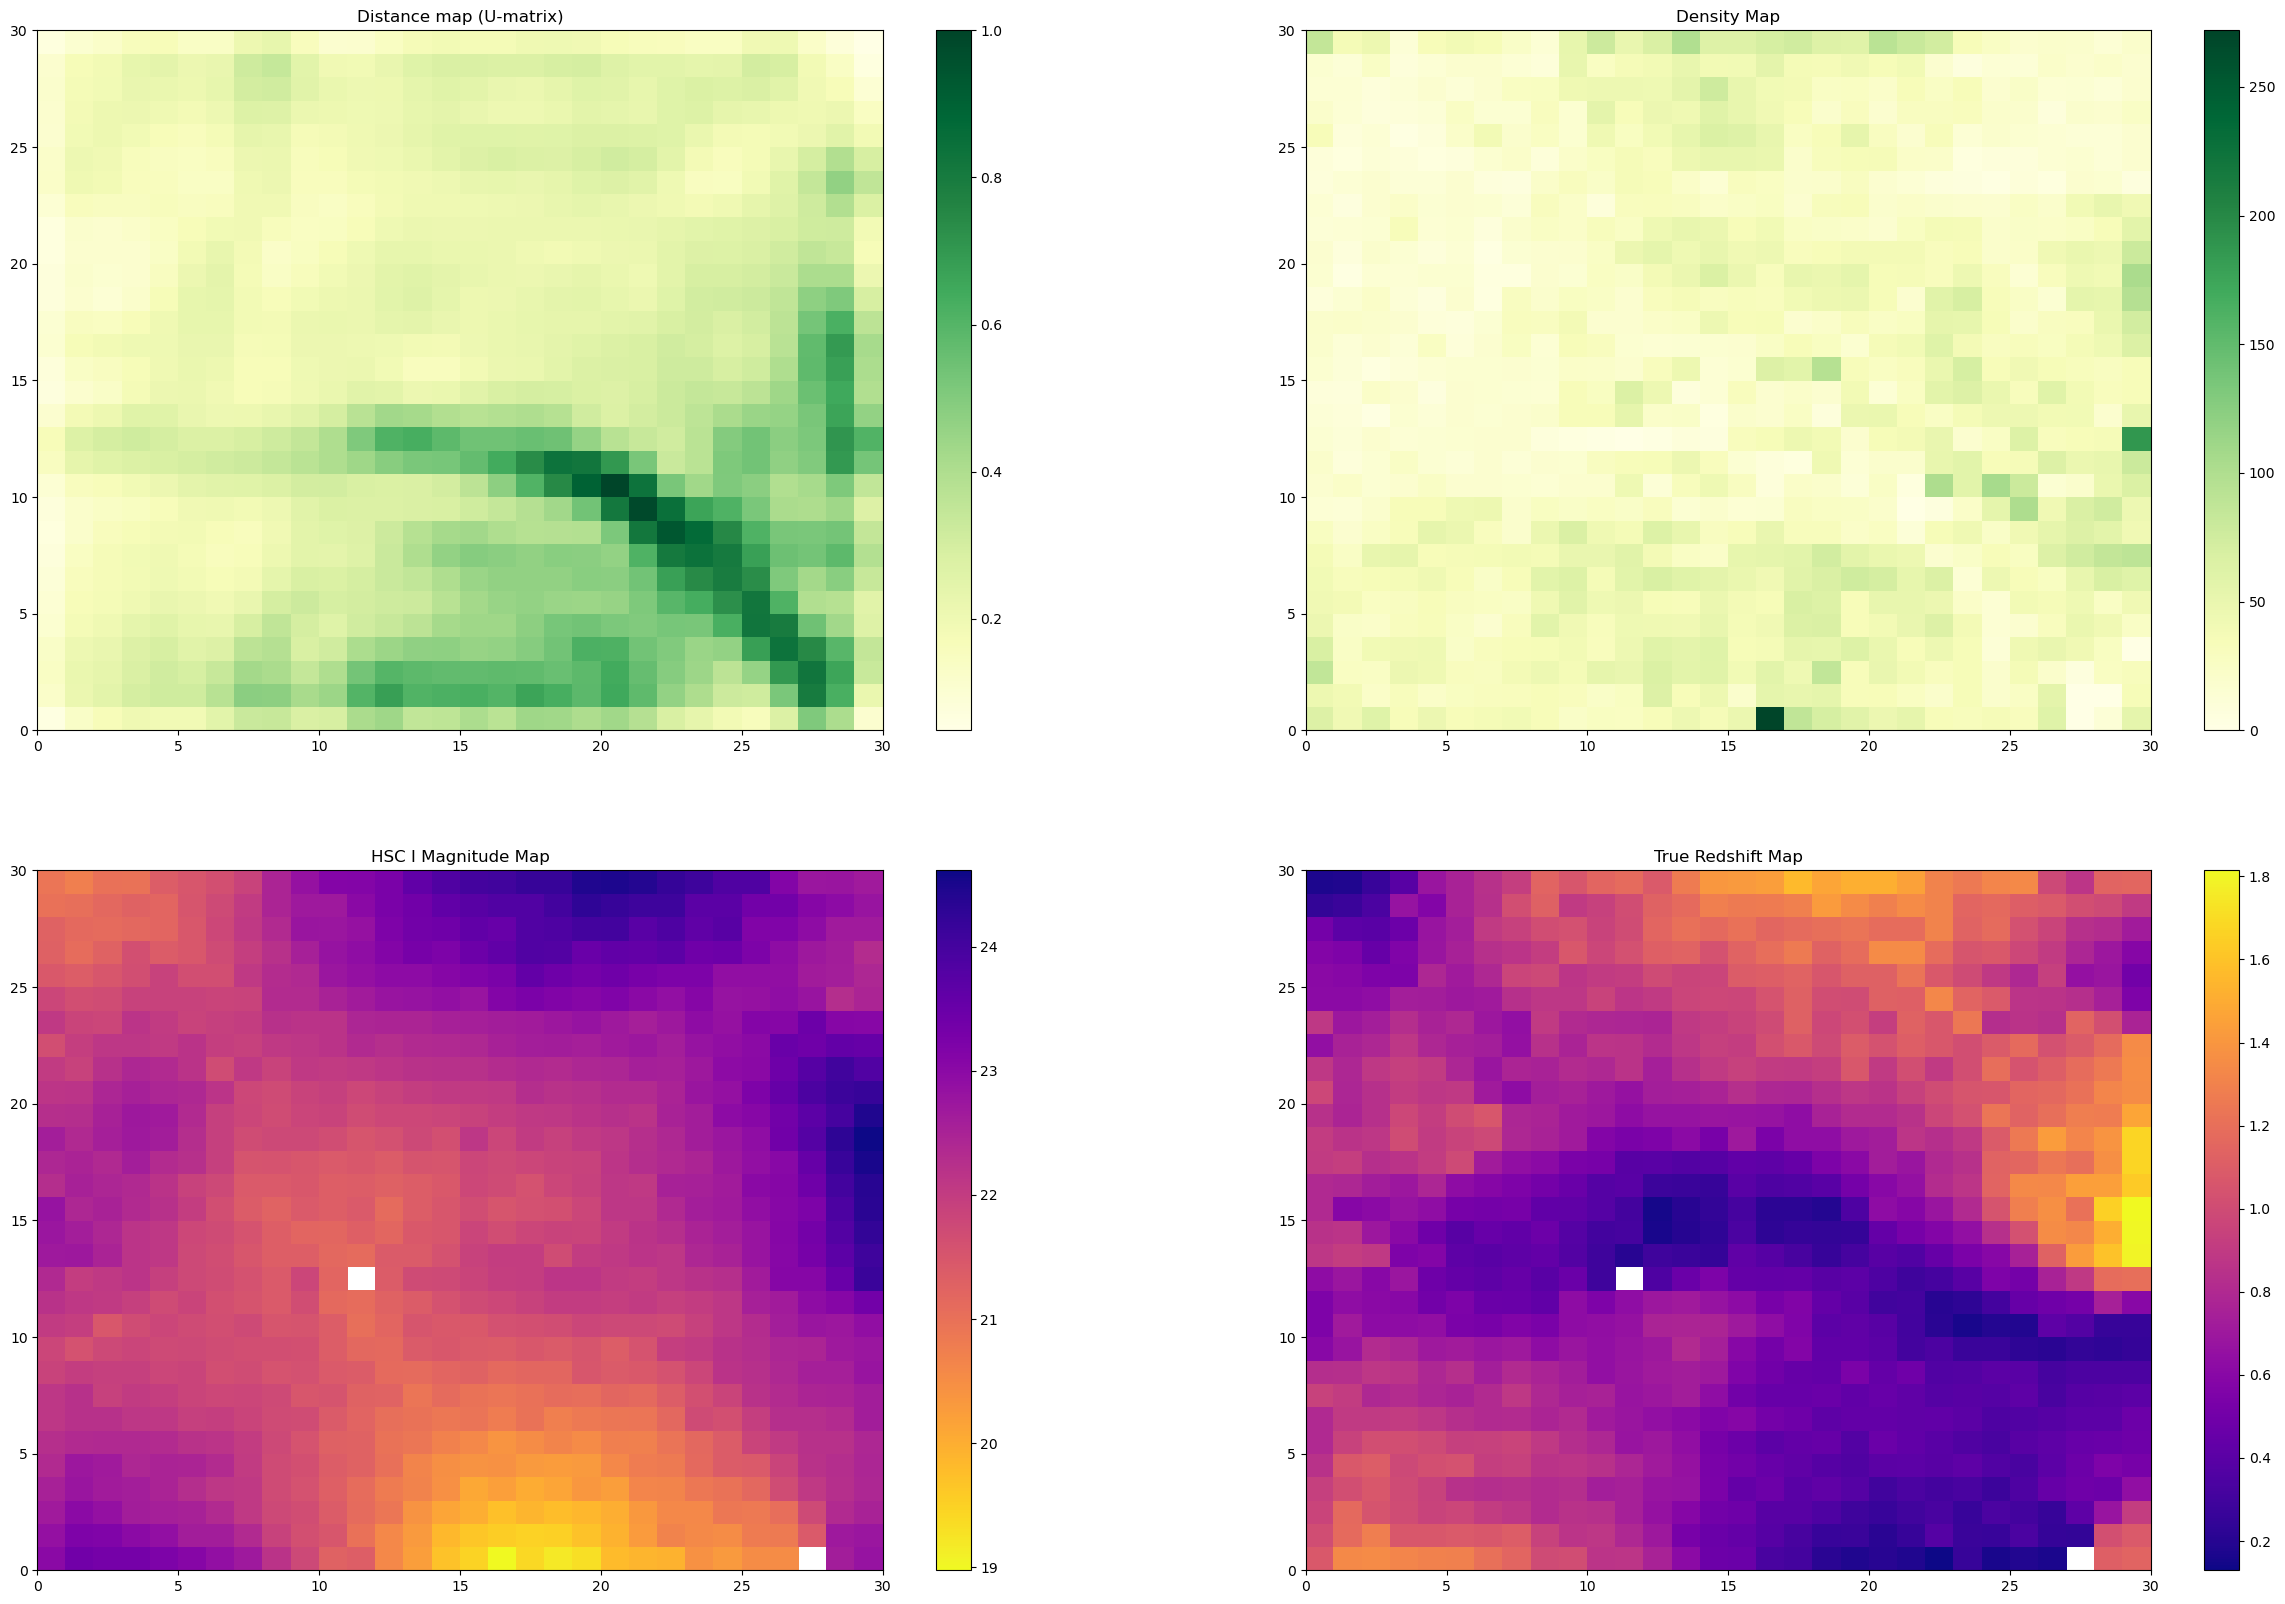

Topological error: 0.16201192601825962
Quantization error: 0.6084171468539747
Topological error: 0.16201192601825962
Quantization error: 0.6084171468539747


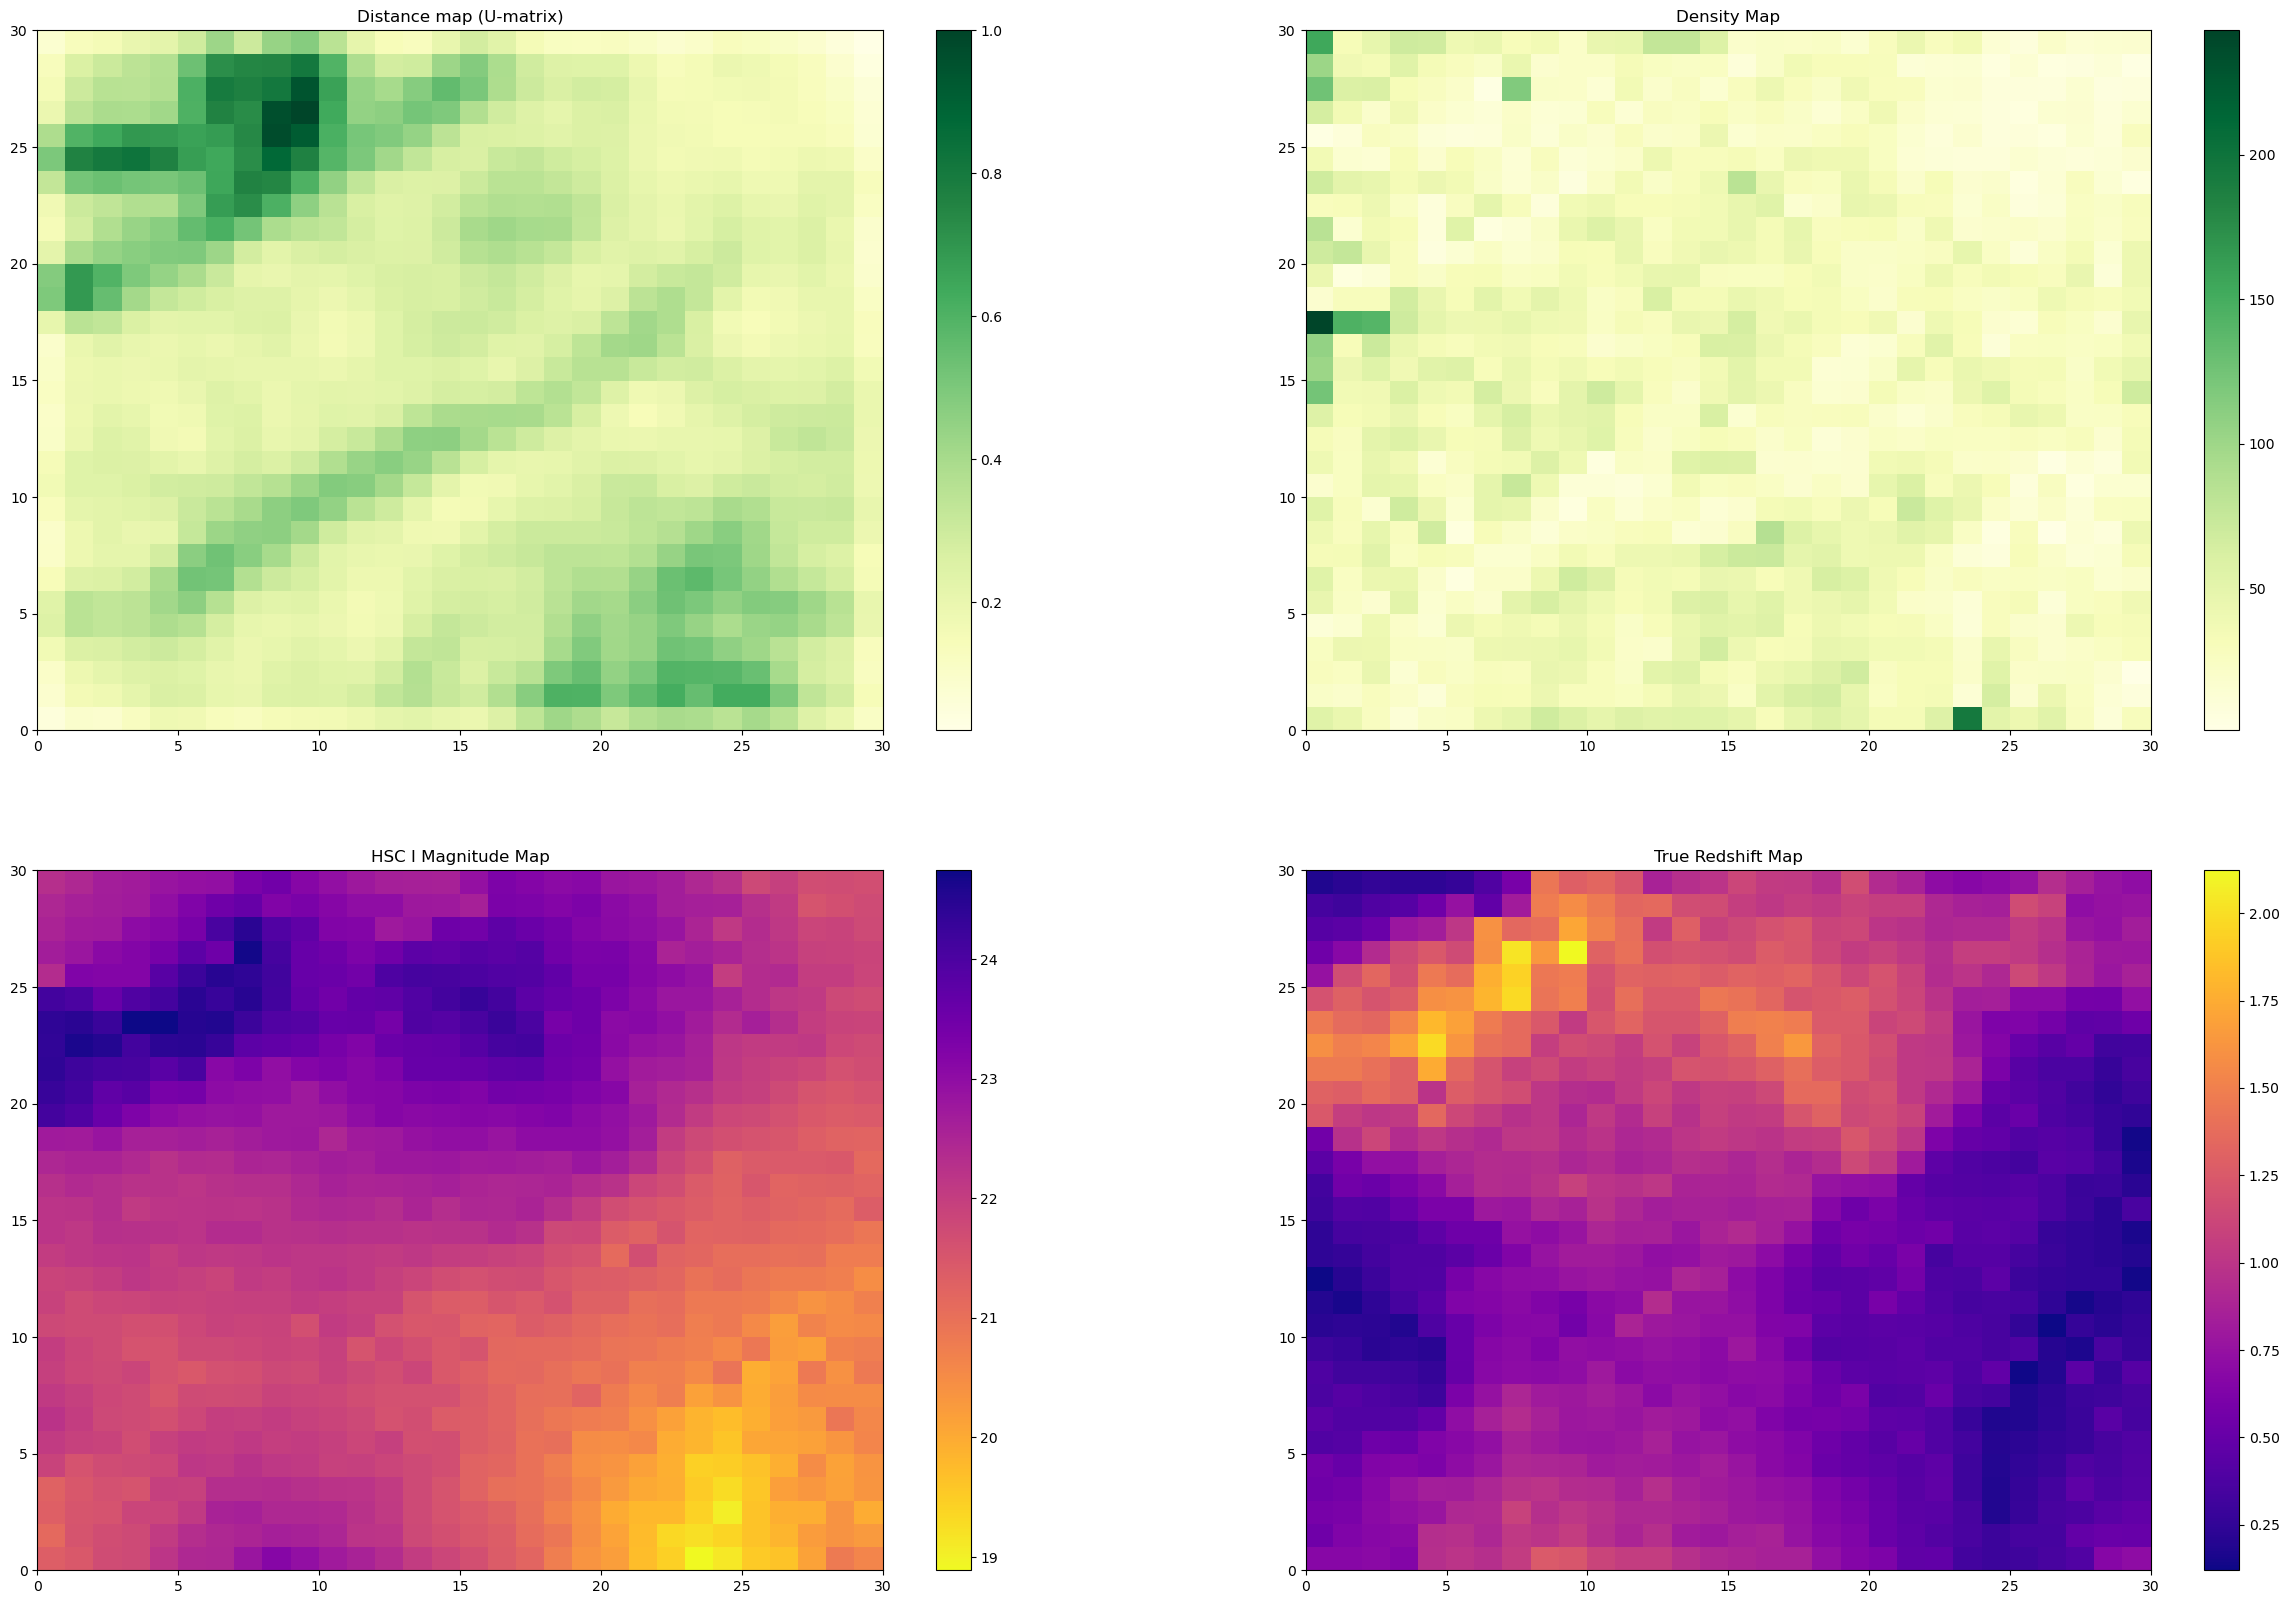

Topological error: 0.16534716841289626
Quantization error: 0.615705930822958
Topological error: 0.16534716841289626
Quantization error: 0.615705930822958


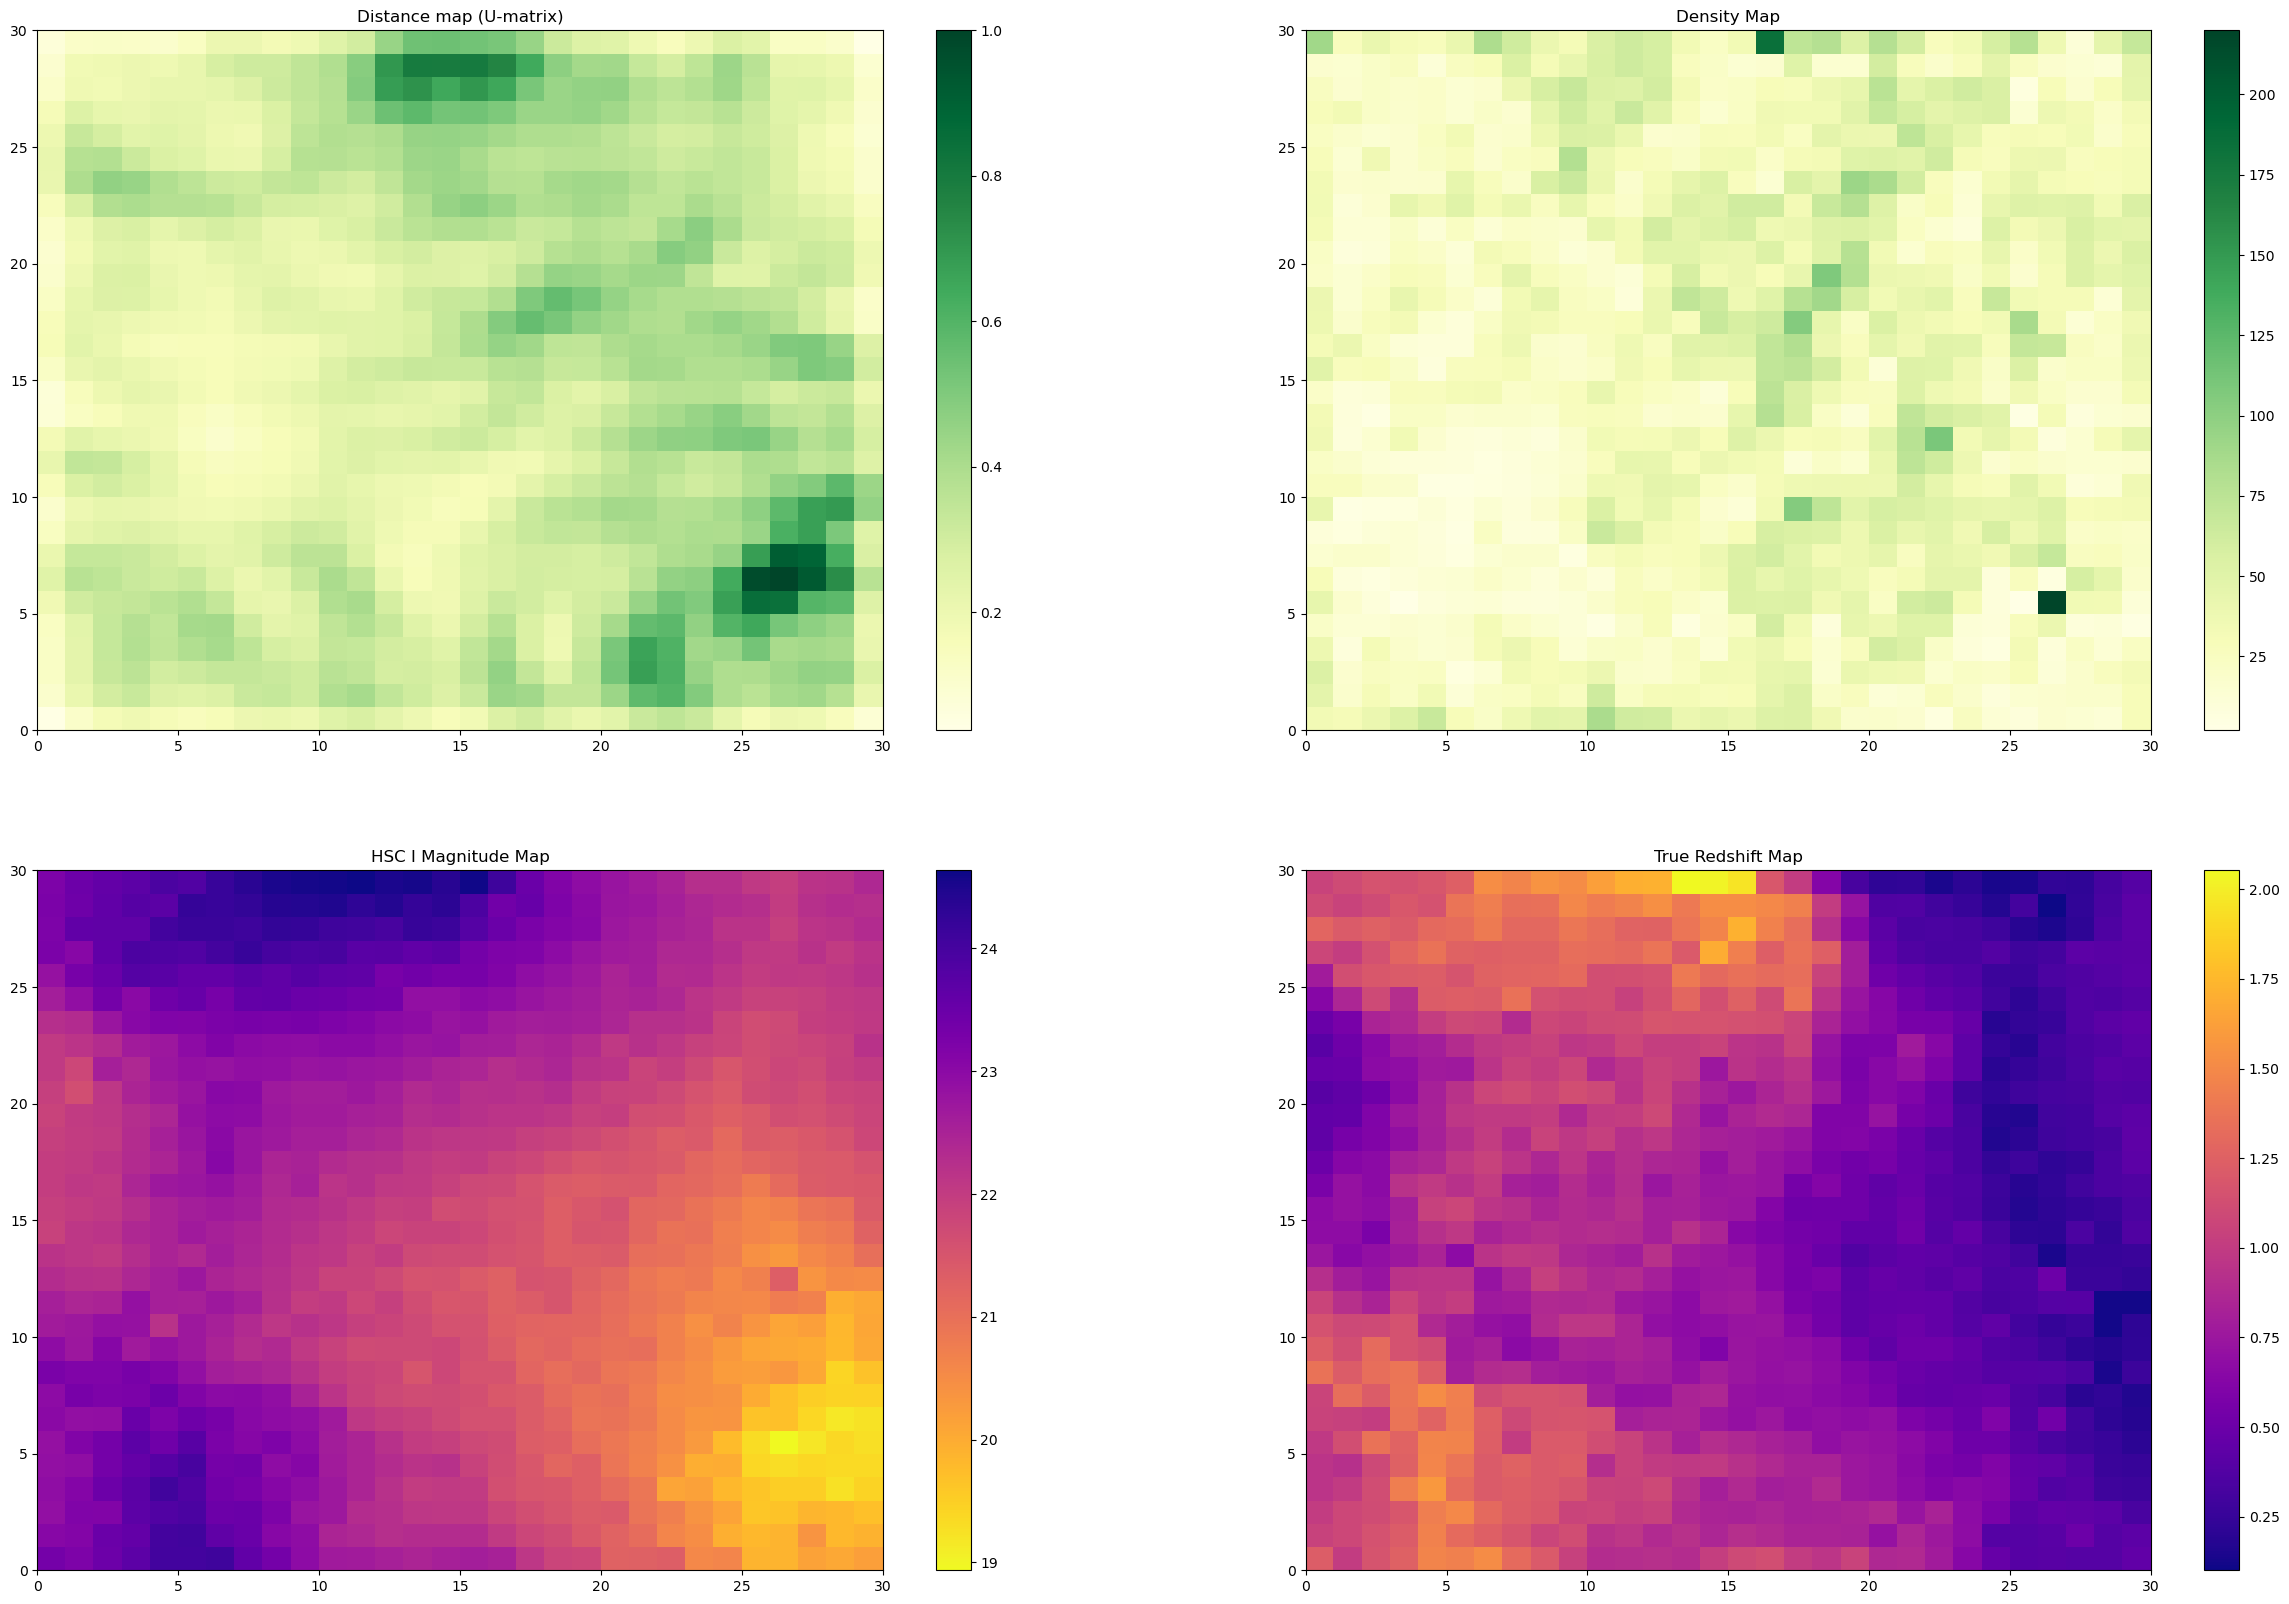

Topological error: 0.19283765118081056
Quantization error: 0.6385394201935579
Topological error: 0.19283765118081056
Quantization error: 0.6385394201935579


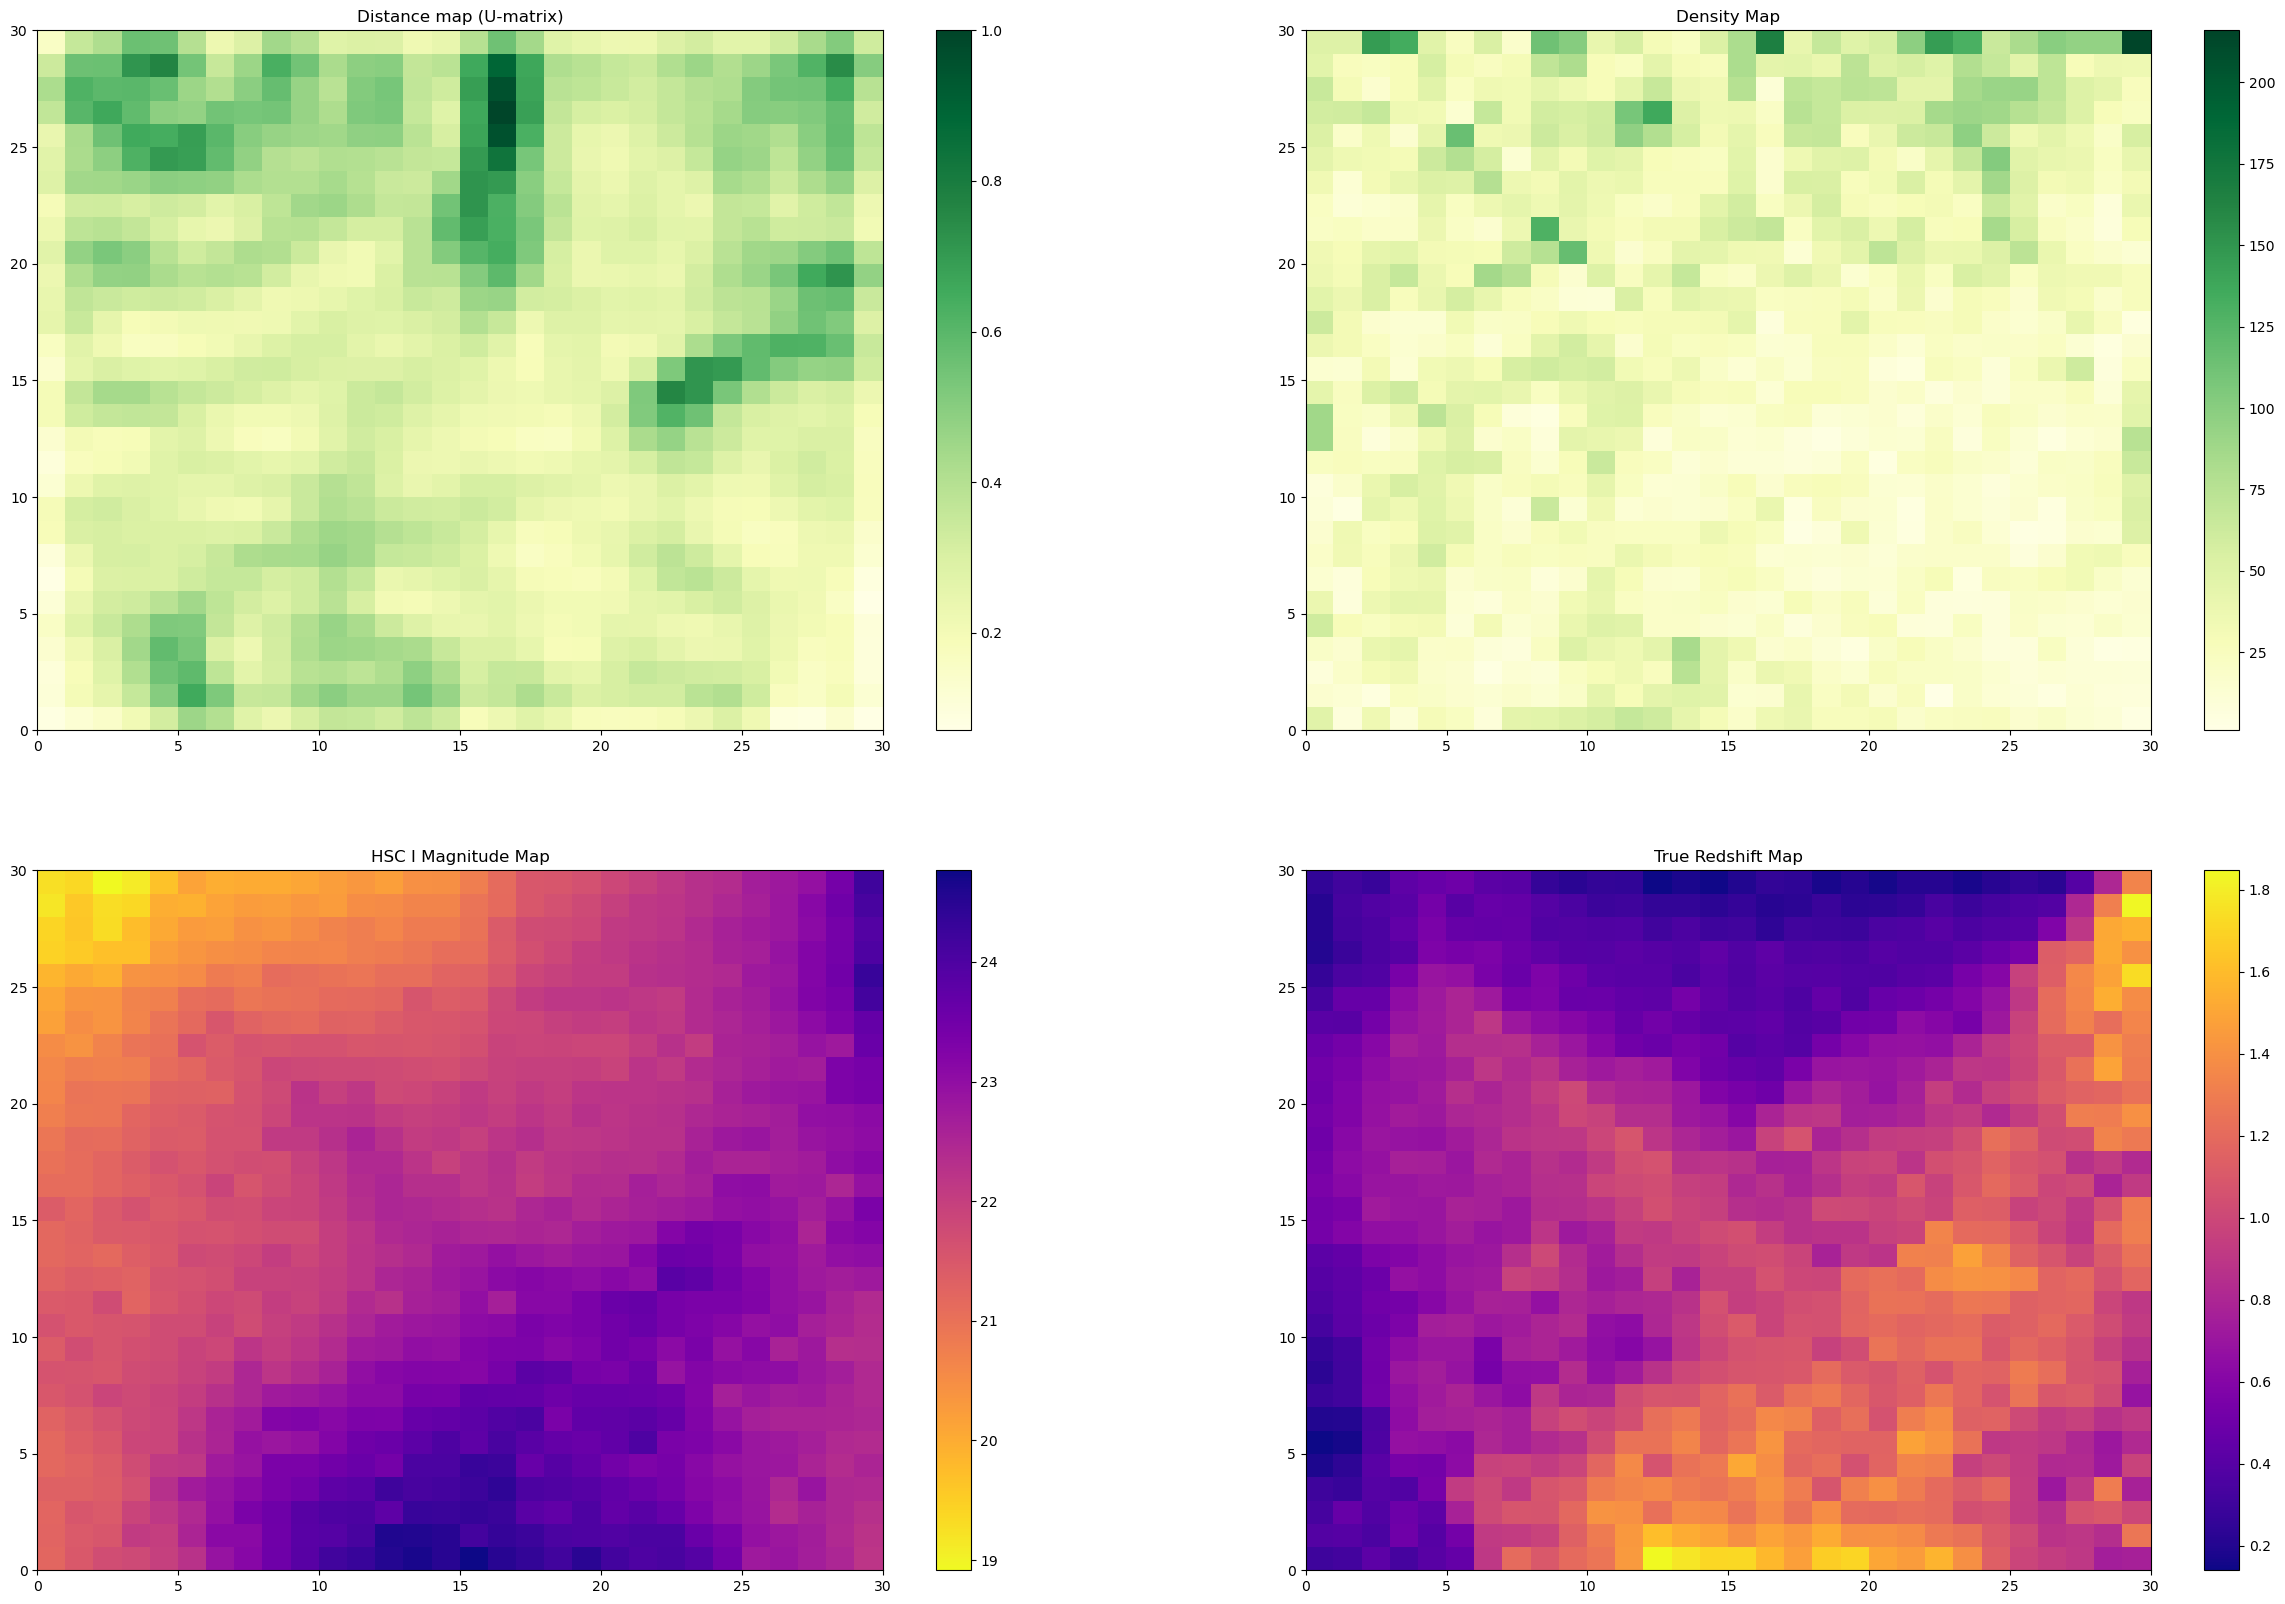

Topological error: 0.2040898830980696
Quantization error: 0.668641624911535
Topological error: 0.2040898830980696
Quantization error: 0.668641624911535


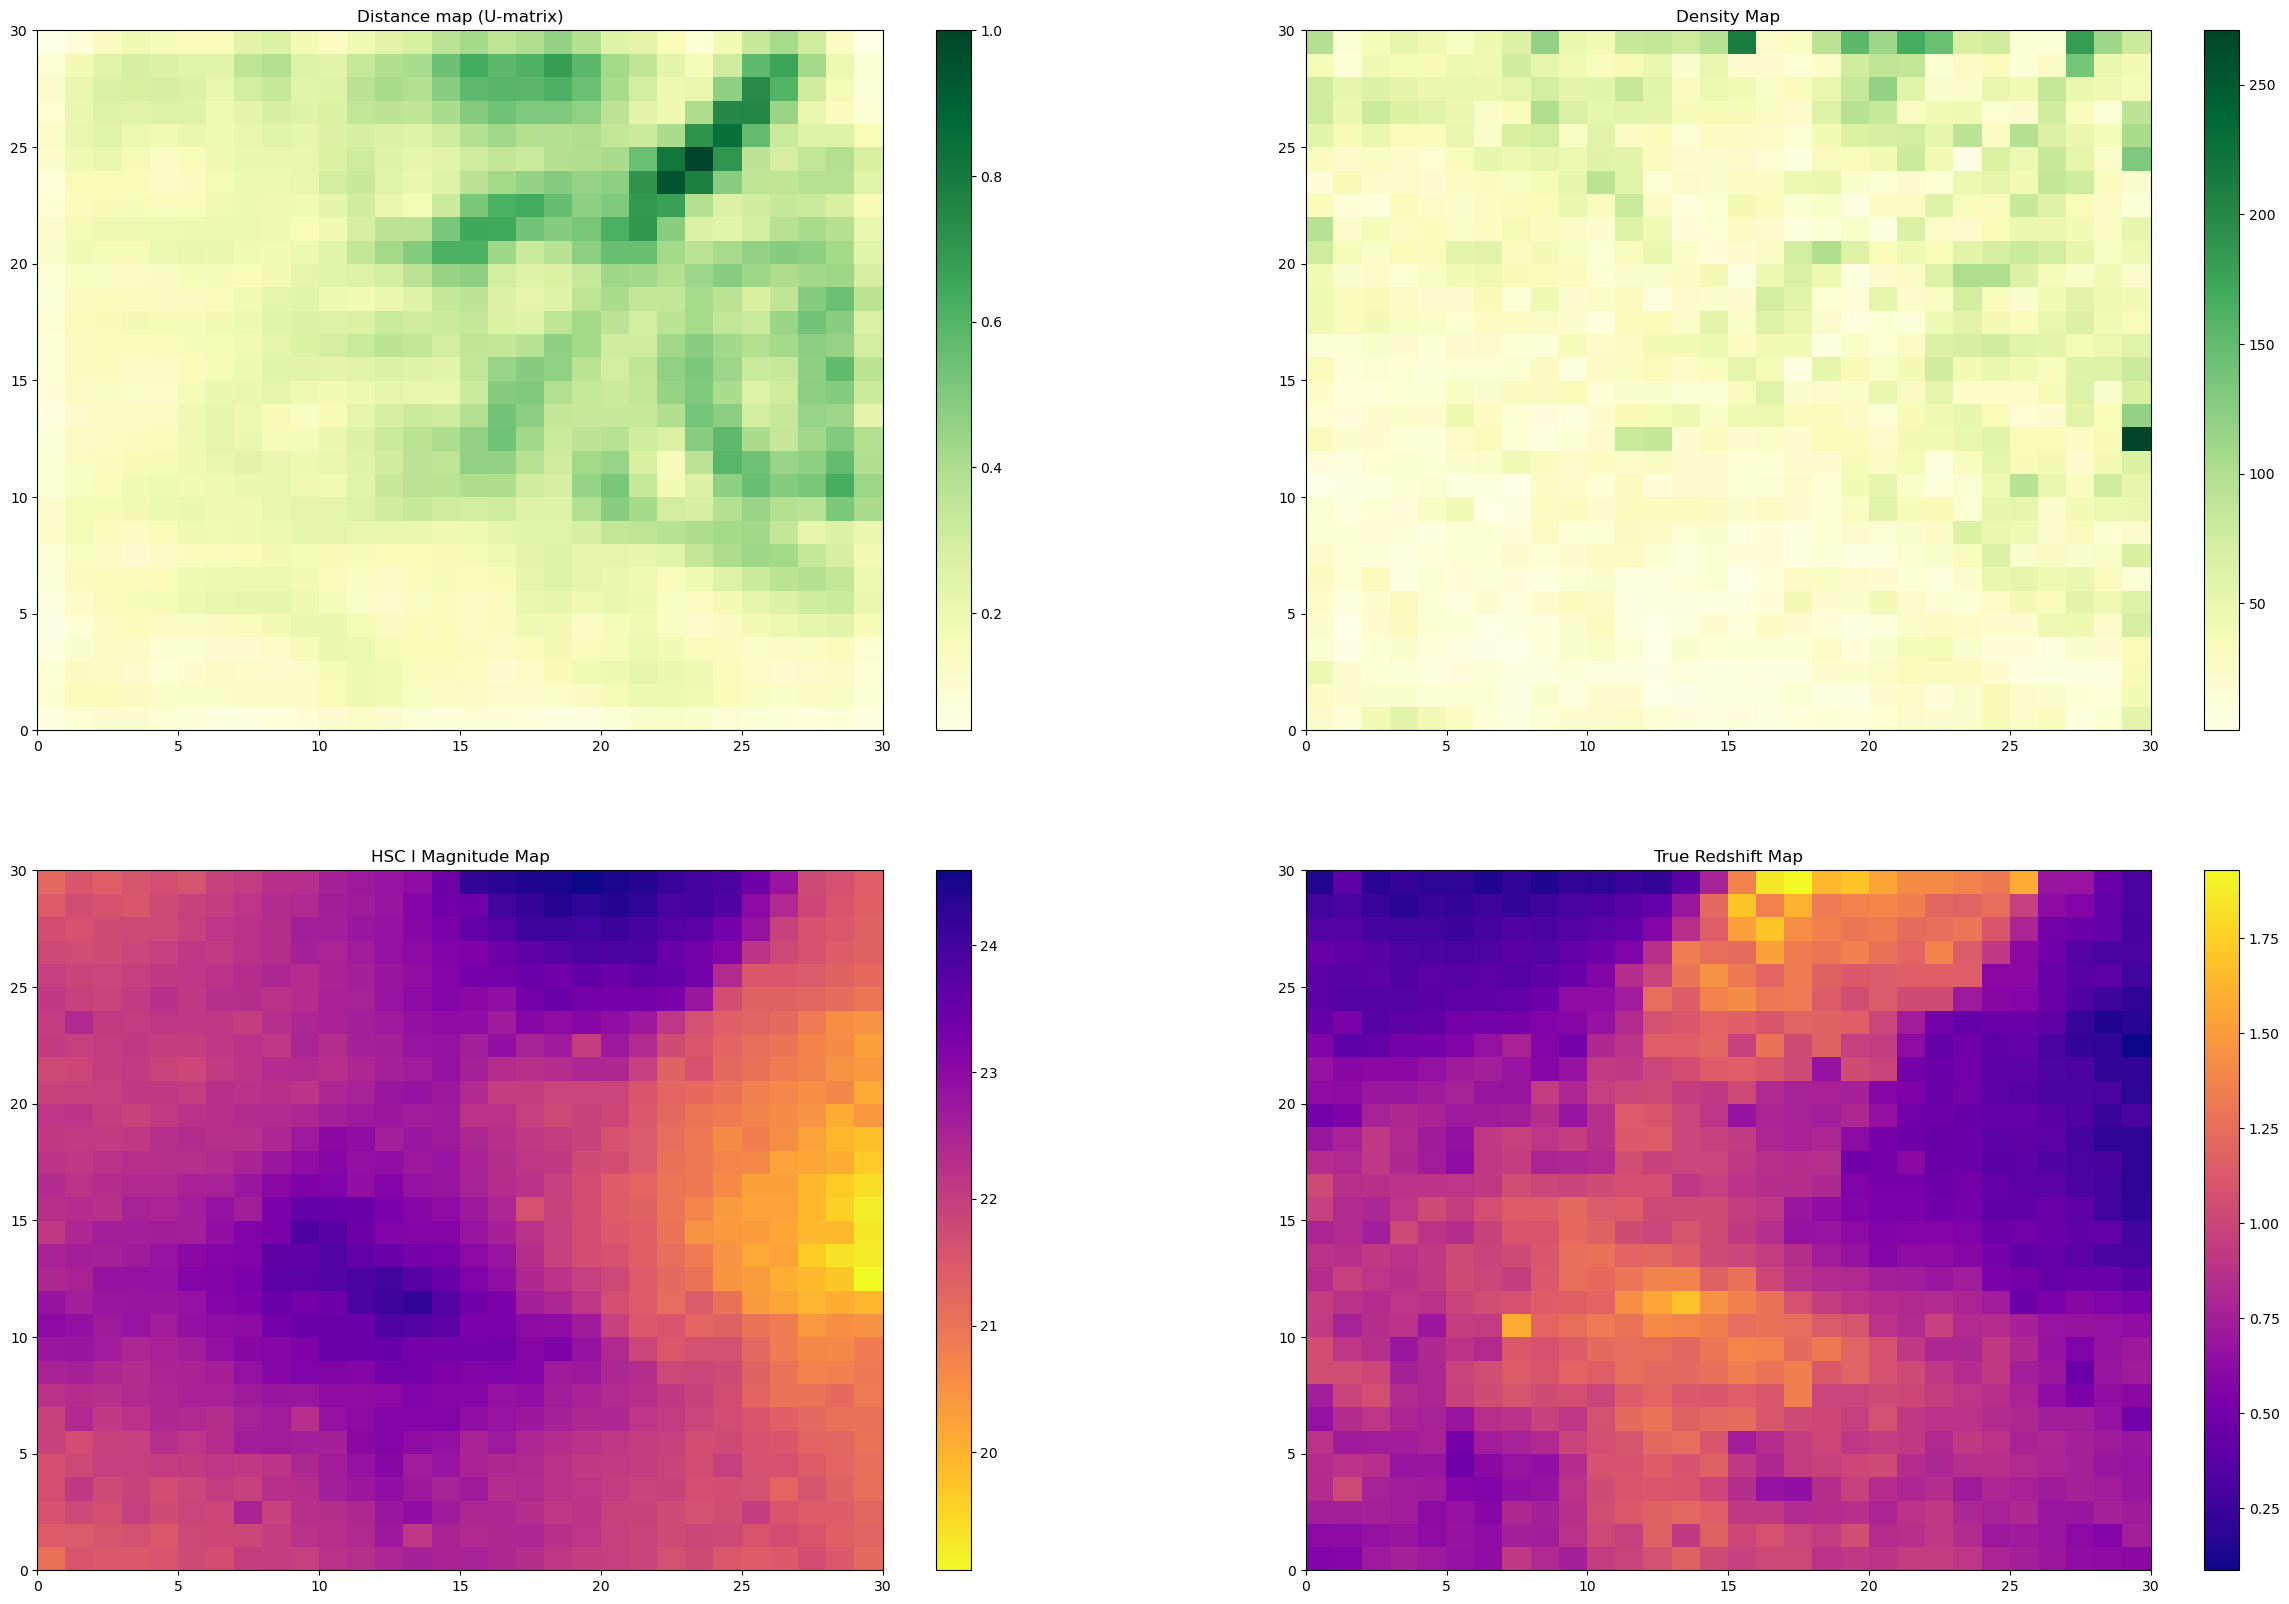

Topological error: 0.10460532964996799
Quantization error: 0.6173081910804747
Topological error: 0.10460532964996799
Quantization error: 0.6173081910804747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


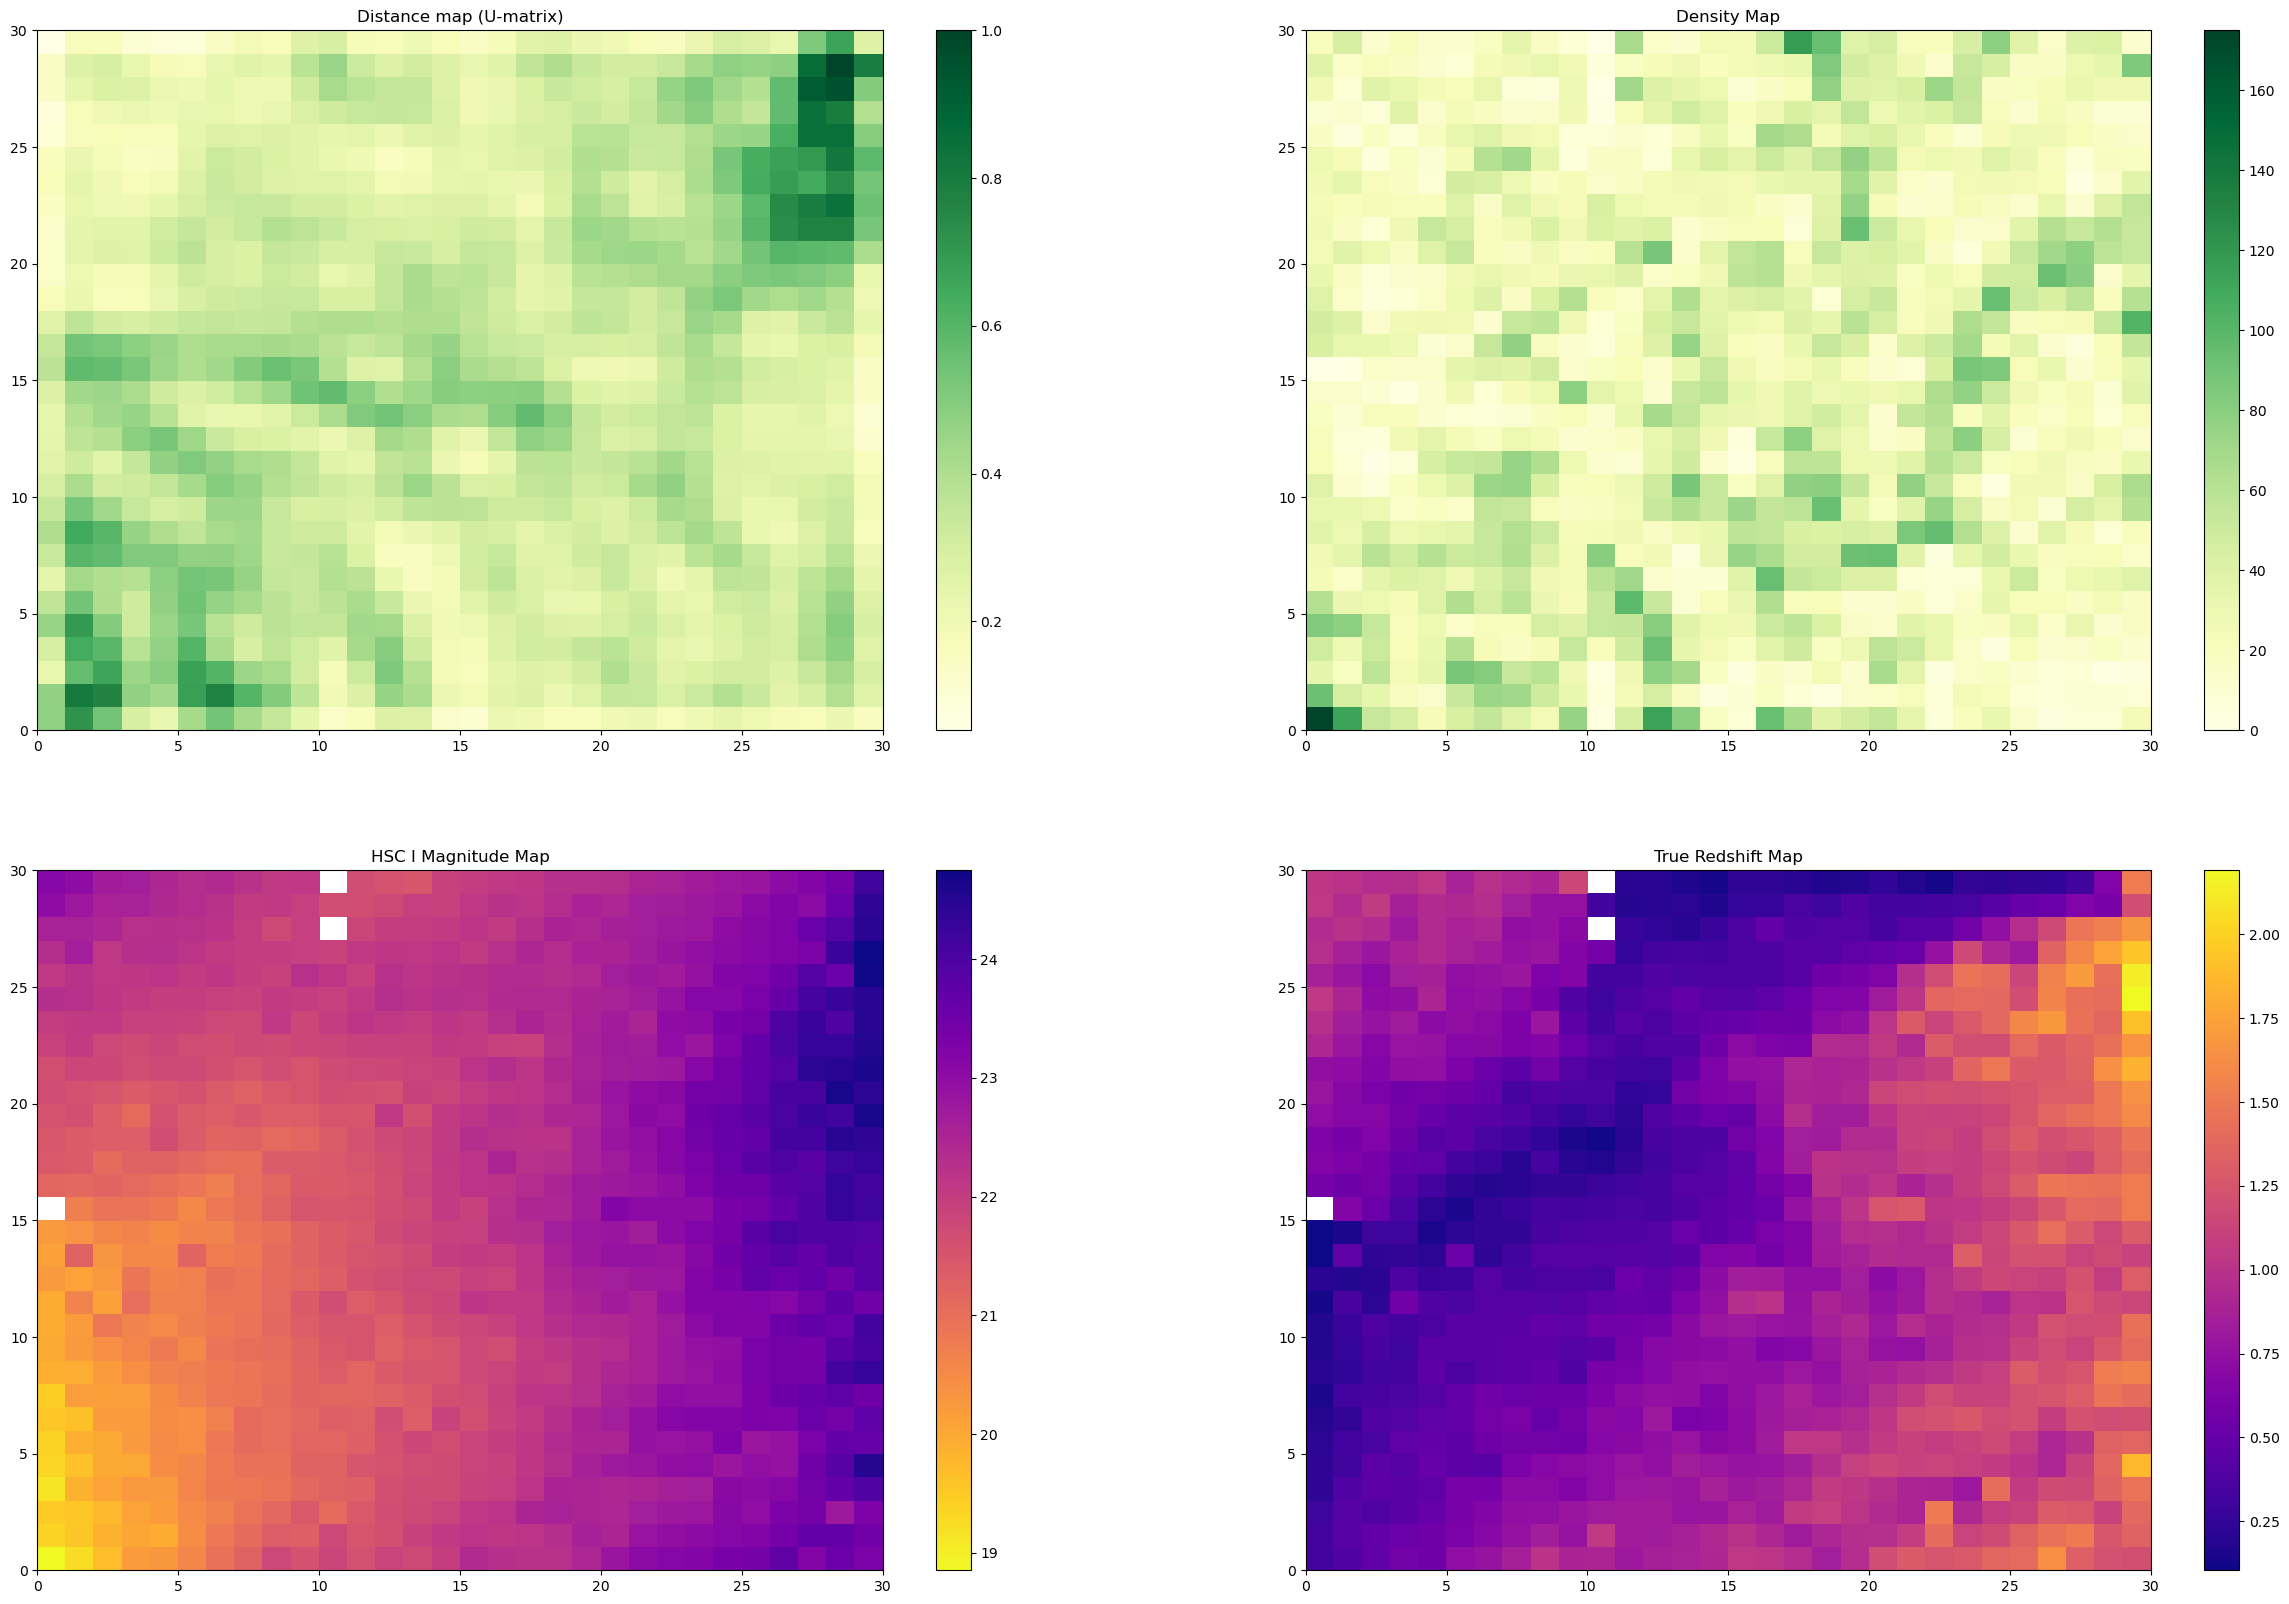

Topological error: 0.16275309099484553
Quantization error: 0.6631545262973058
Topological error: 0.16275309099484553
Quantization error: 0.6631545262973058


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


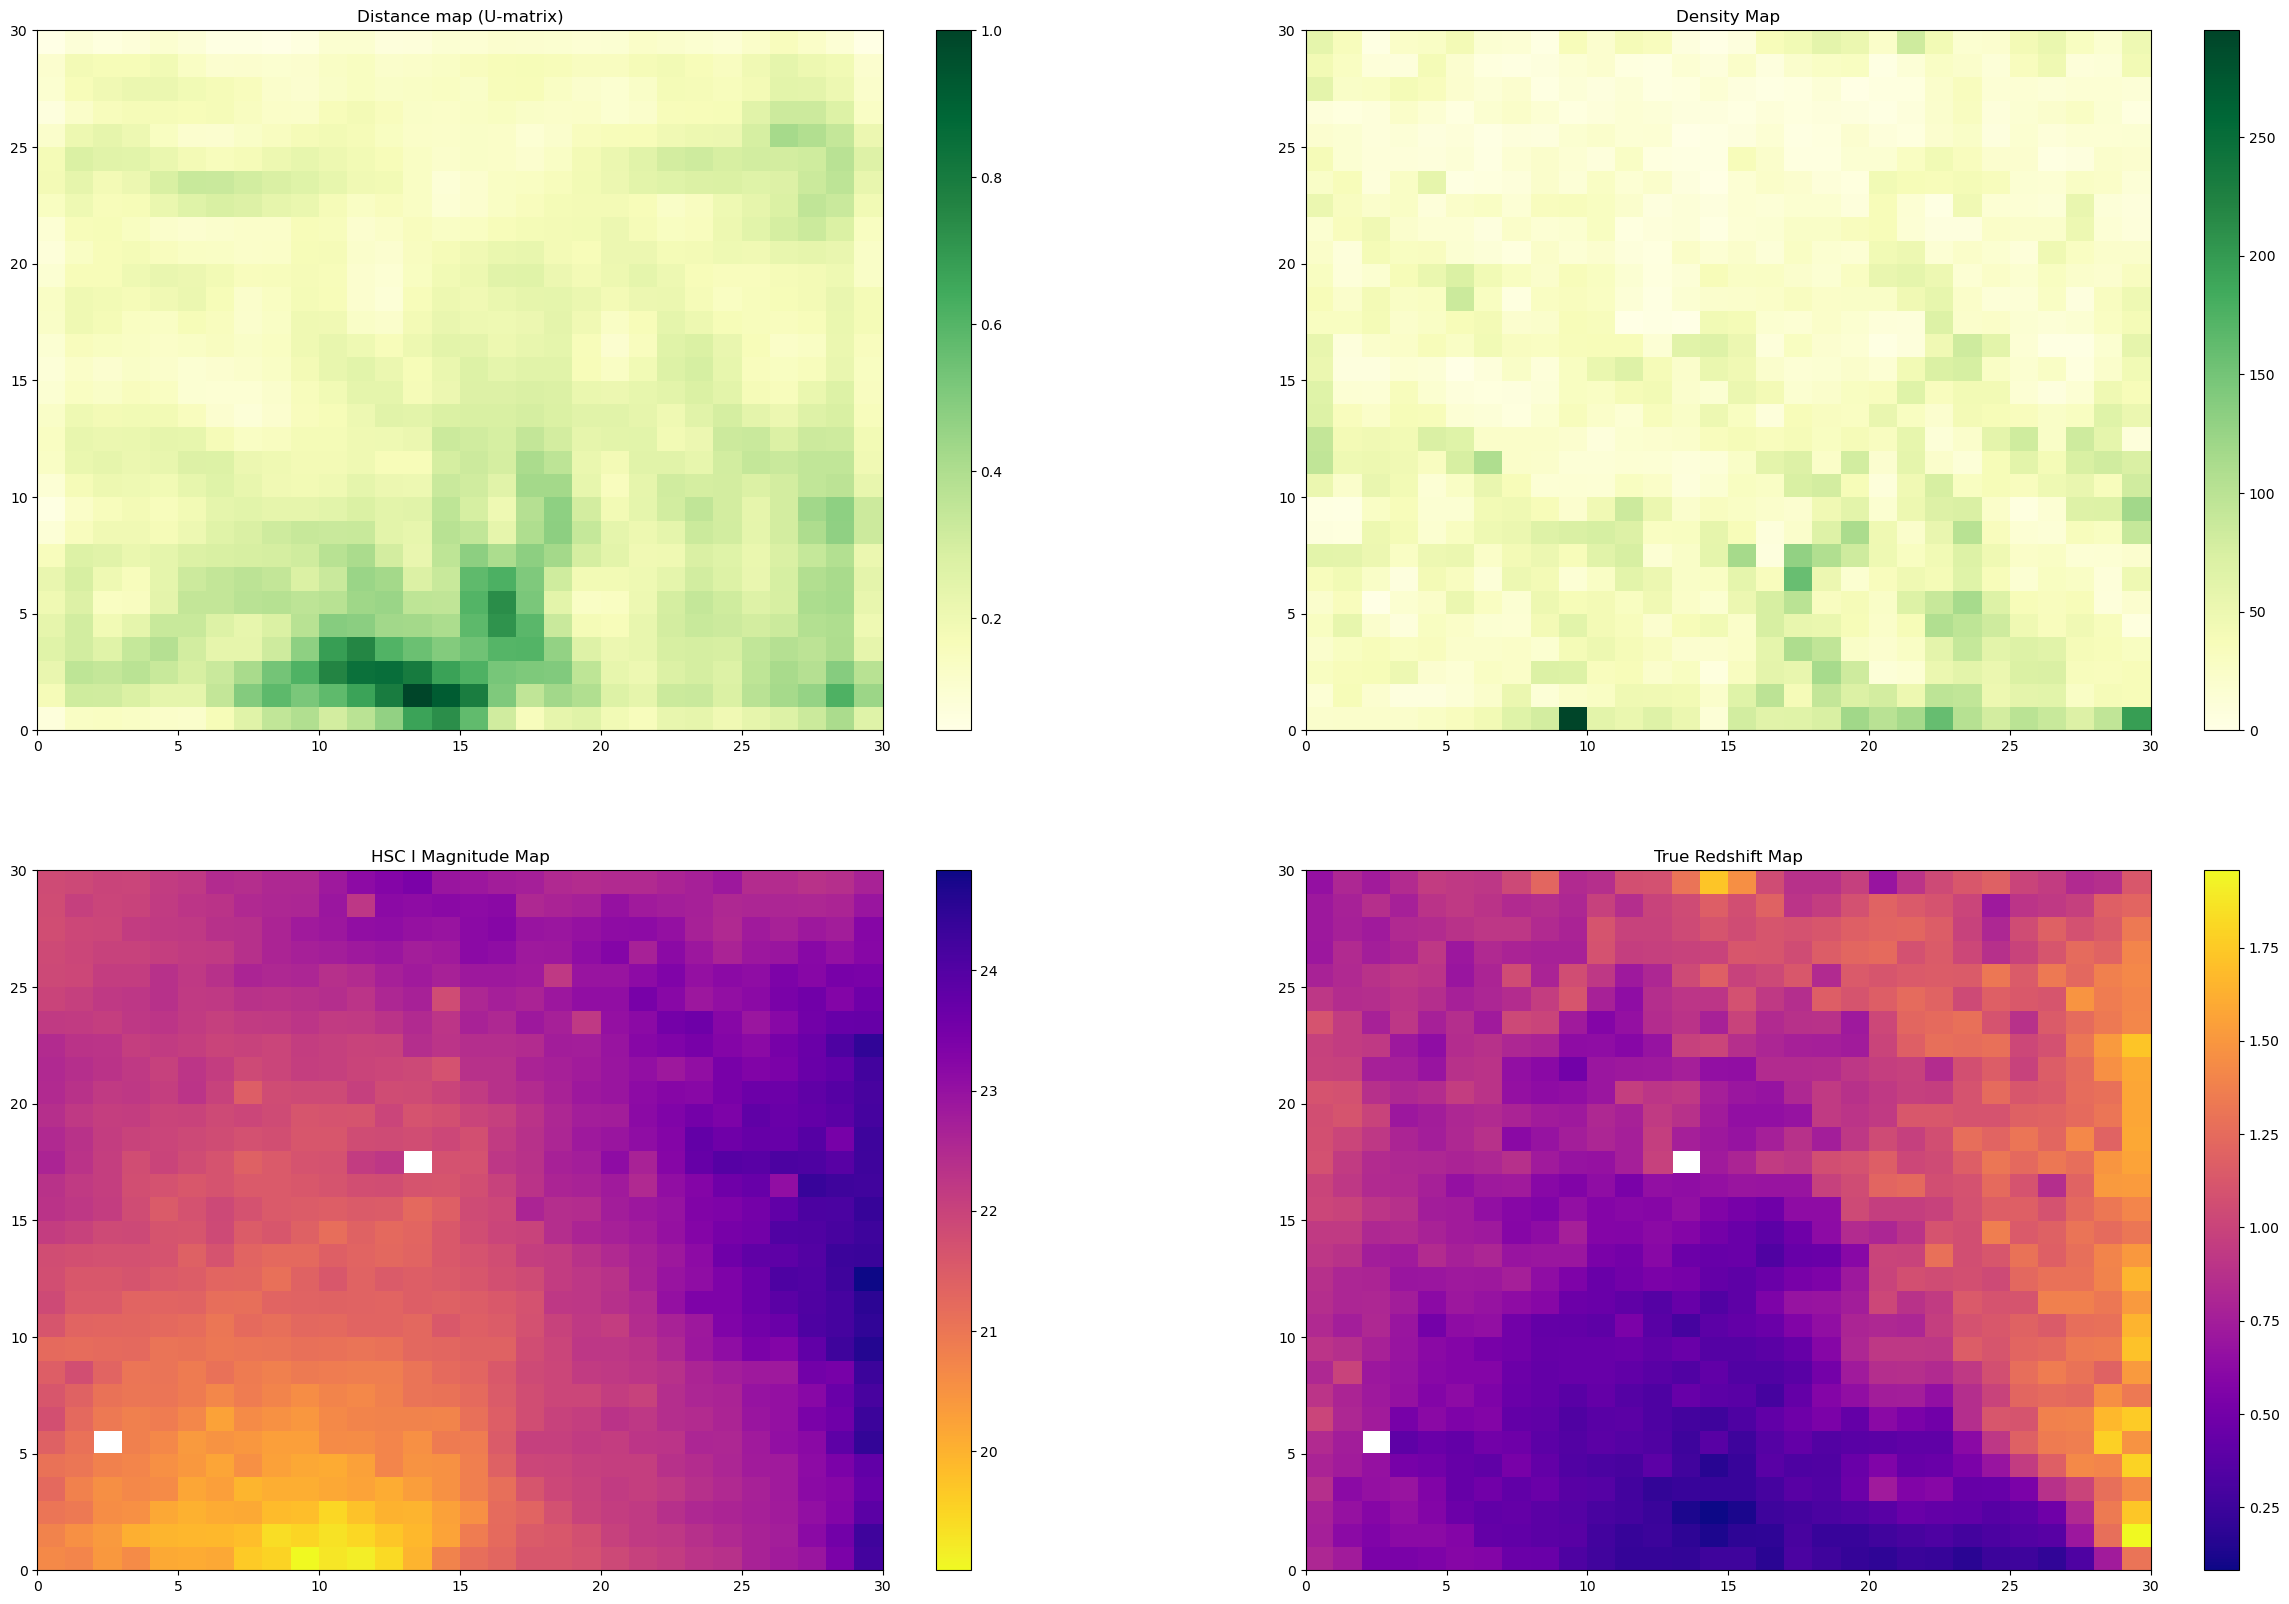

Topological error: 0.17195027456793452
Quantization error: 0.6682707046819495
Topological error: 0.17195027456793452
Quantization error: 0.6682707046819495


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


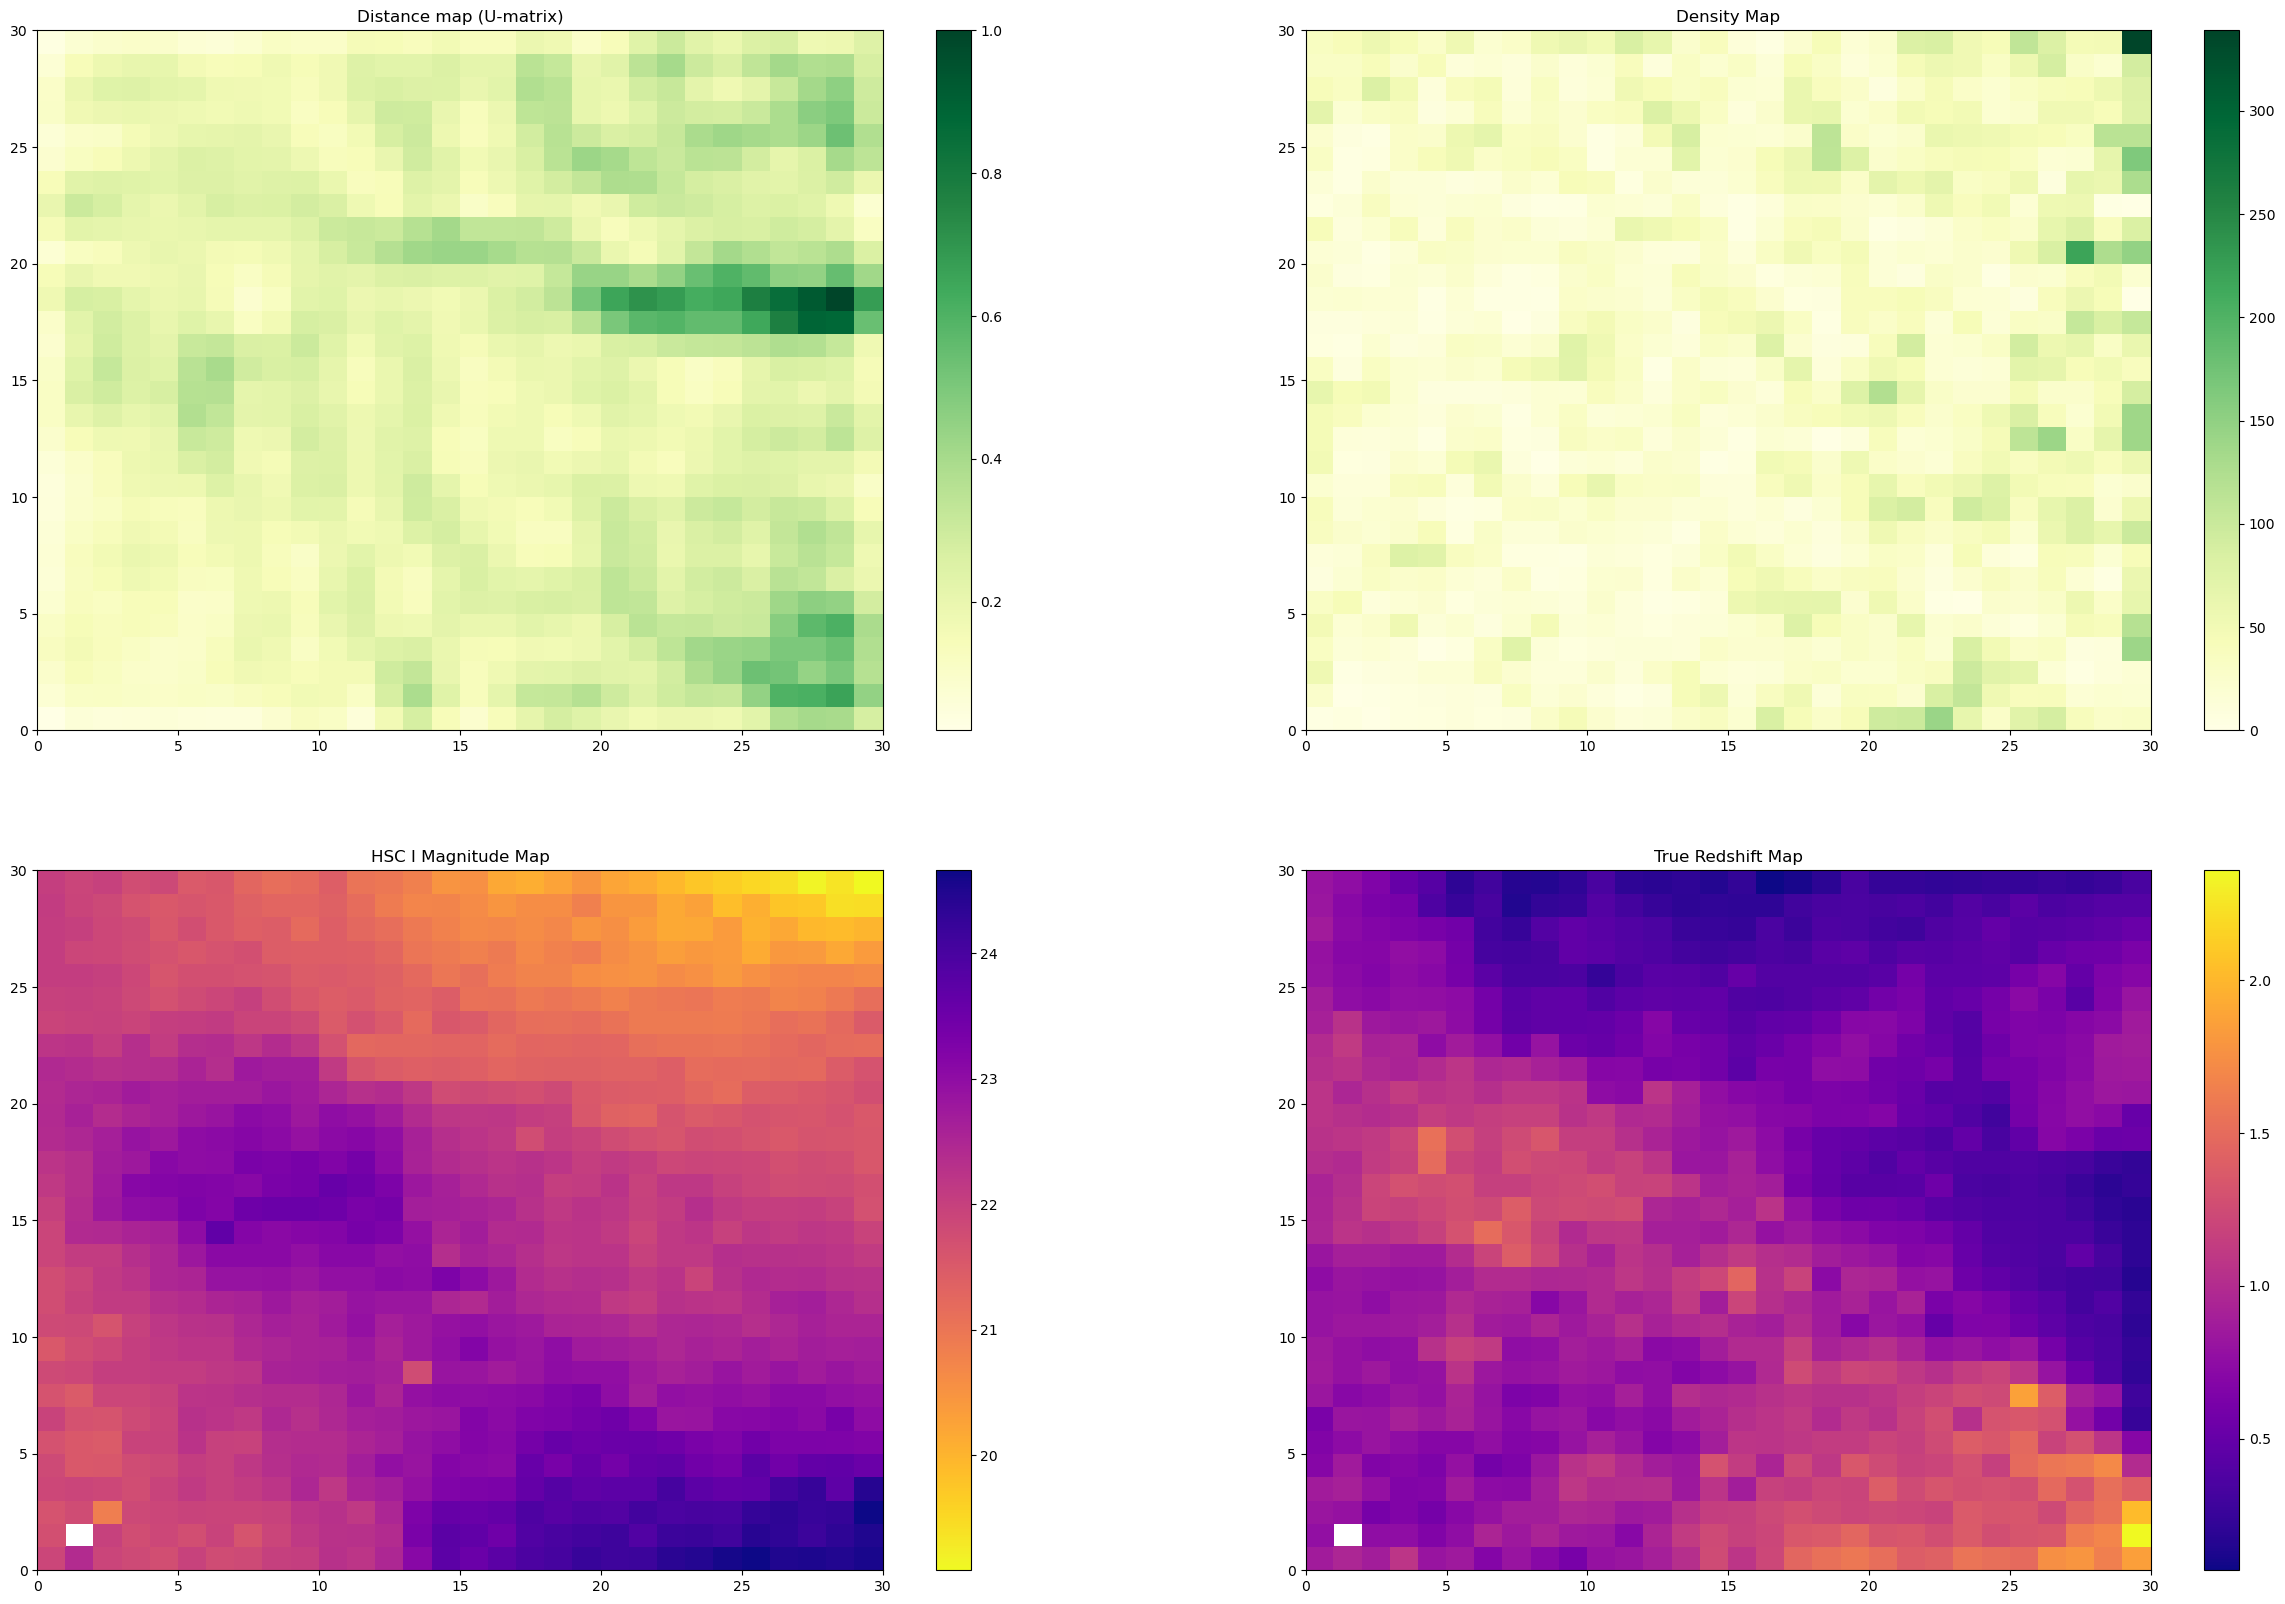

D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:547: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topological error: 0.17599299262203955
Quantization error: 0.6708757364996768
Topological error: 0.17599299262203955
Quantization error: 0.6708757364996768


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


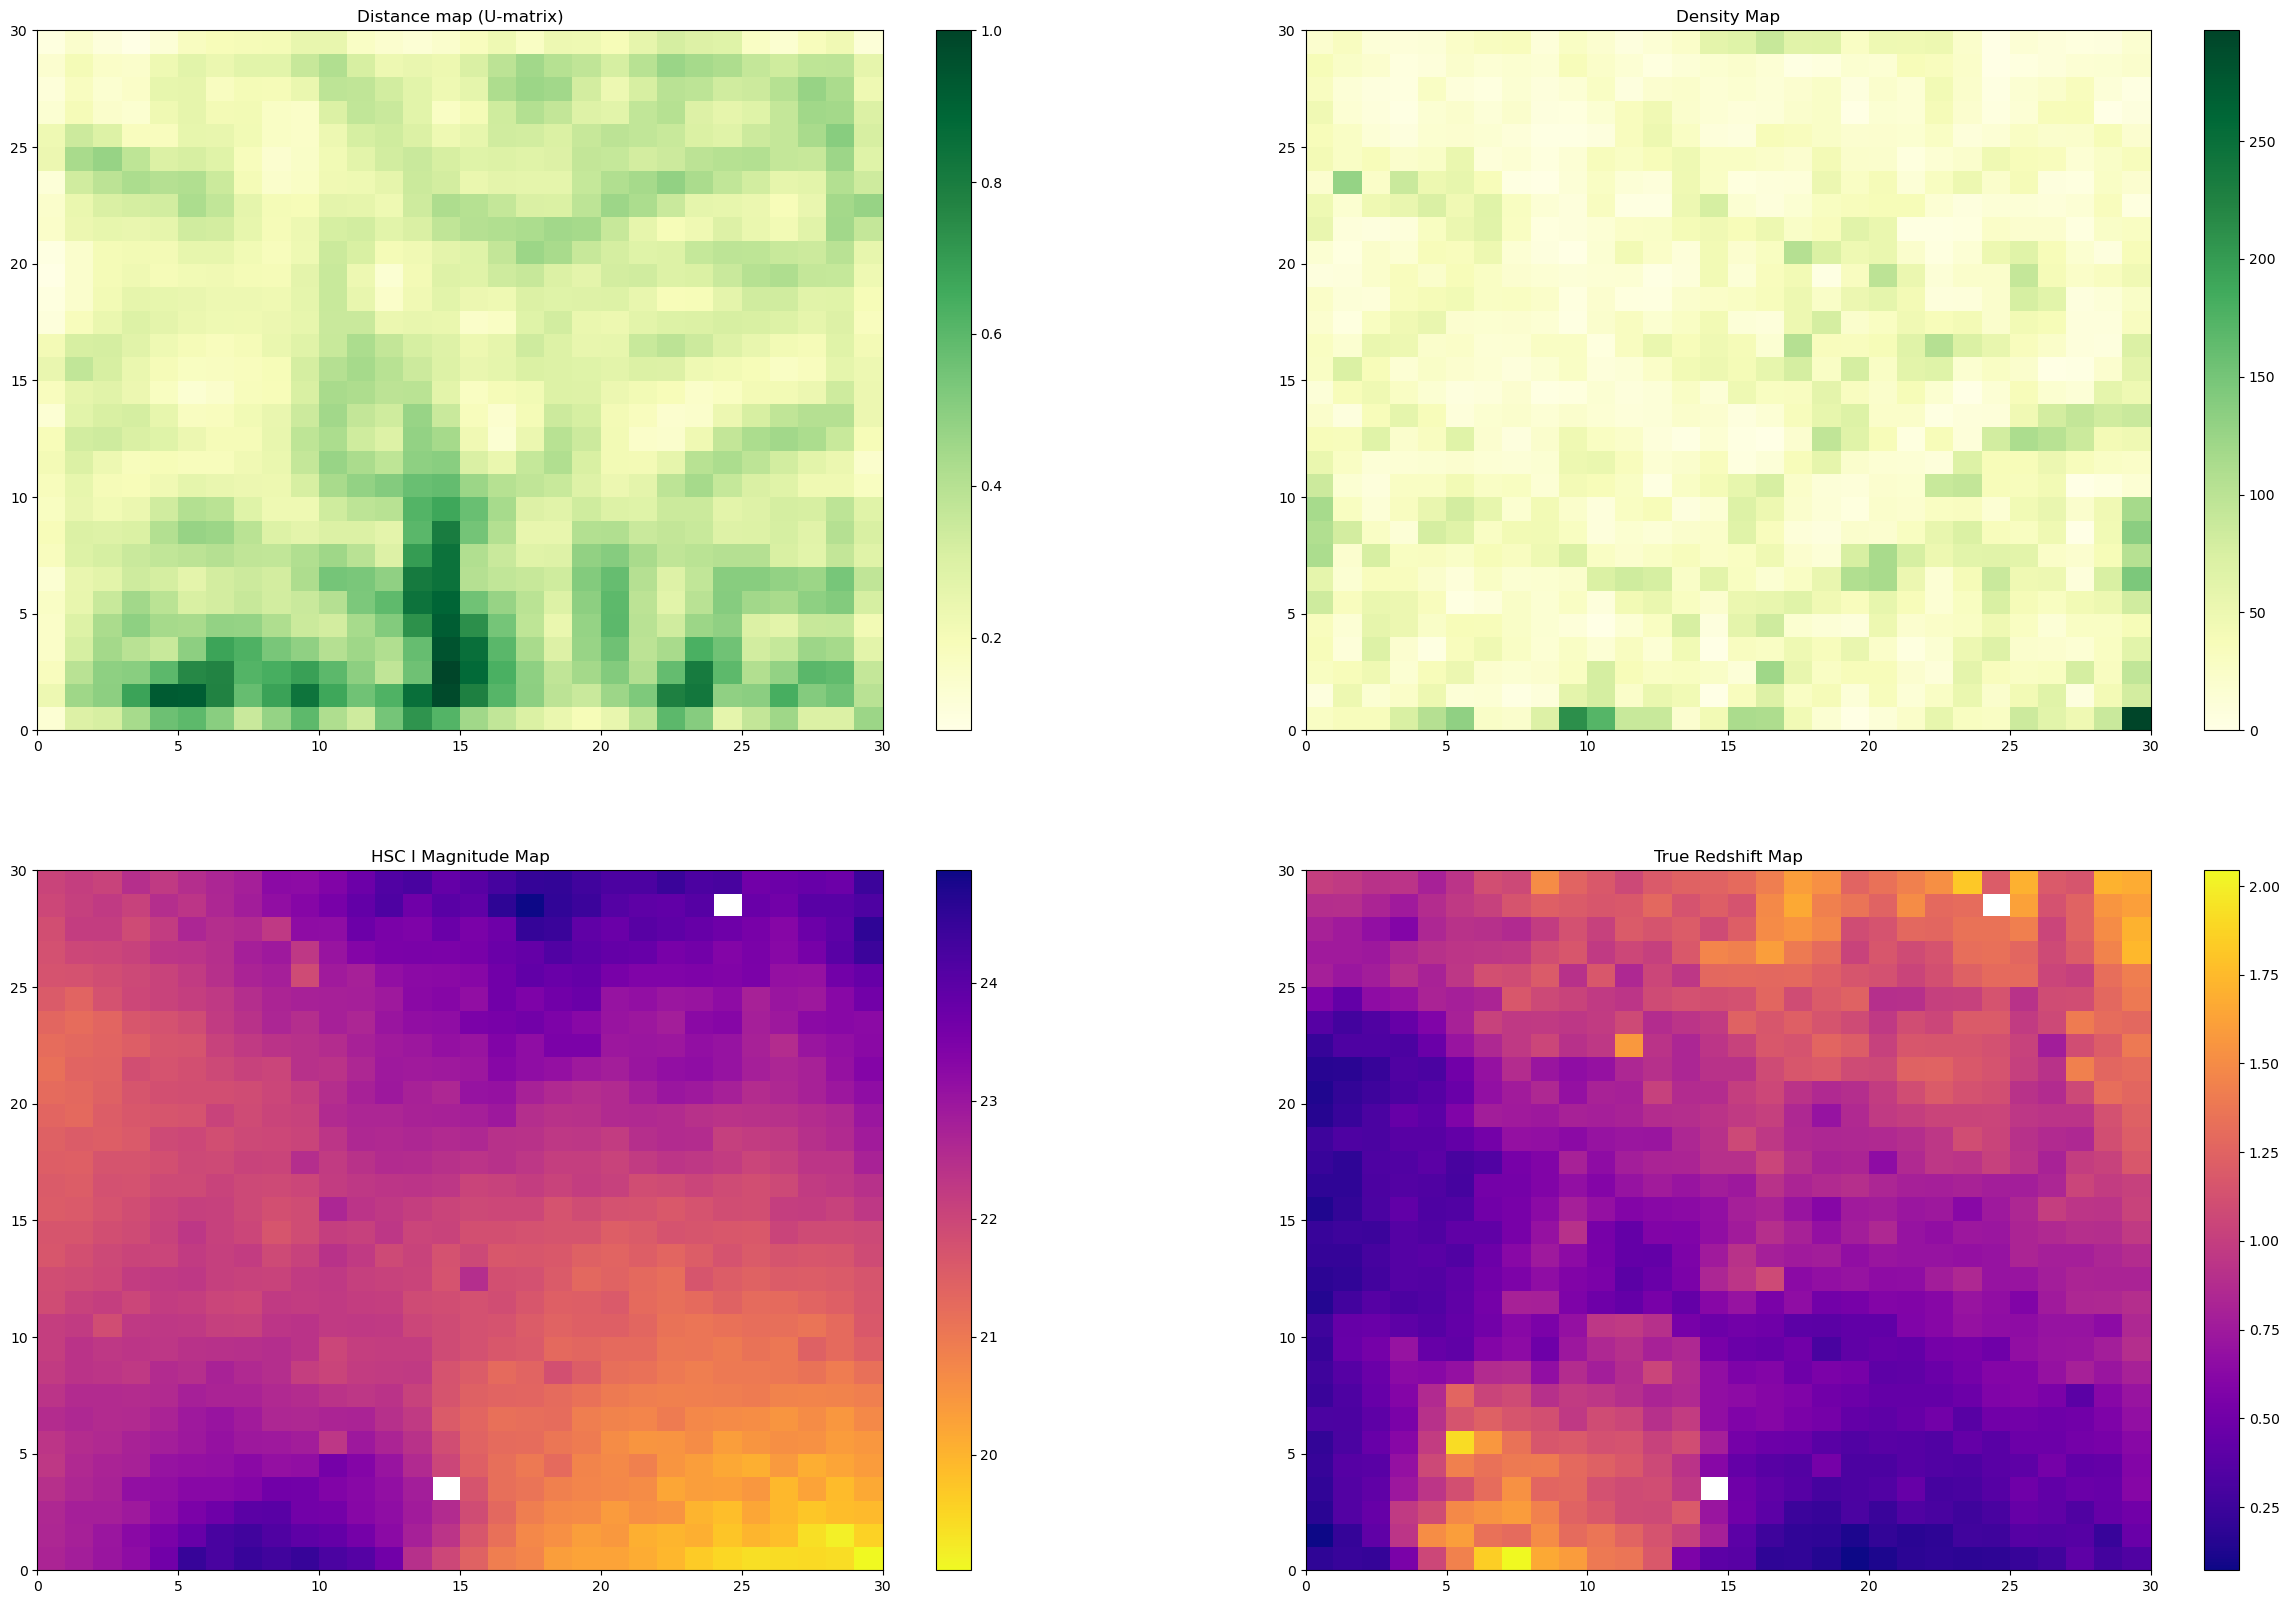

Topological error: 0.19169221439881415
Quantization error: 0.672177553958463
Topological error: 0.19169221439881415
Quantization error: 0.672177553958463


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


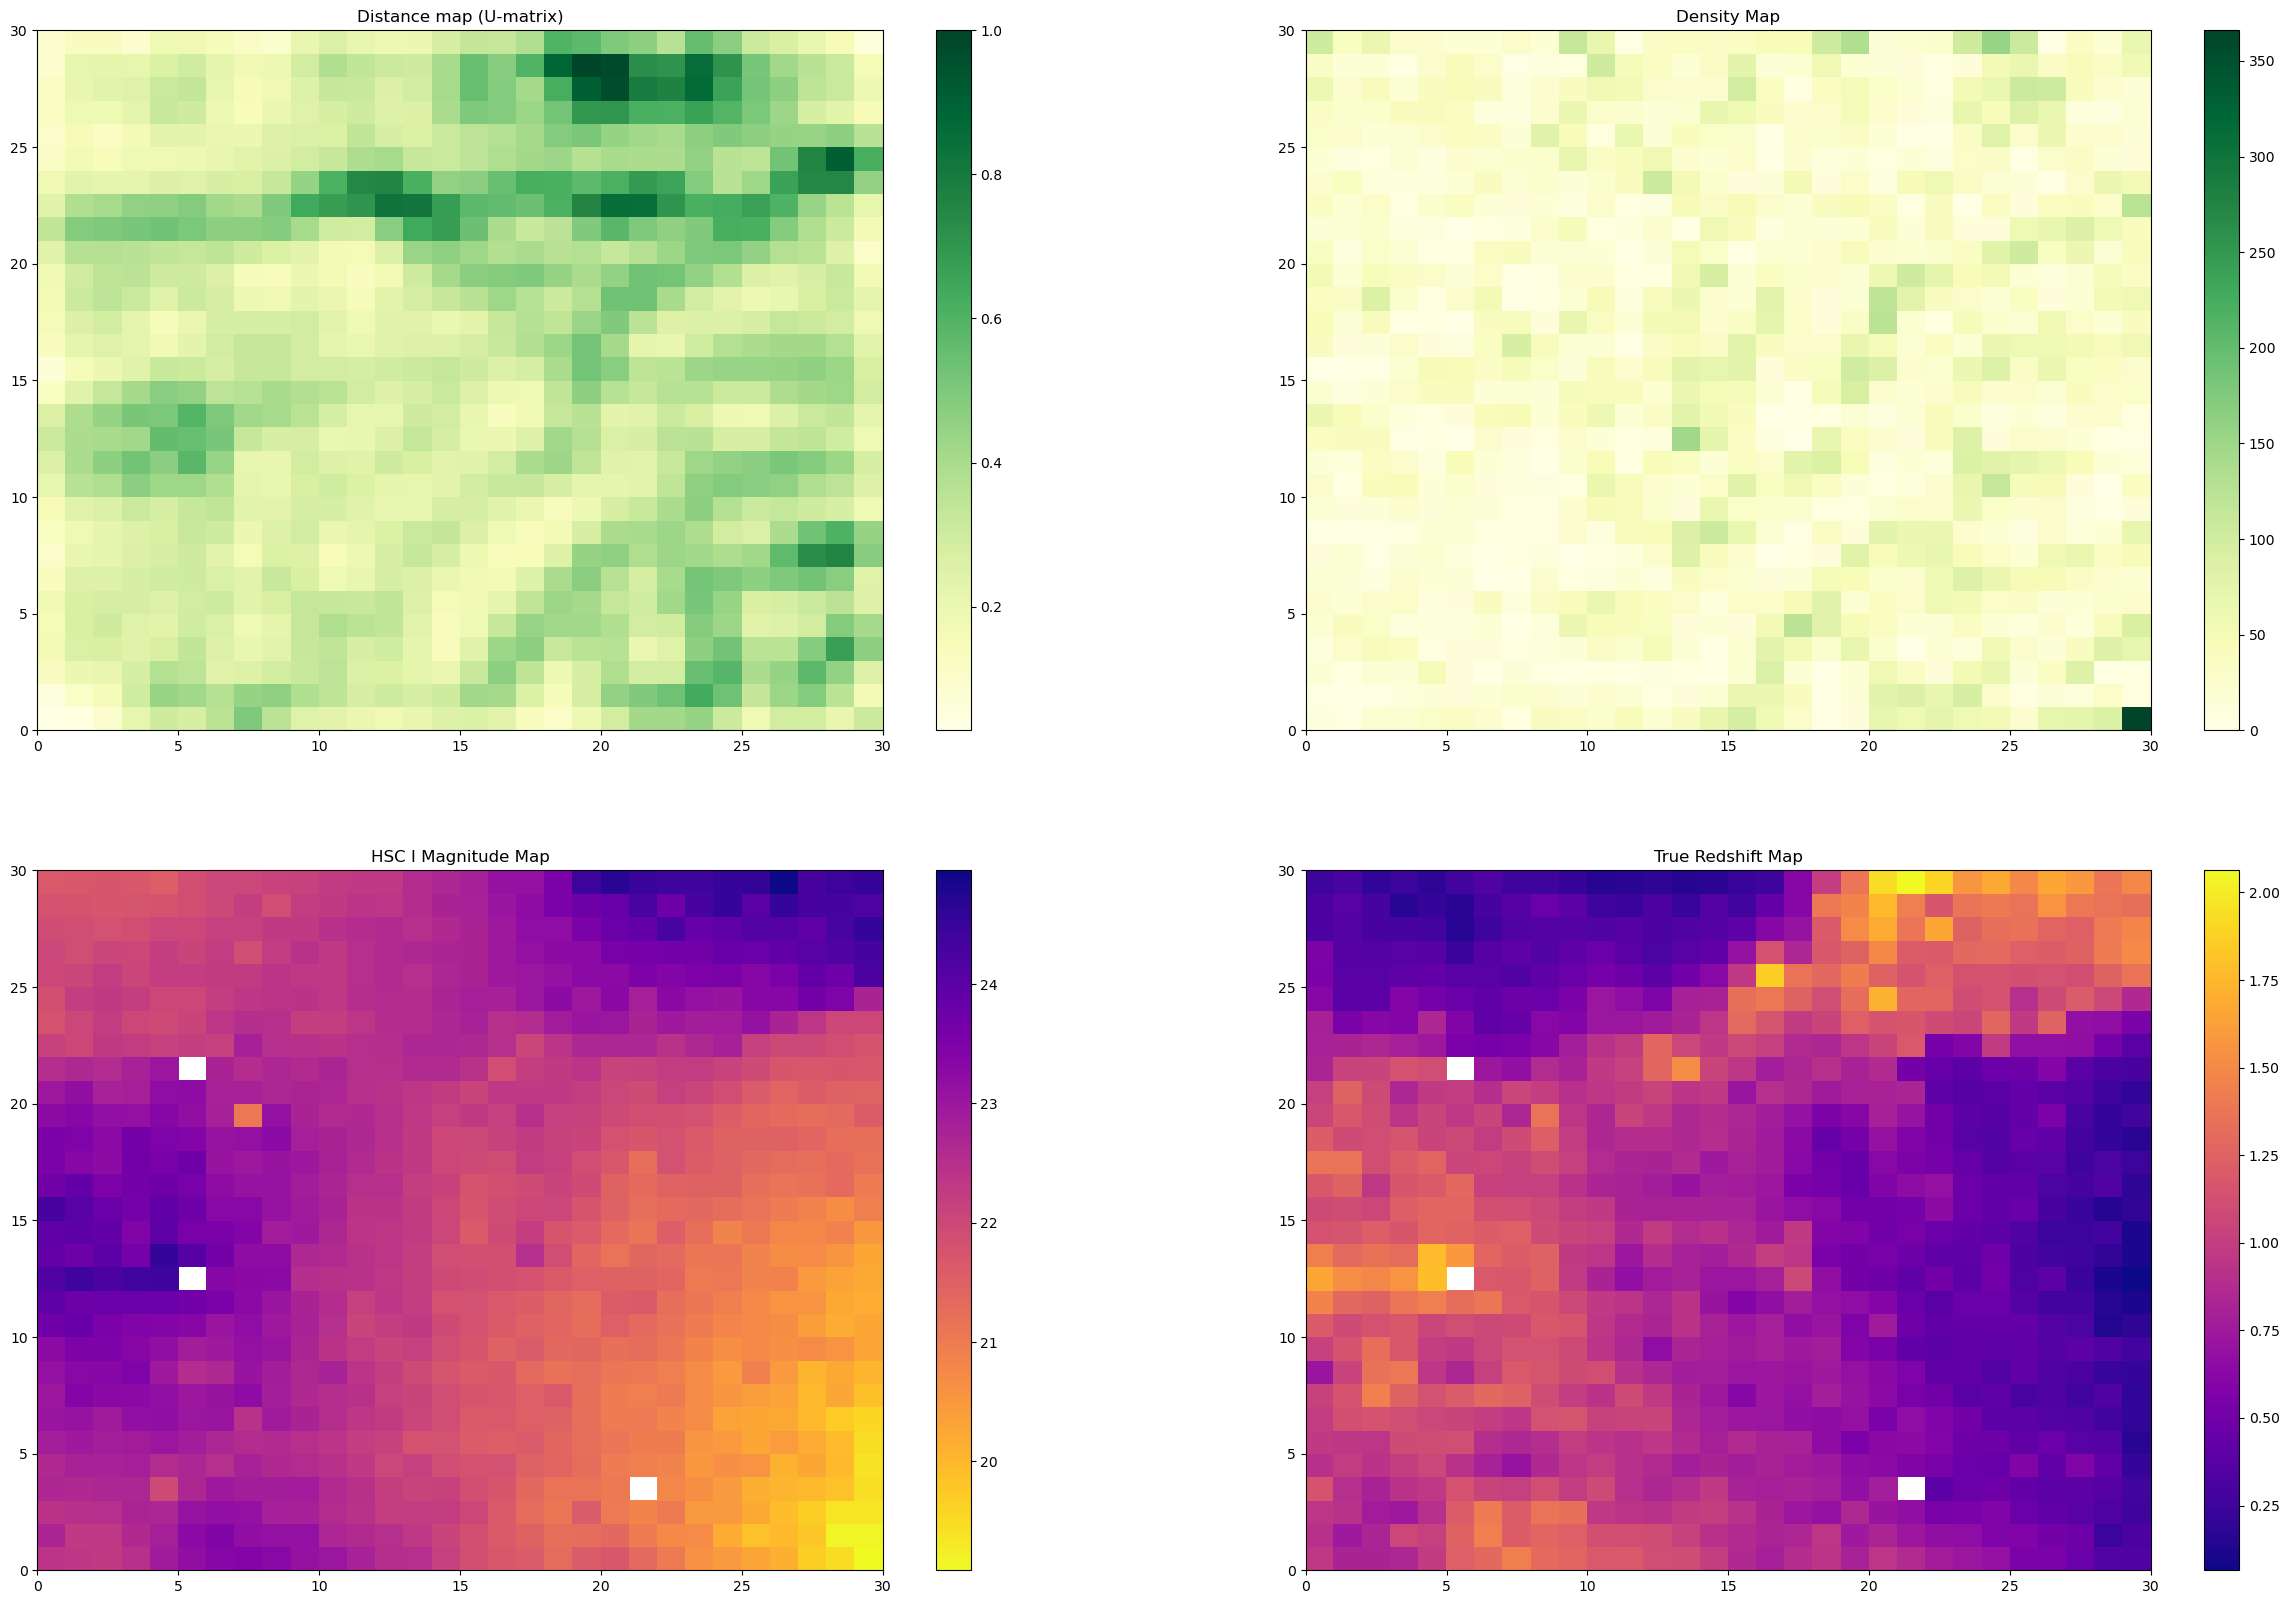

Topological error: 0.18879493312670553
Quantization error: 0.6898294166436332
Topological error: 0.18879493312670553
Quantization error: 0.6898294166436332


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


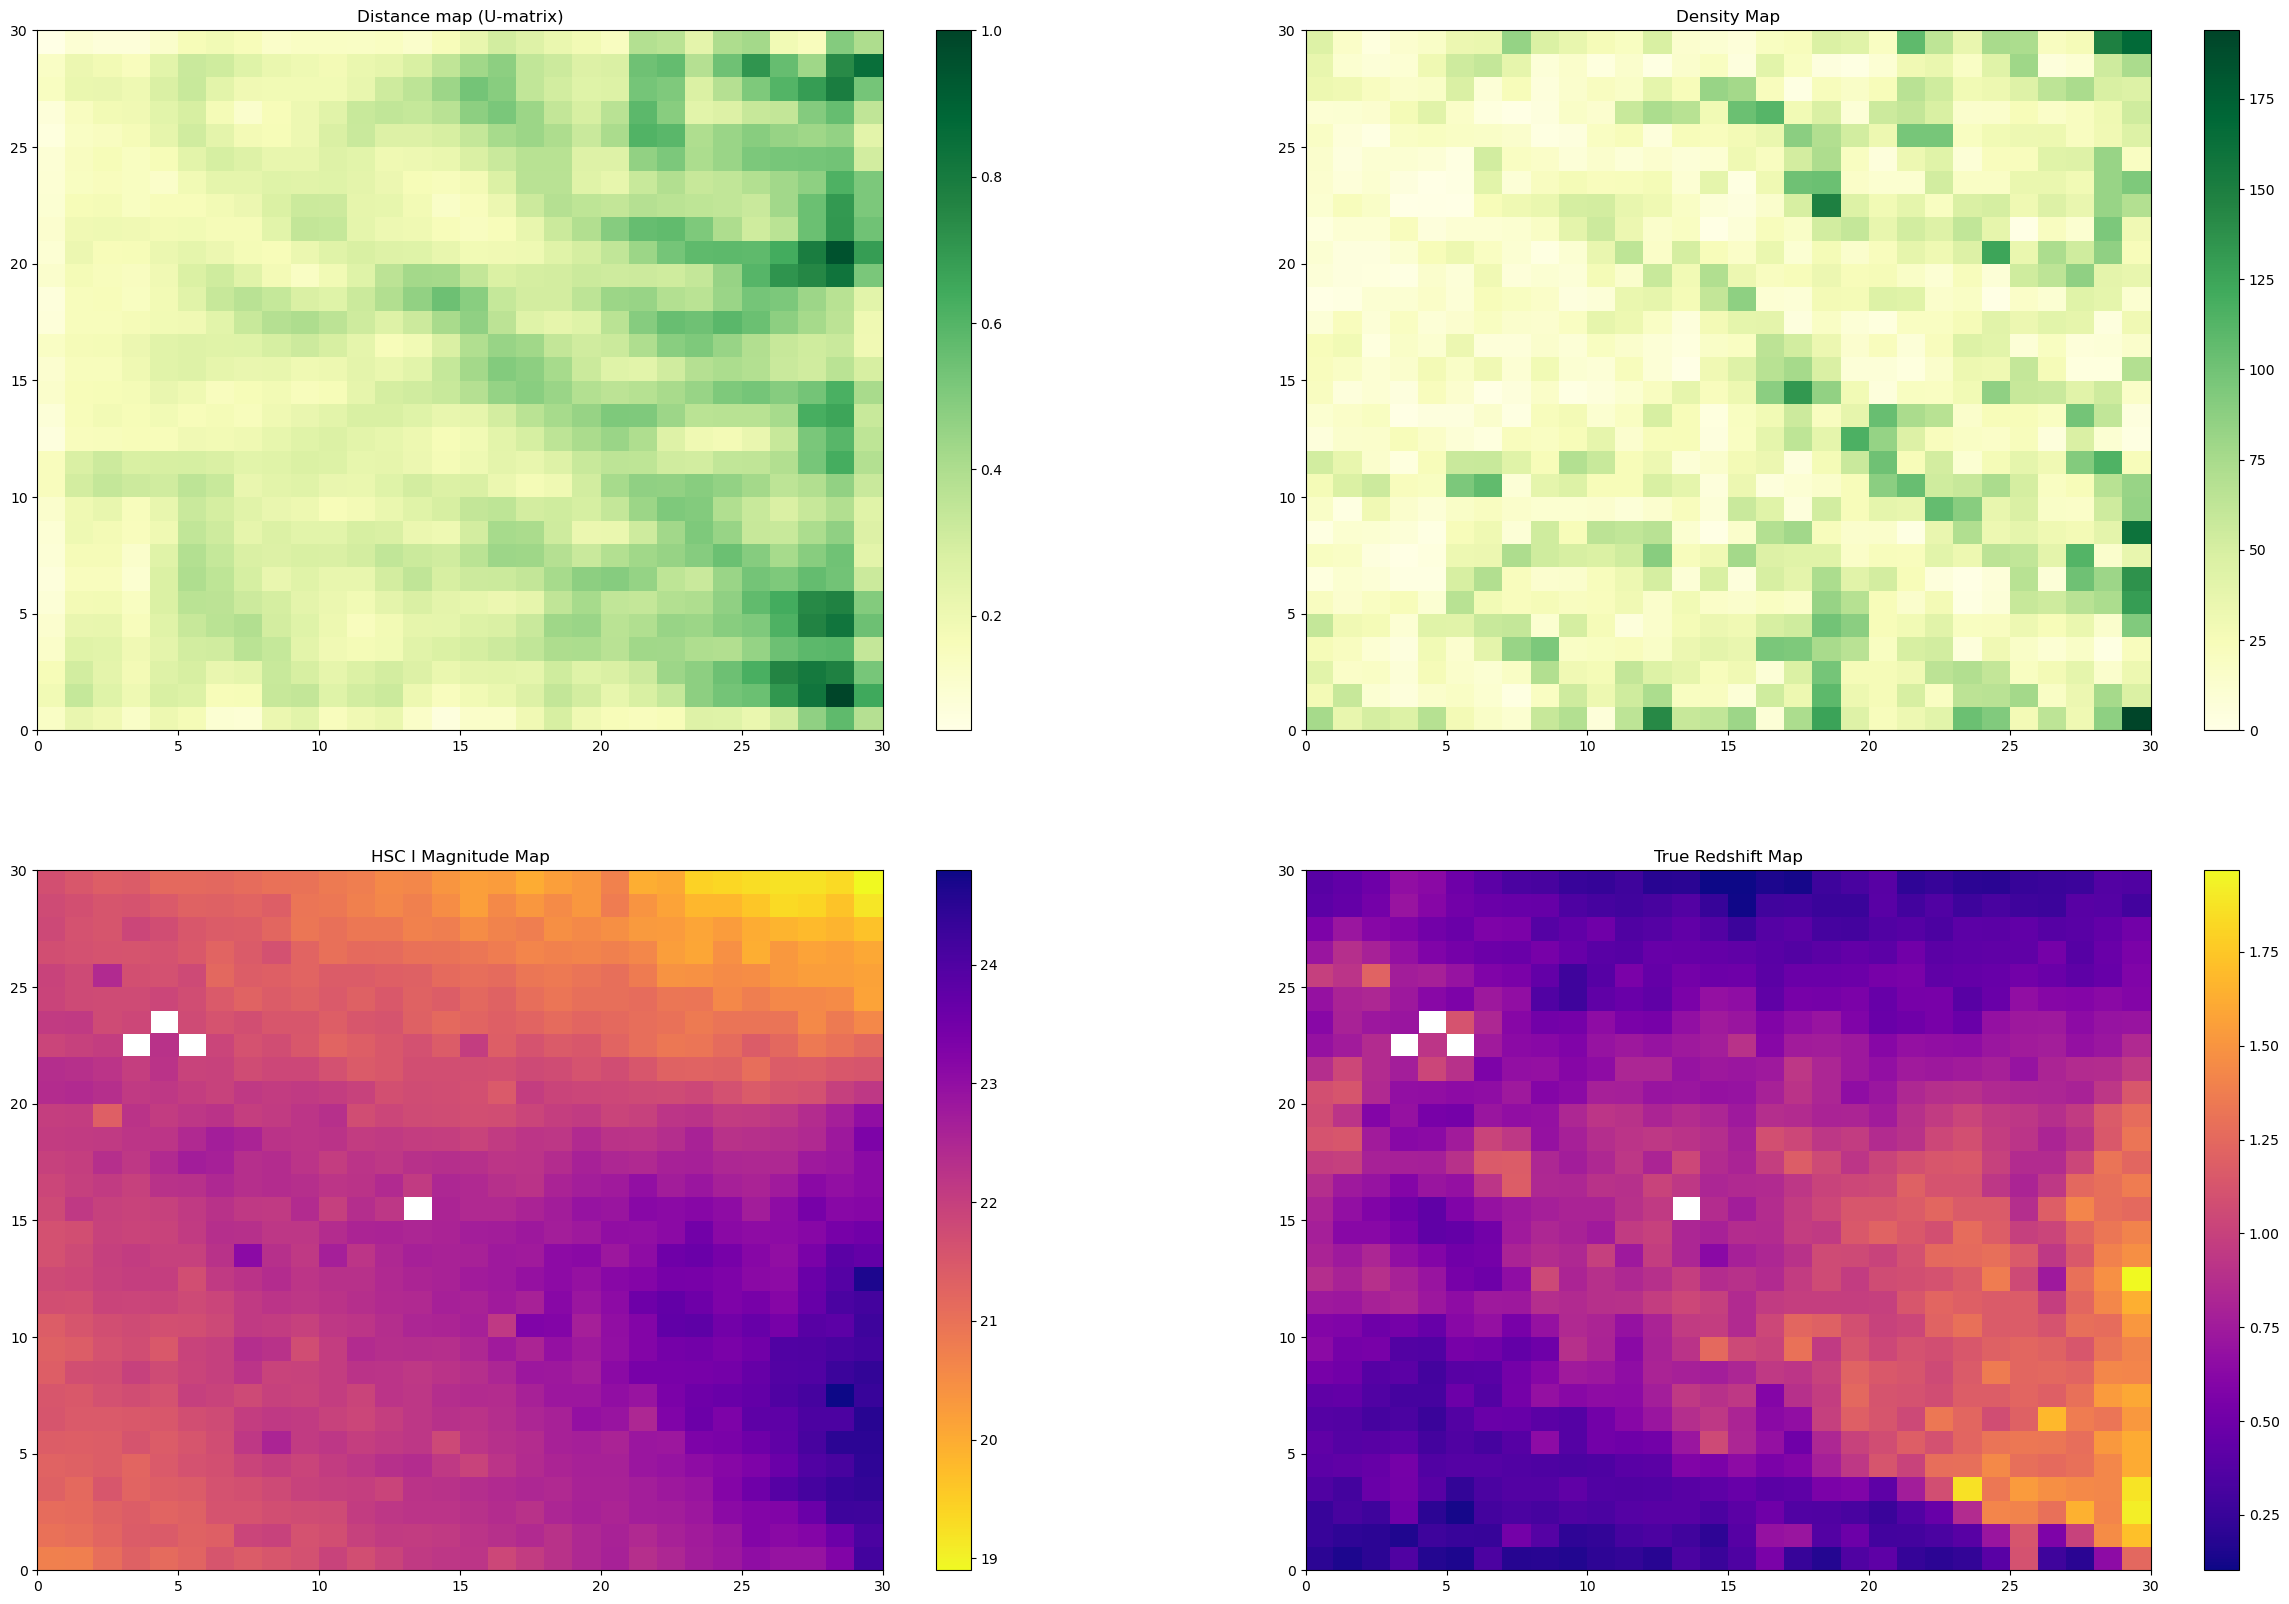

Topological error: 0.25630832463025977
Quantization error: 0.6945014423049178
Topological error: 0.25630832463025977
Quantization error: 0.6945014423049178


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


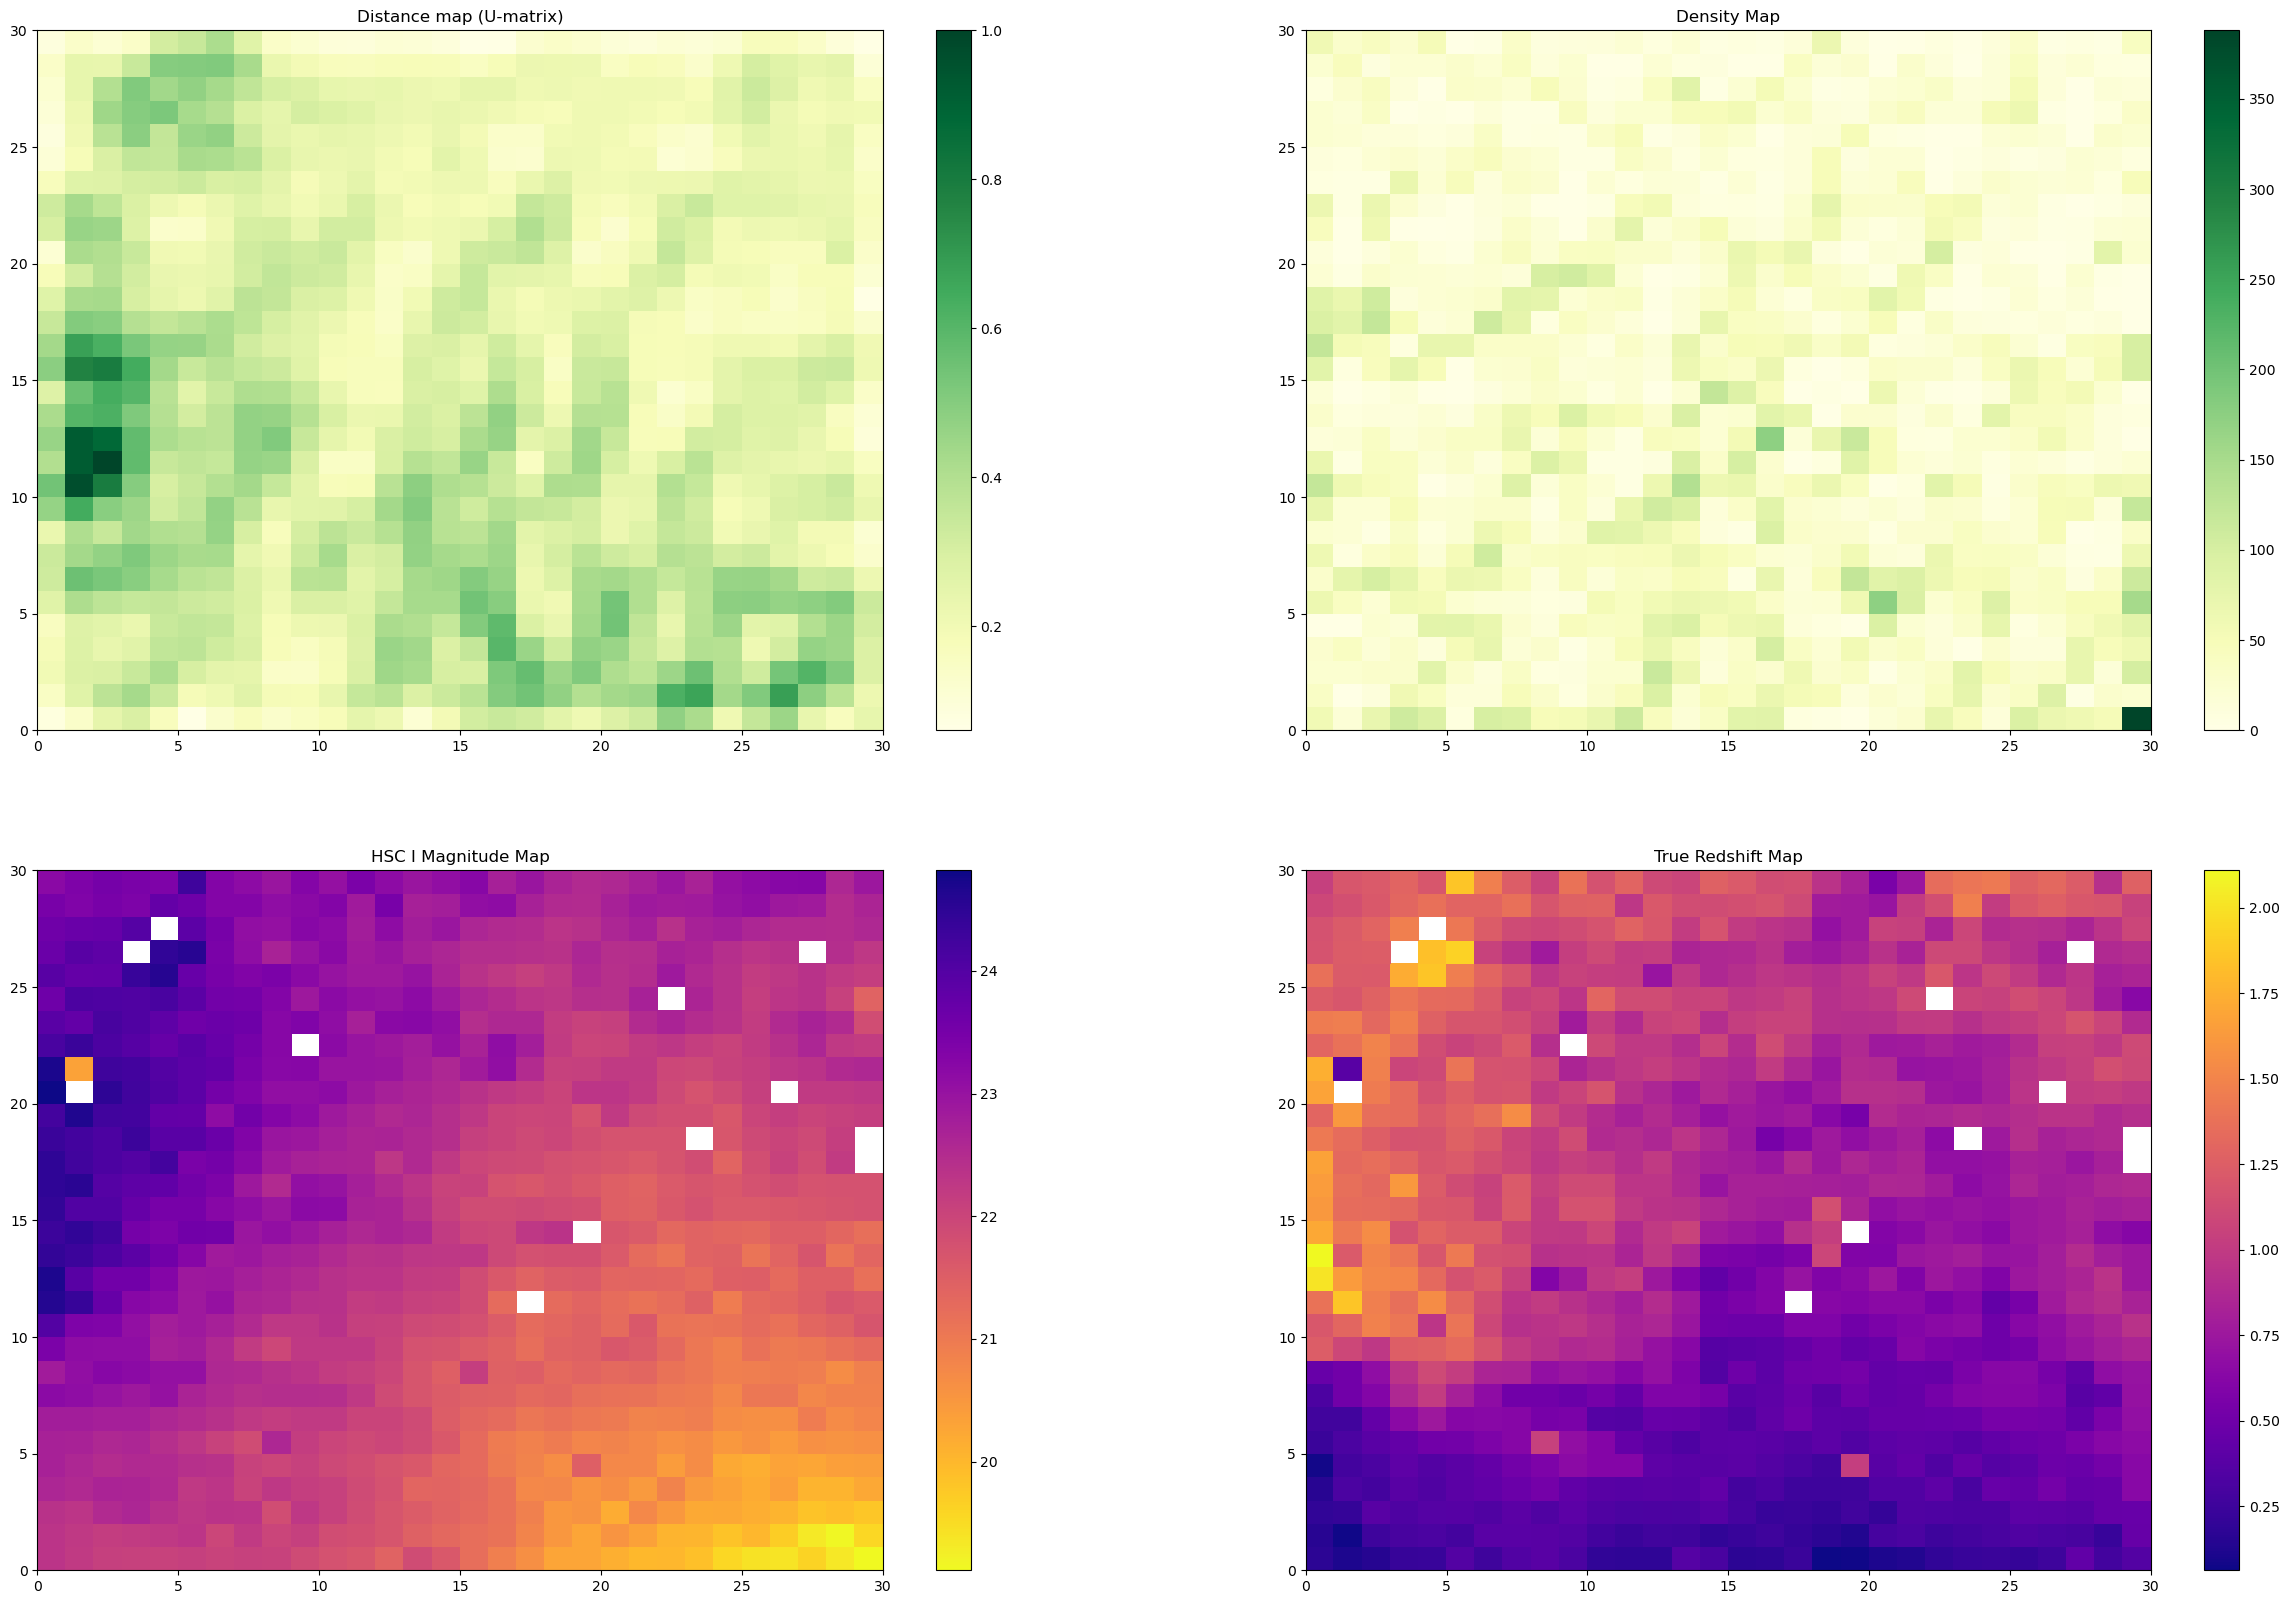

Topological error: 0.2834956035441162
Quantization error: 0.7062172479516693
Topological error: 0.2834956035441162
Quantization error: 0.7062172479516693


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


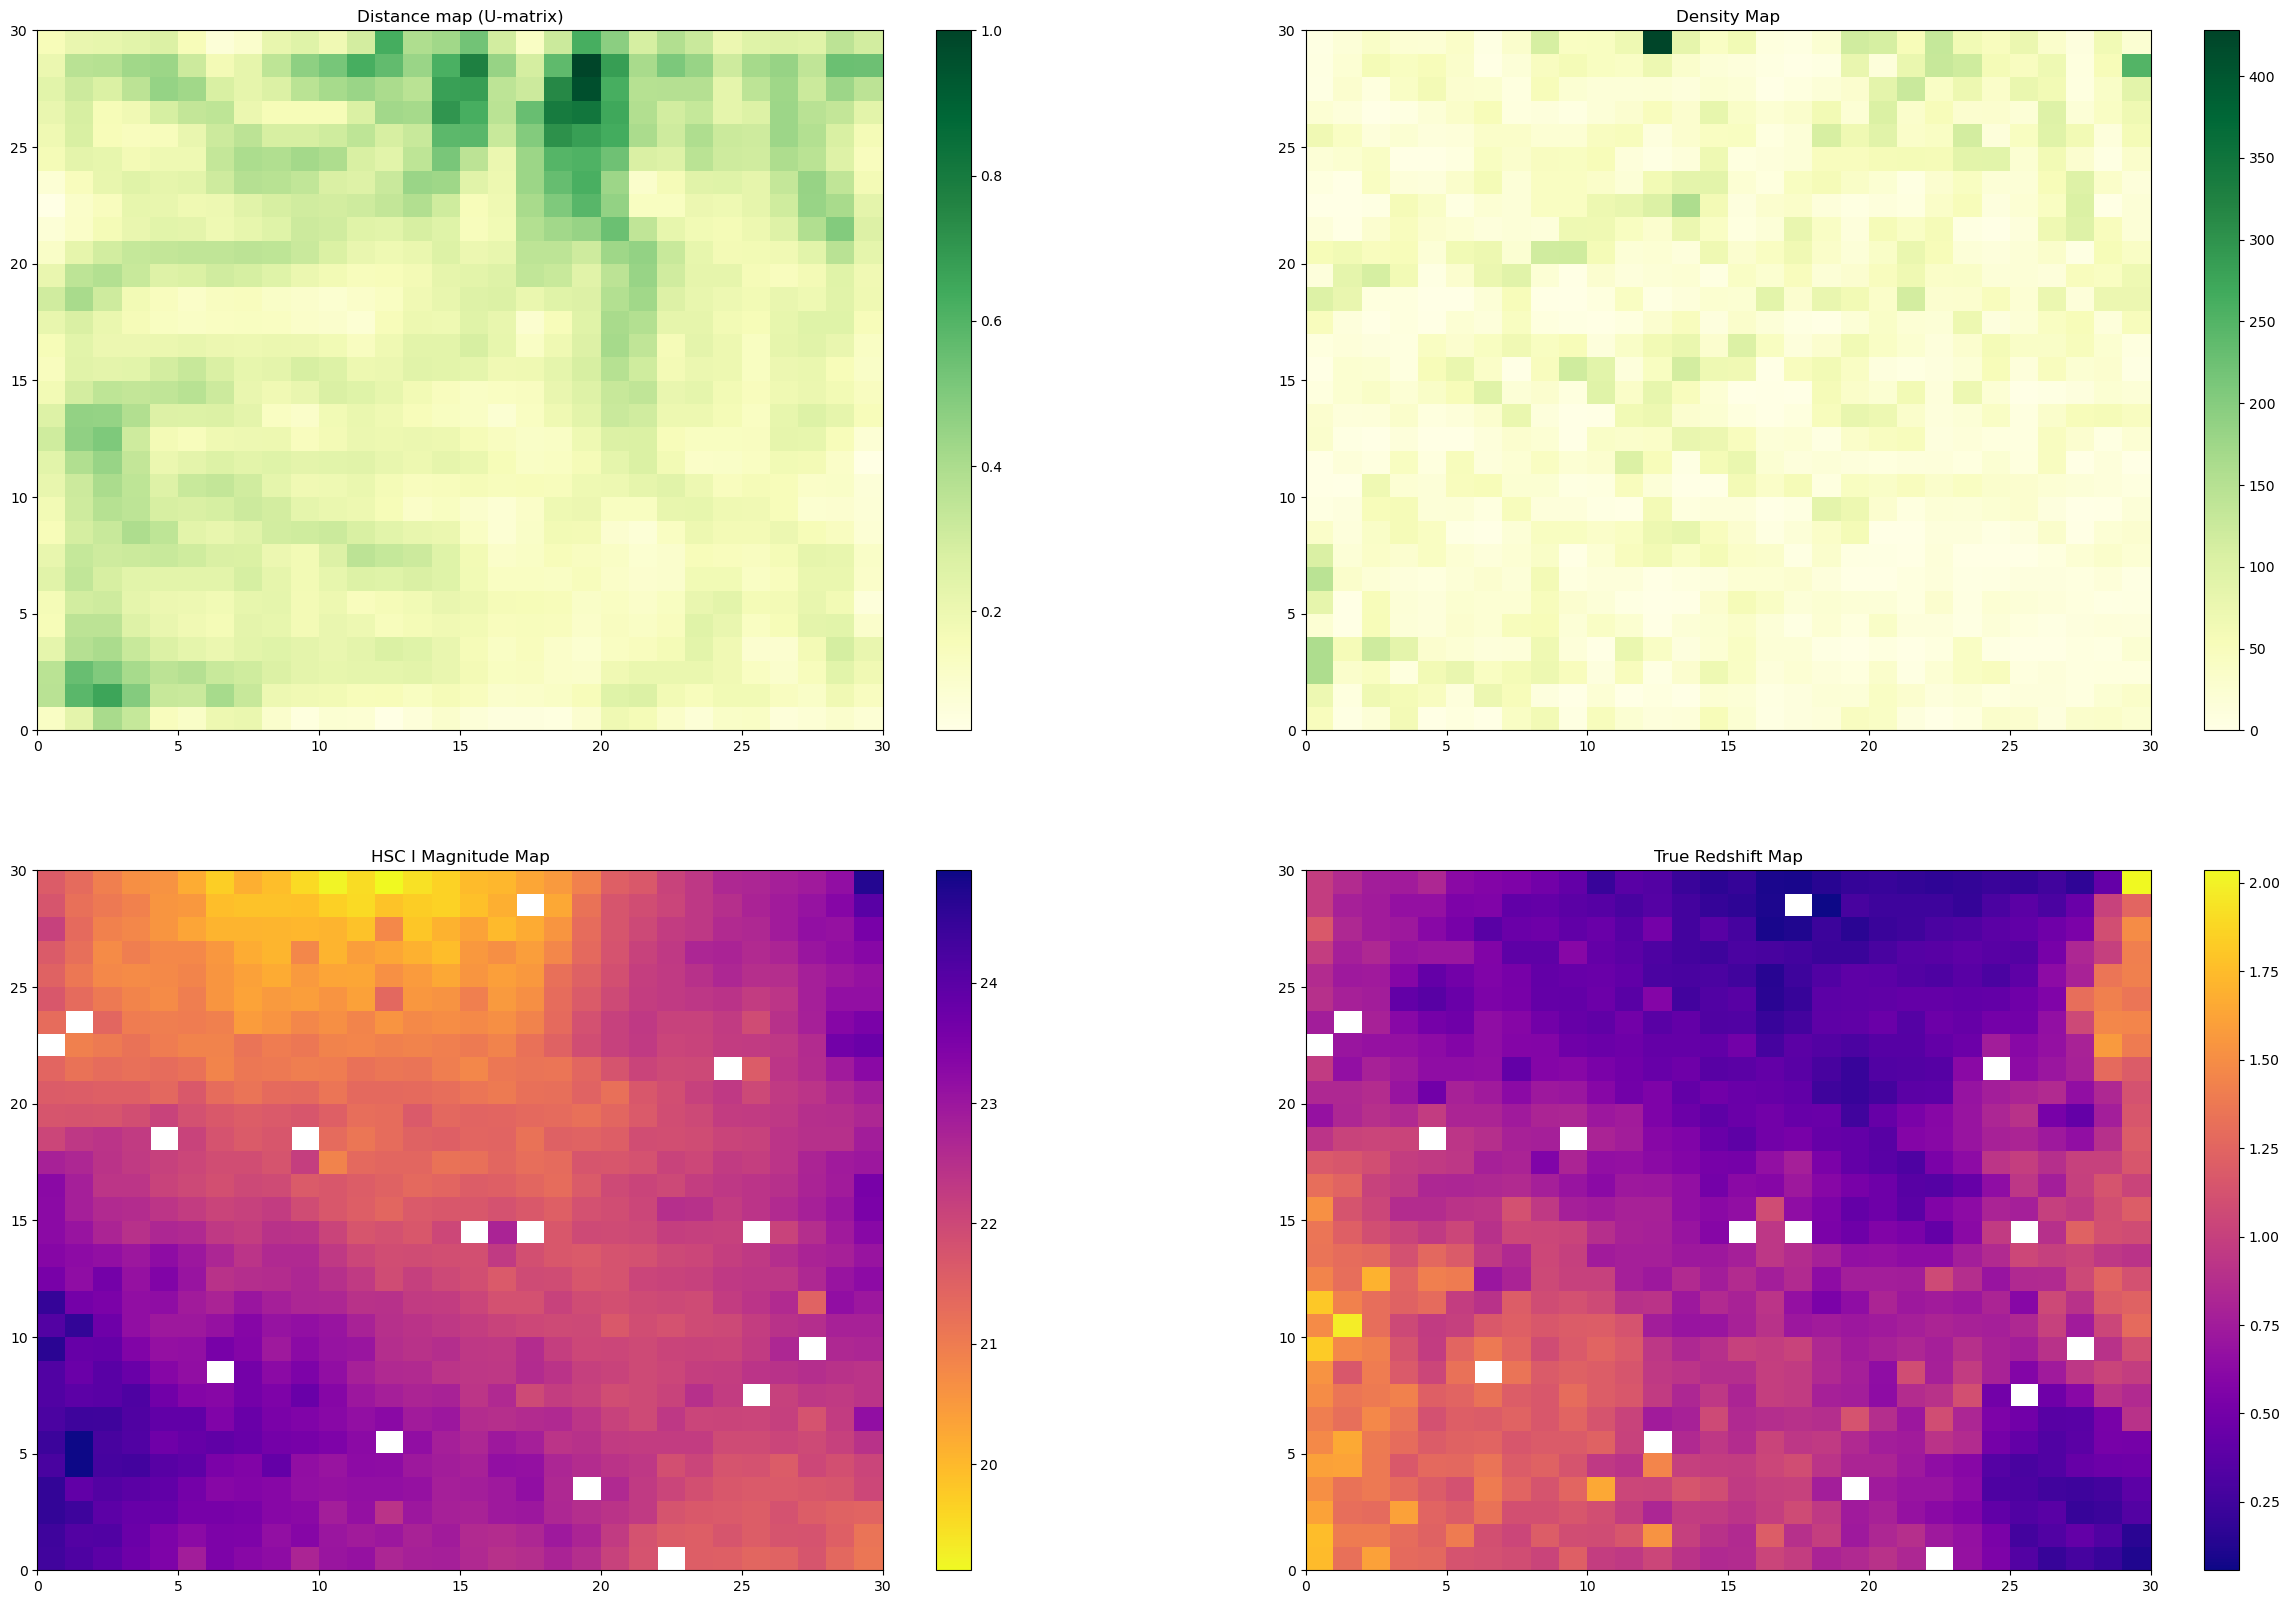

Topological error: 0.27406259475120437
Quantization error: 0.709847252088879
Topological error: 0.27406259475120437
Quantization error: 0.709847252088879


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


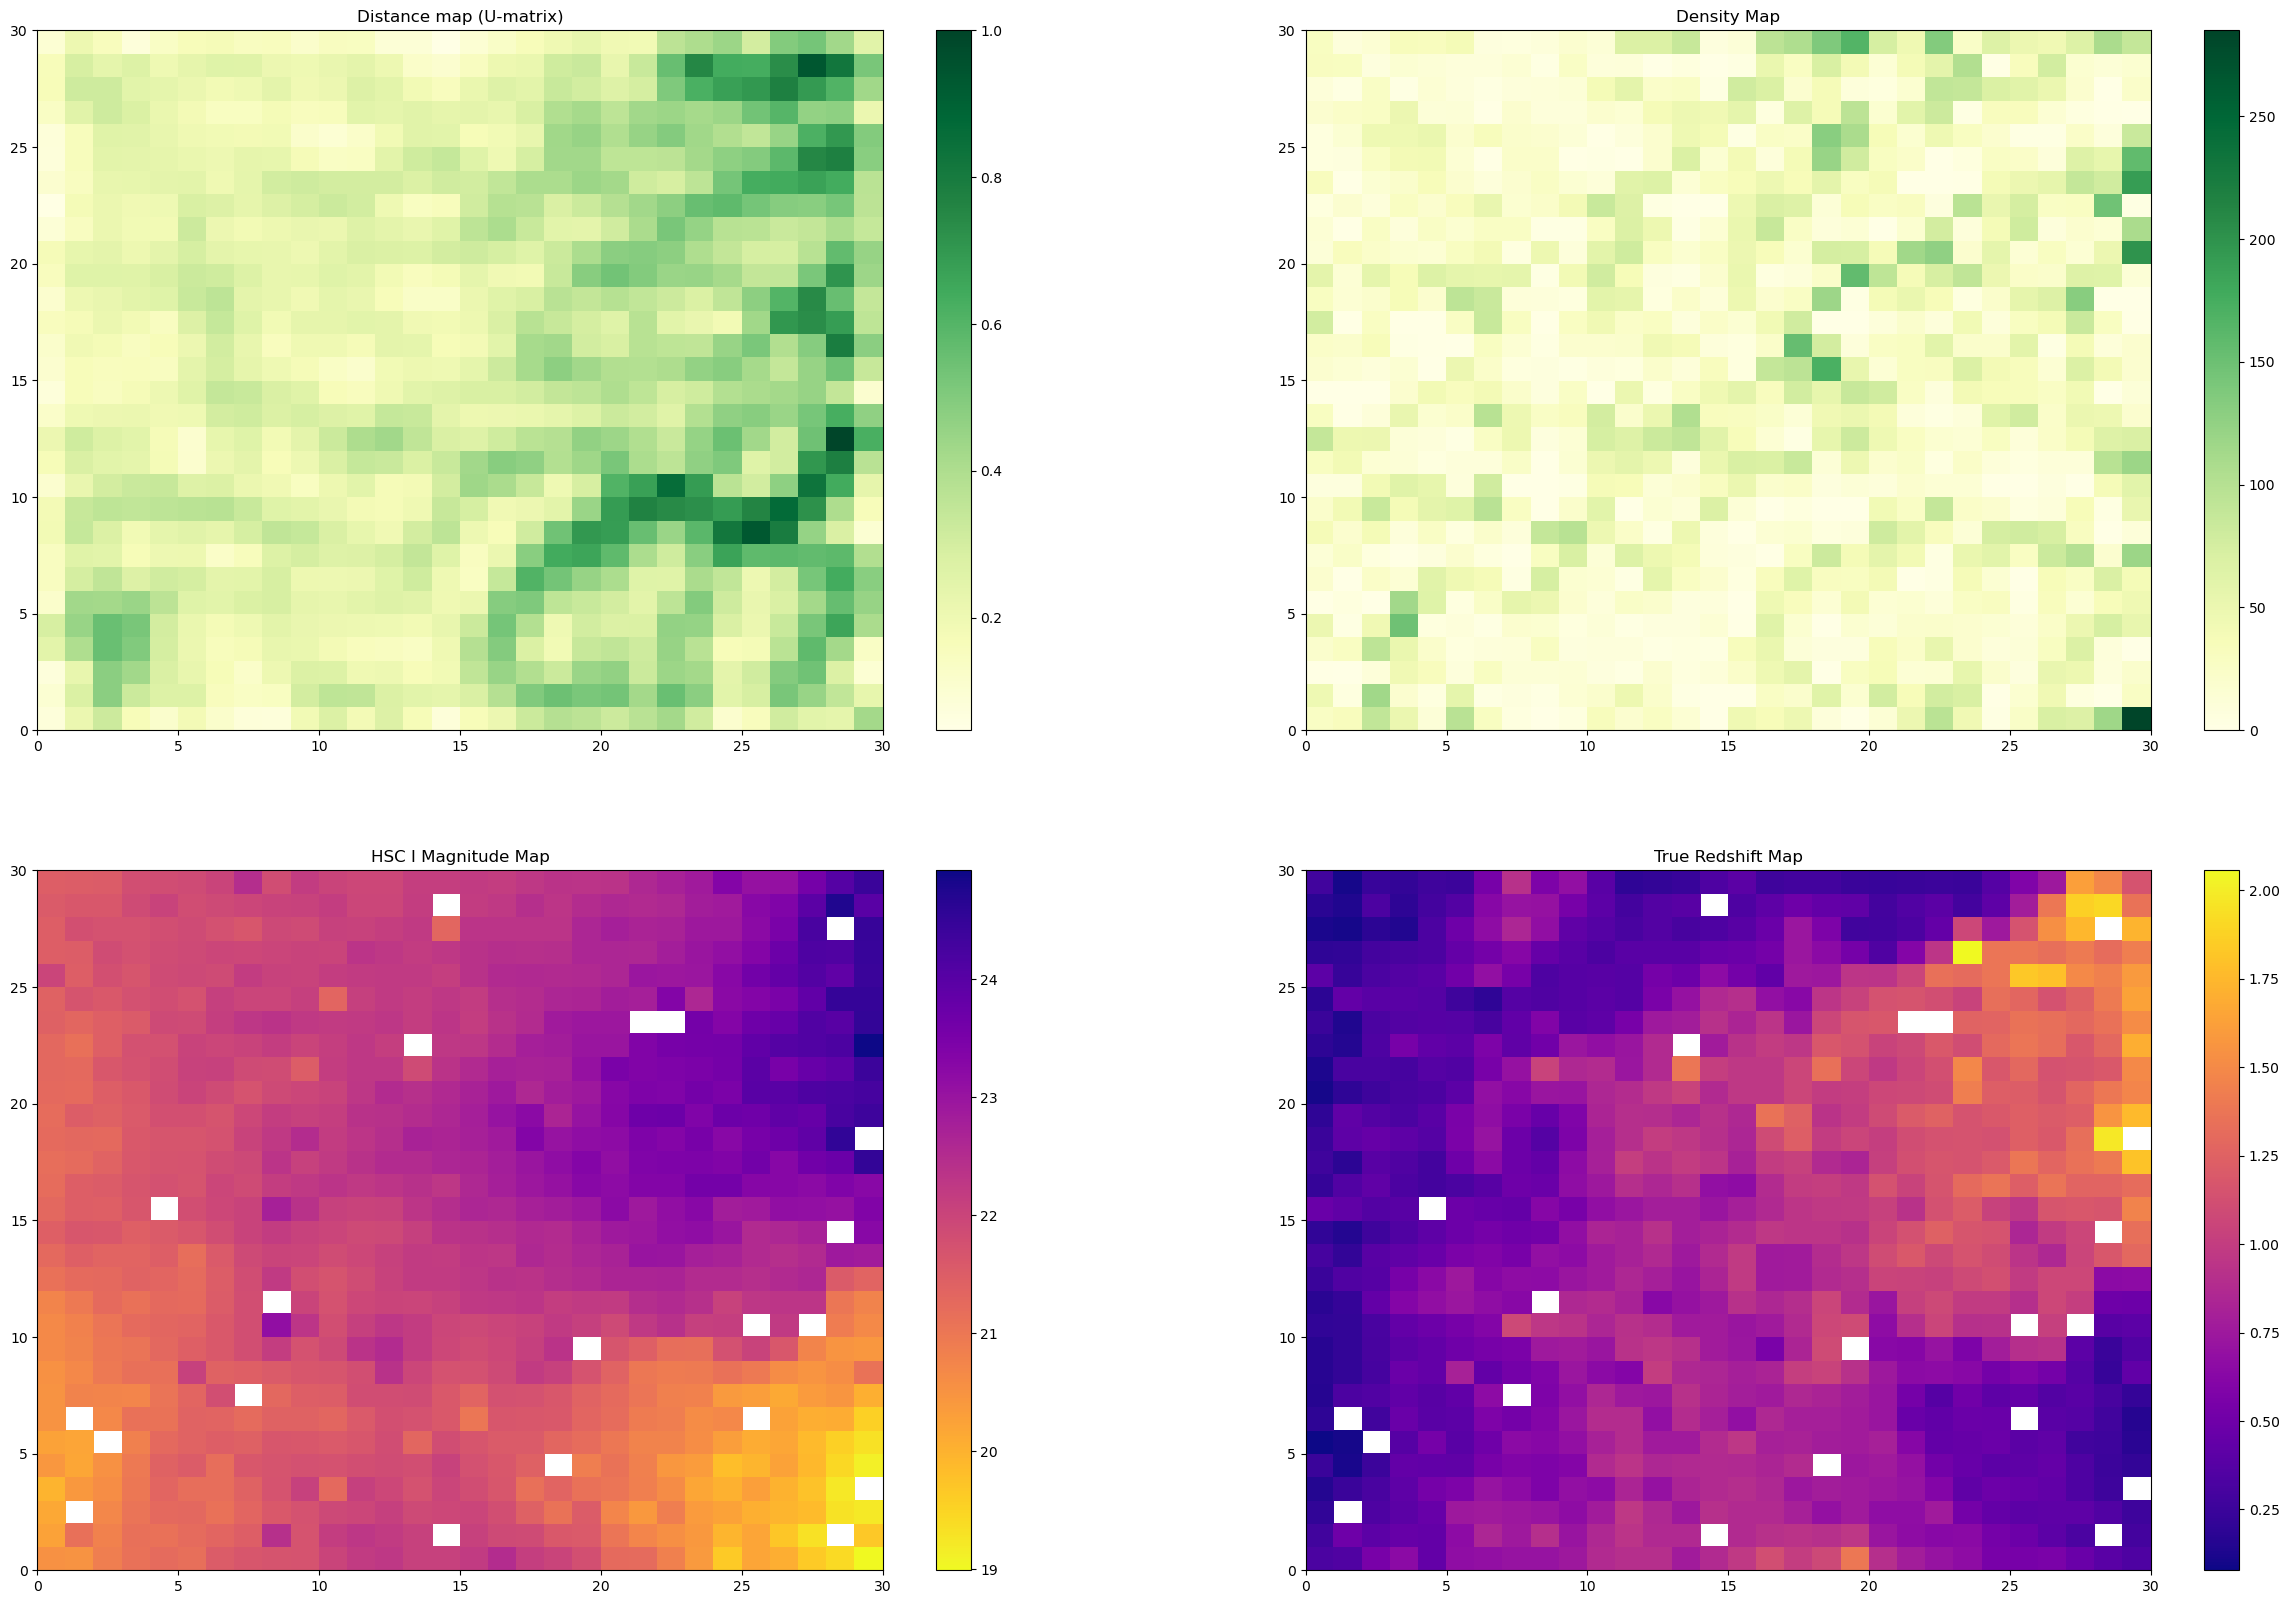

Topological error: 0.3452481218205707
Quantization error: 0.7193917585077634
Topological error: 0.3452481218205707
Quantization error: 0.7193917585077634


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


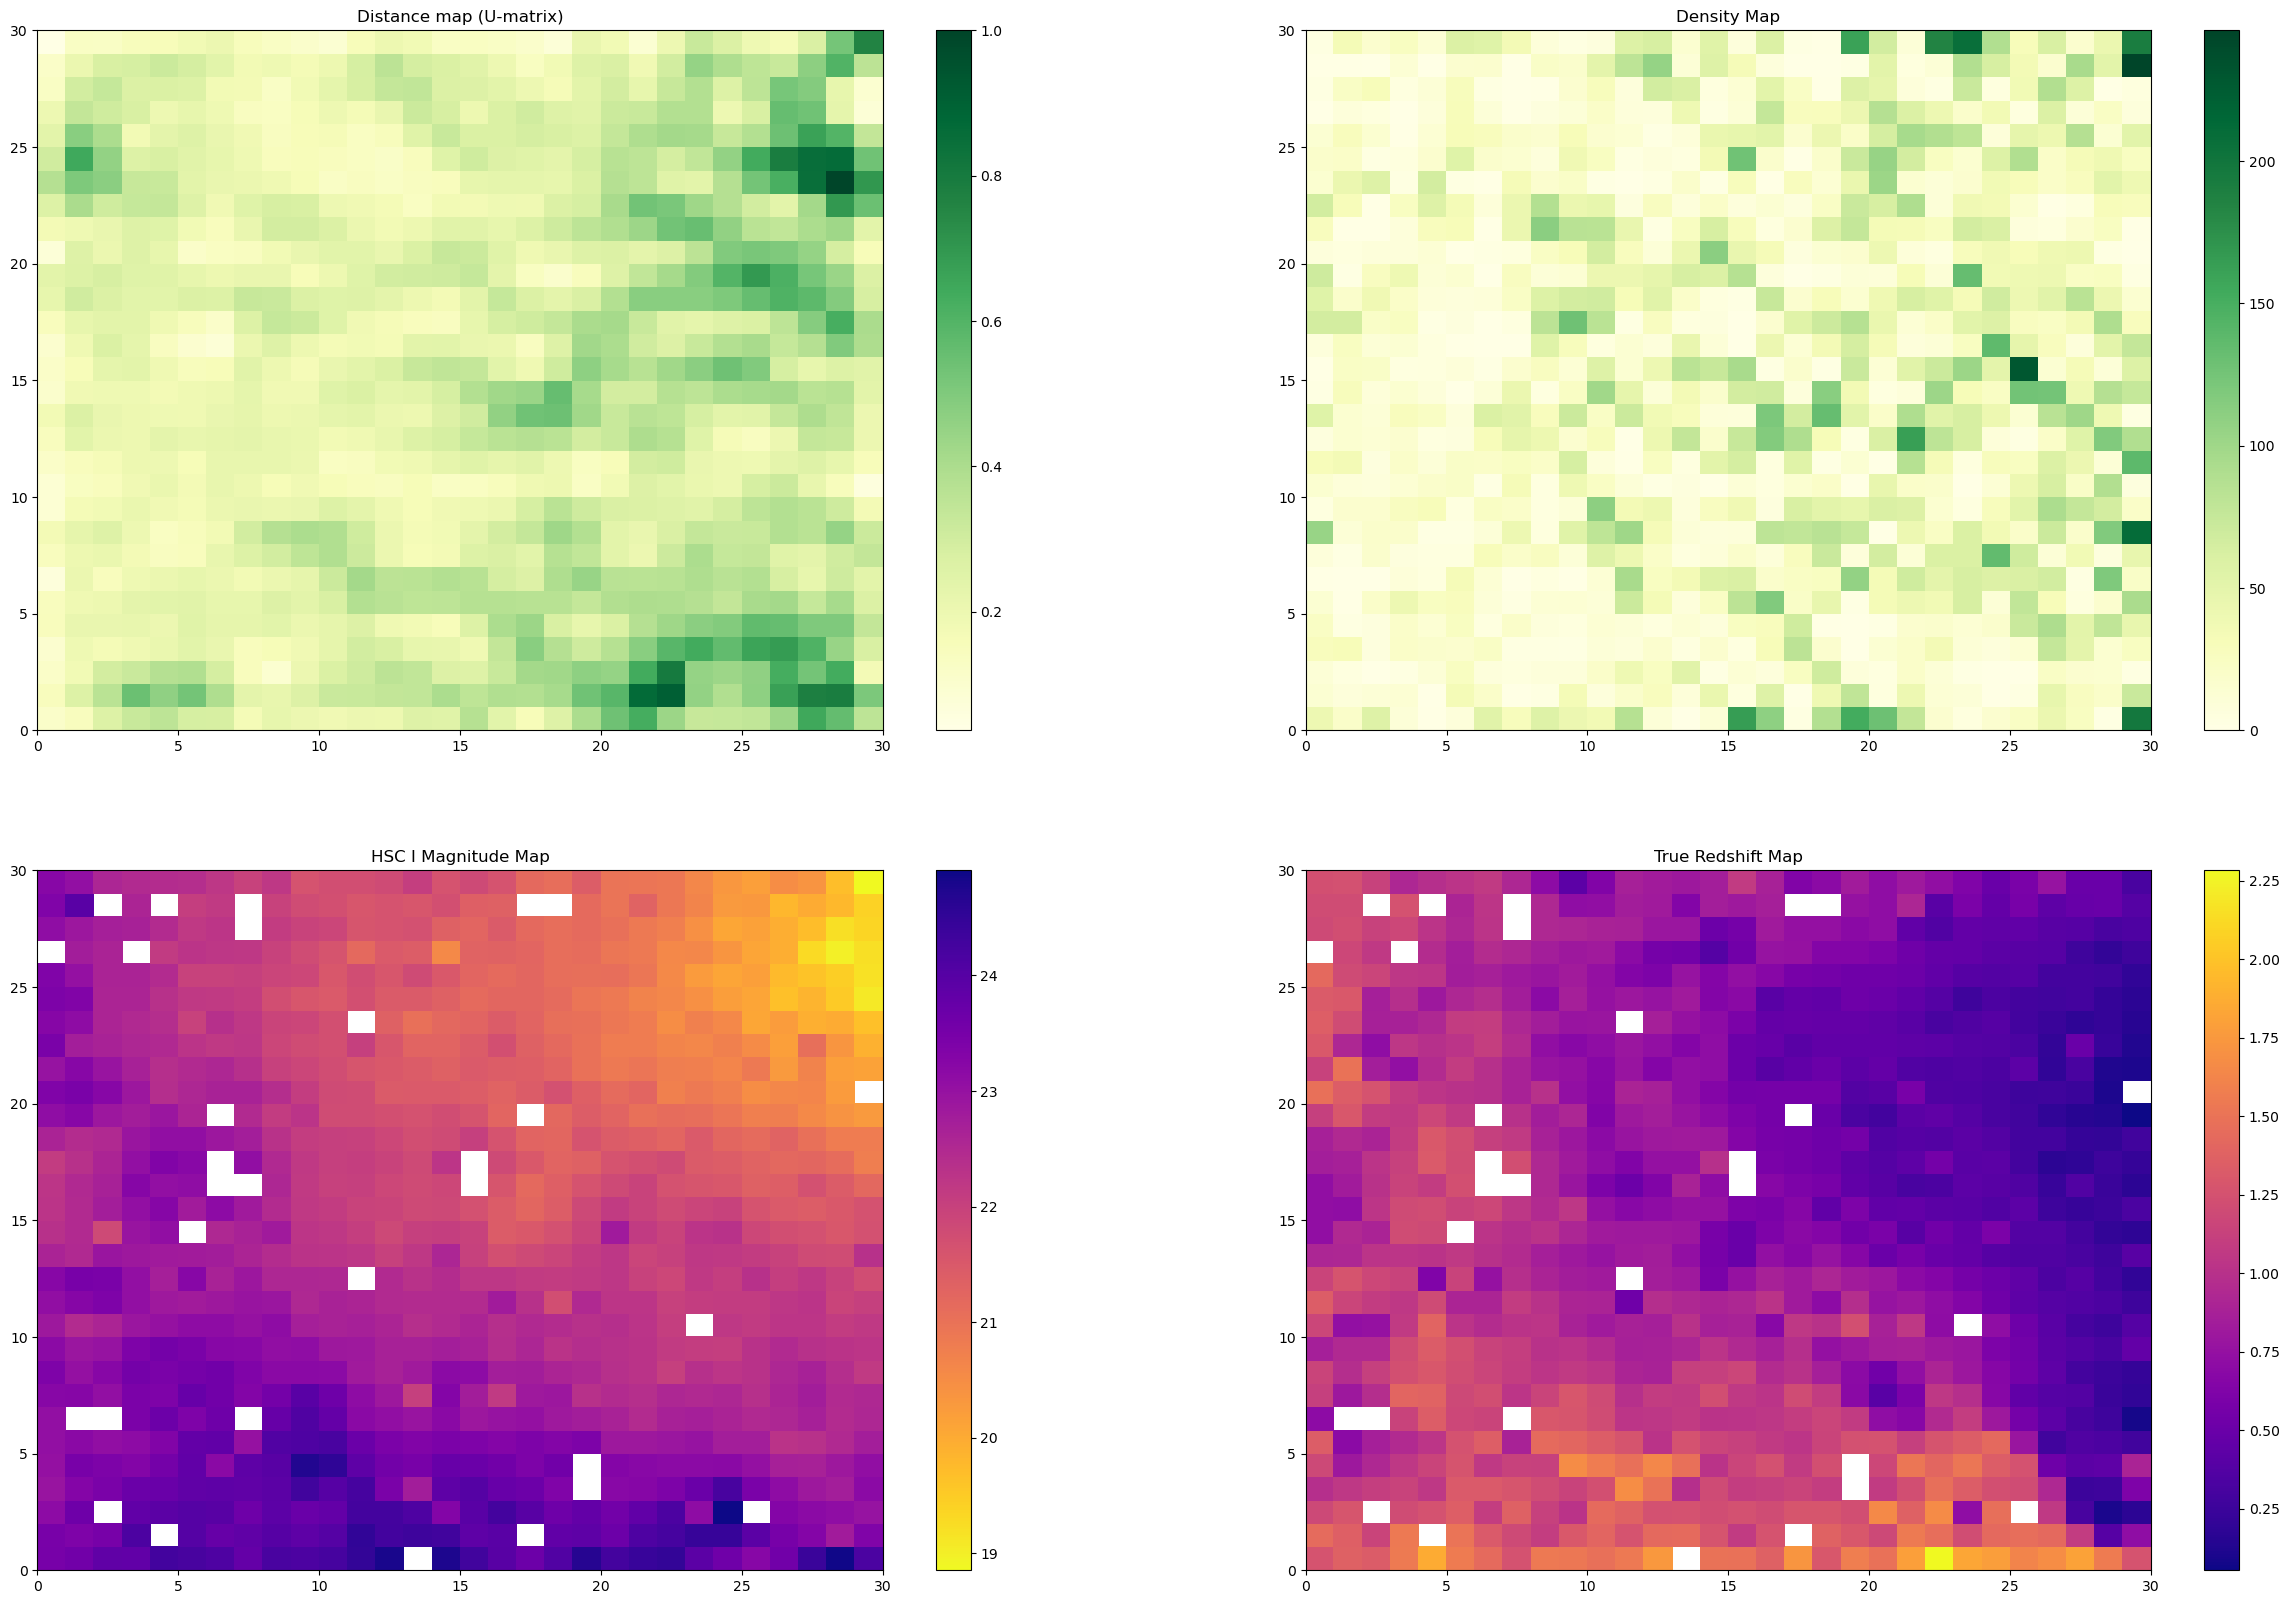

Topological error: 0.37145841053801837
Quantization error: 0.7159070187057318
Topological error: 0.37145841053801837
Quantization error: 0.7159070187057318


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


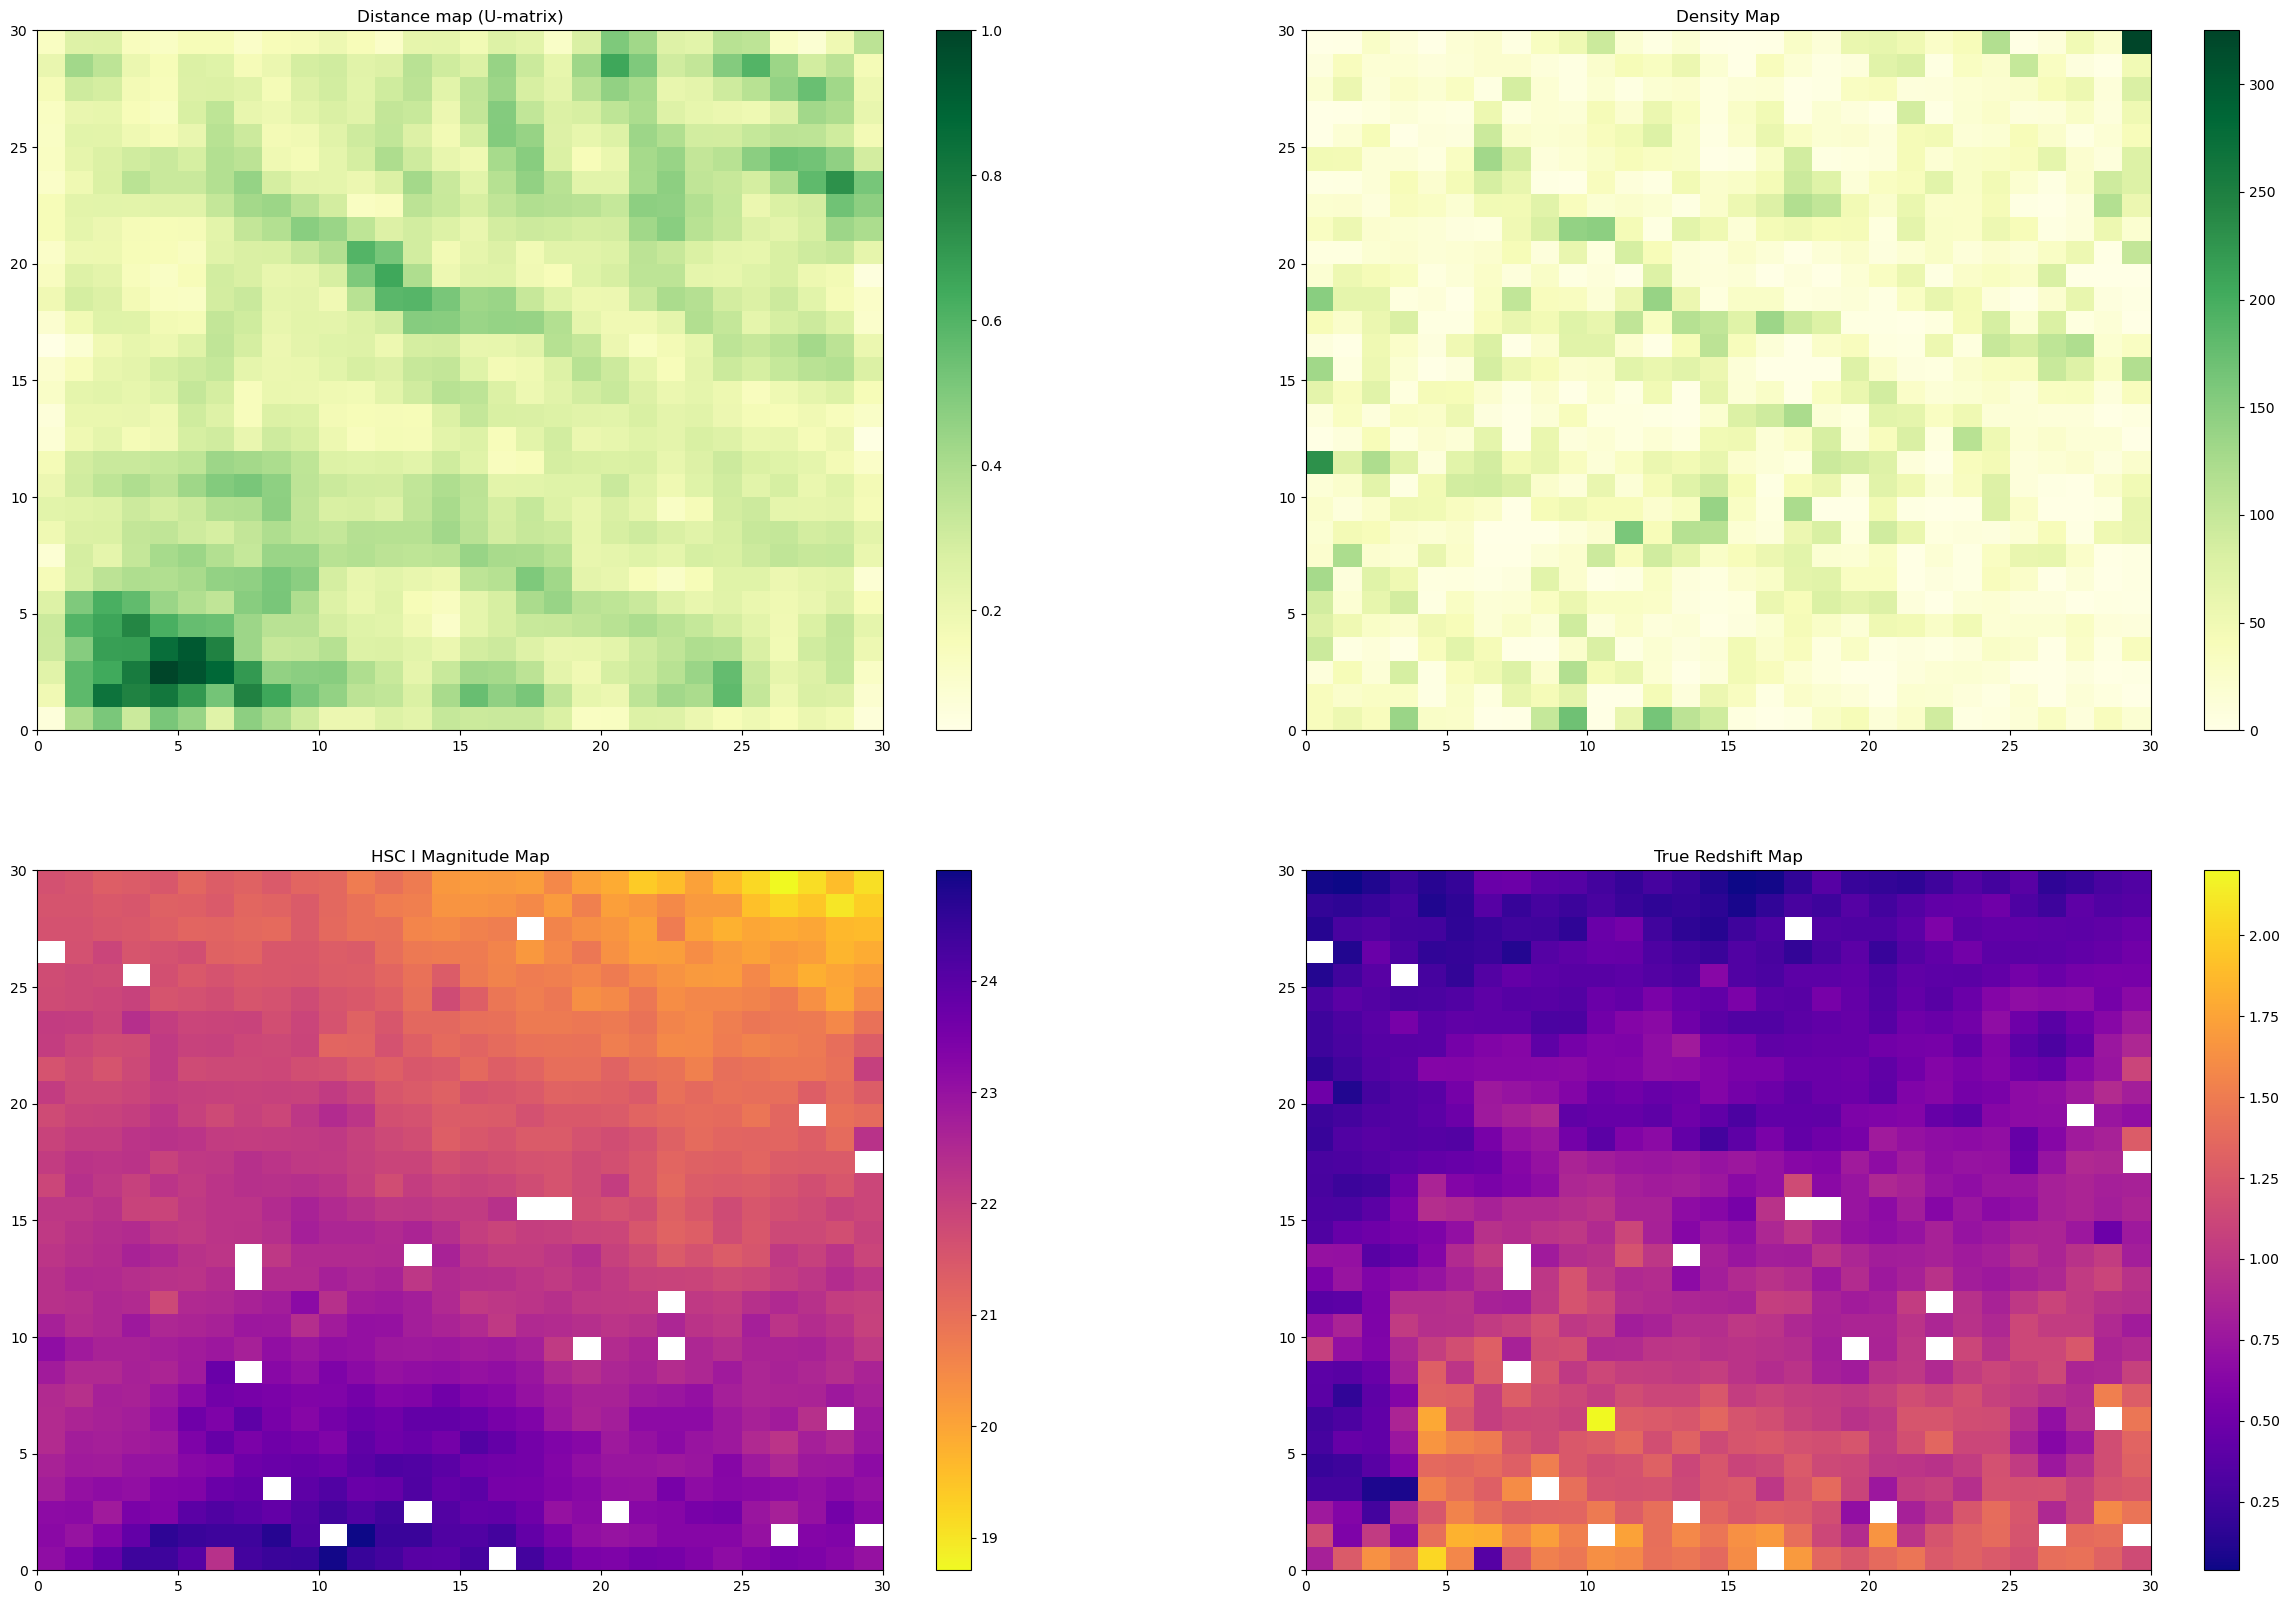

Topological error: 0.3837550112859212
Quantization error: 0.7255809557243424
Topological error: 0.3837550112859212
Quantization error: 0.7255809557243424


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


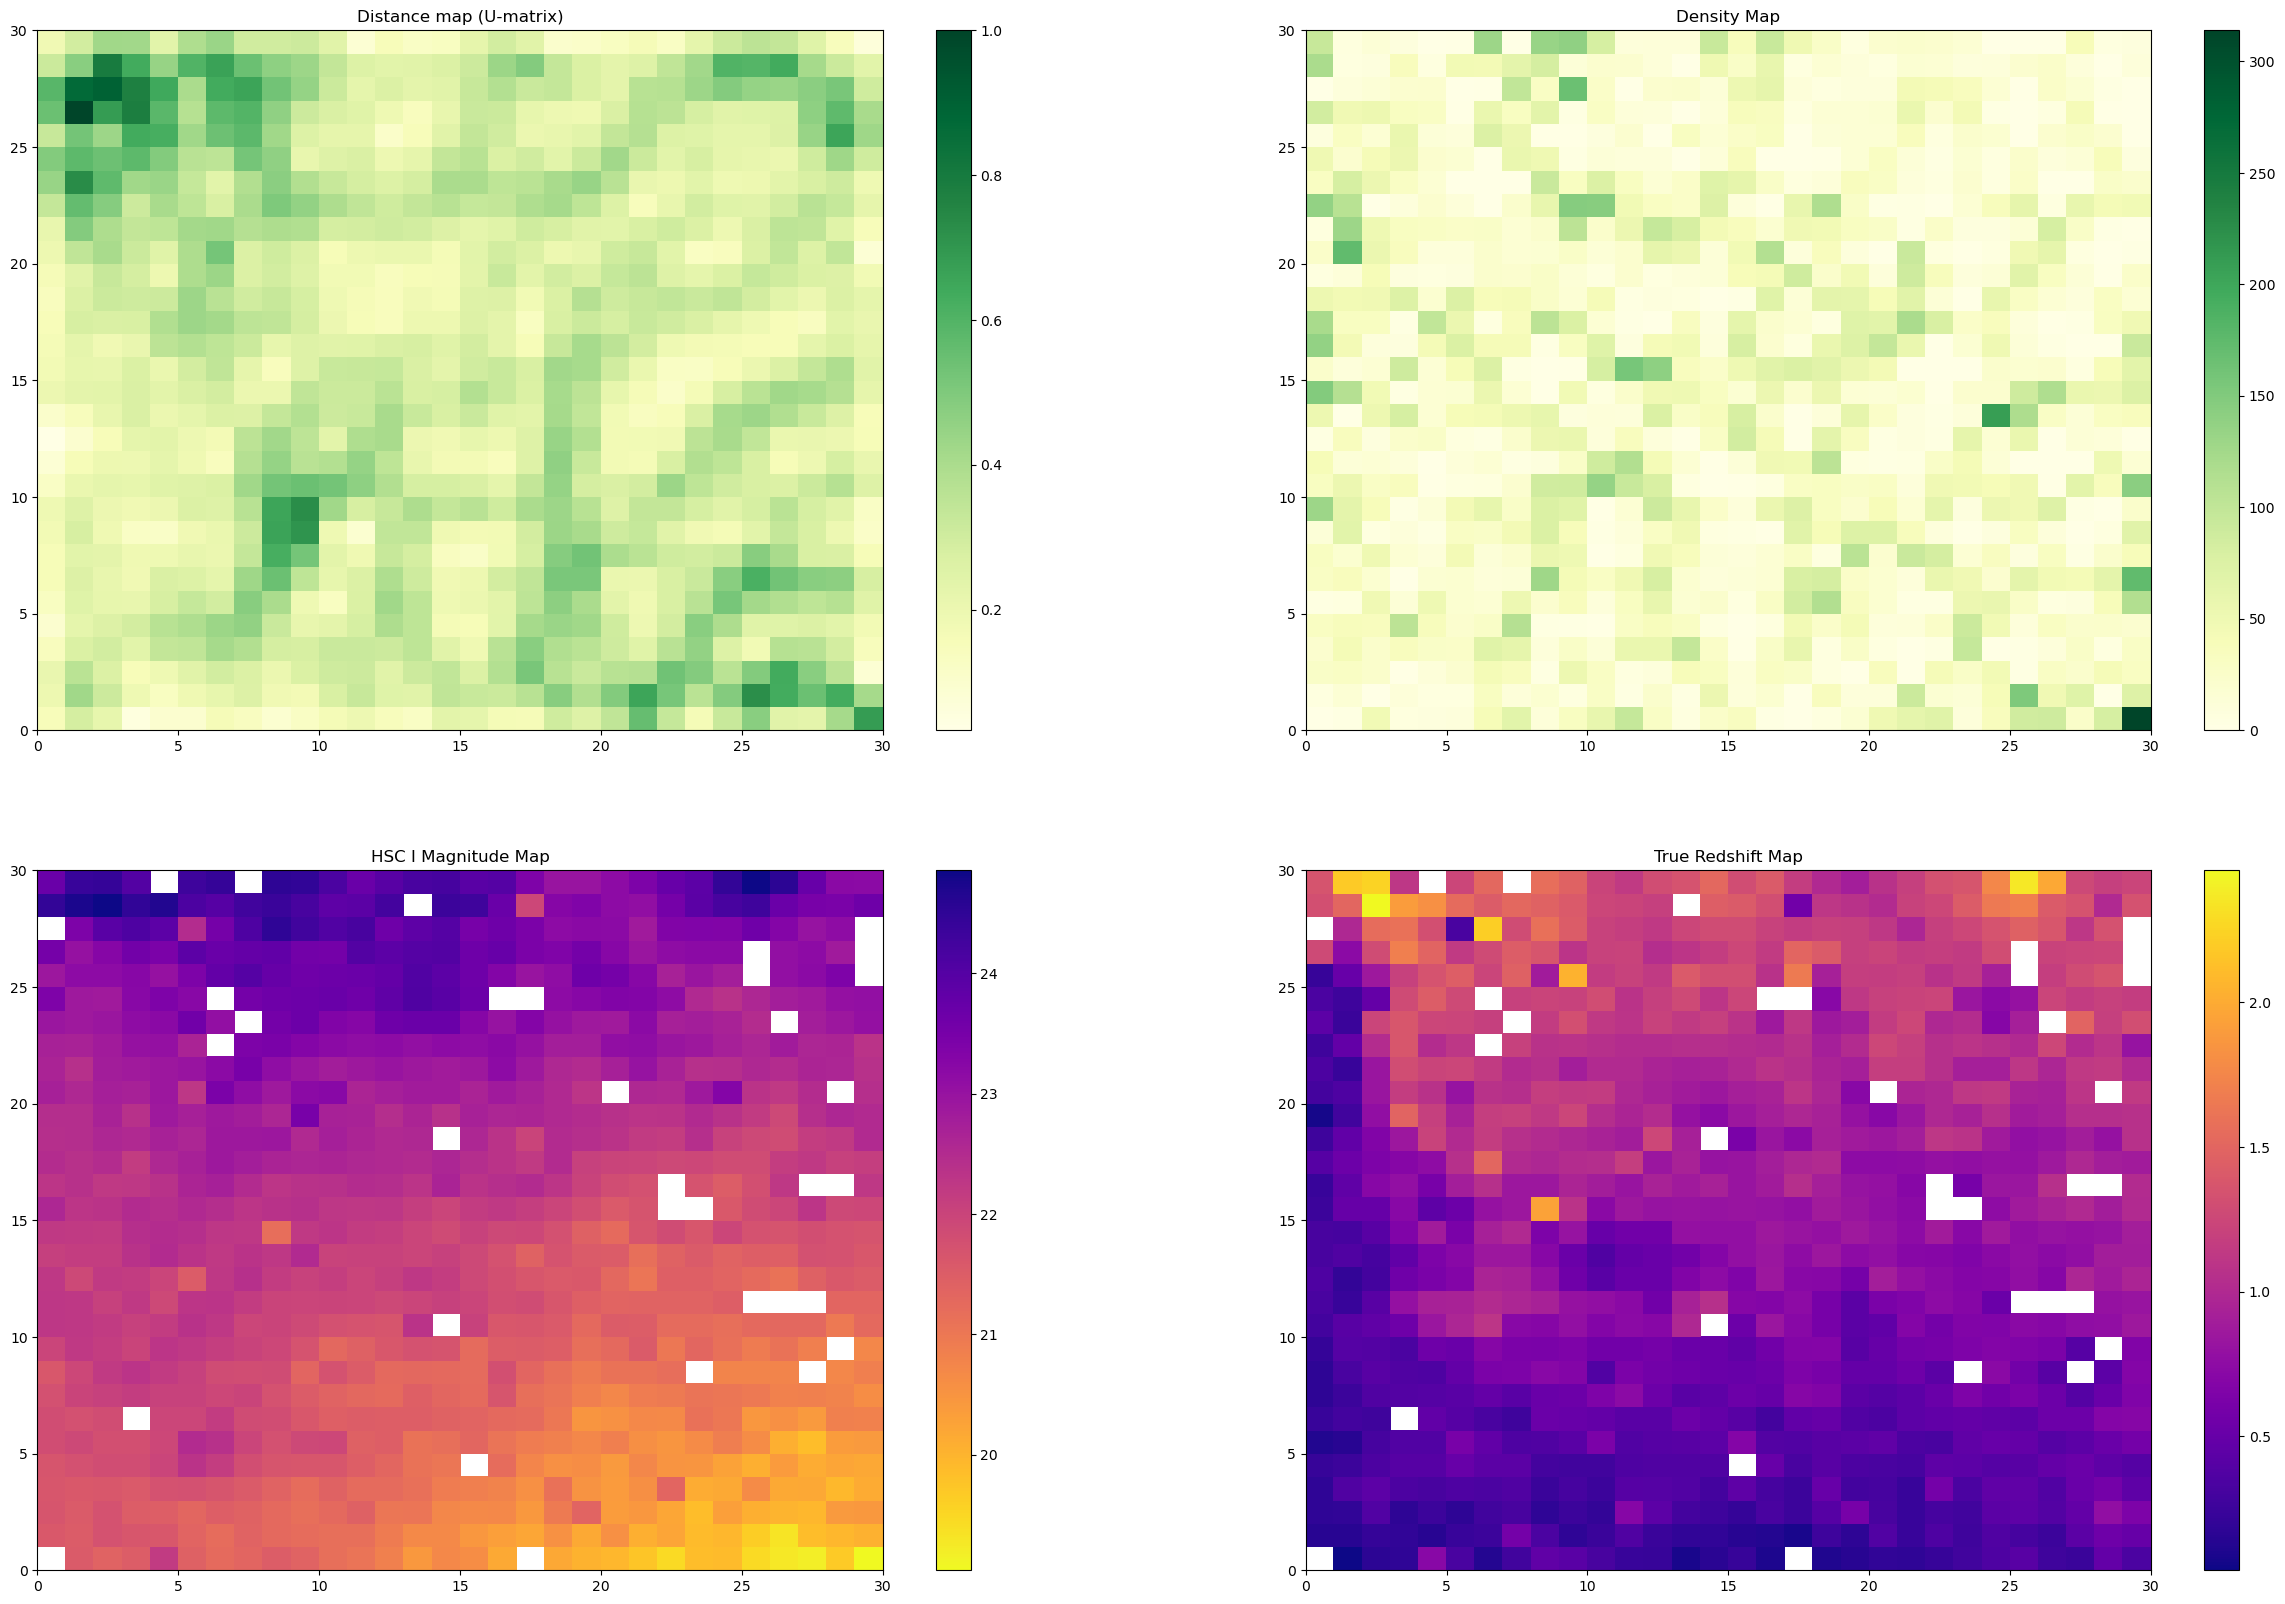

Topological error: 0.44712461678401777
Quantization error: 0.7313024532426197
Topological error: 0.44712461678401777
Quantization error: 0.7313024532426197


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


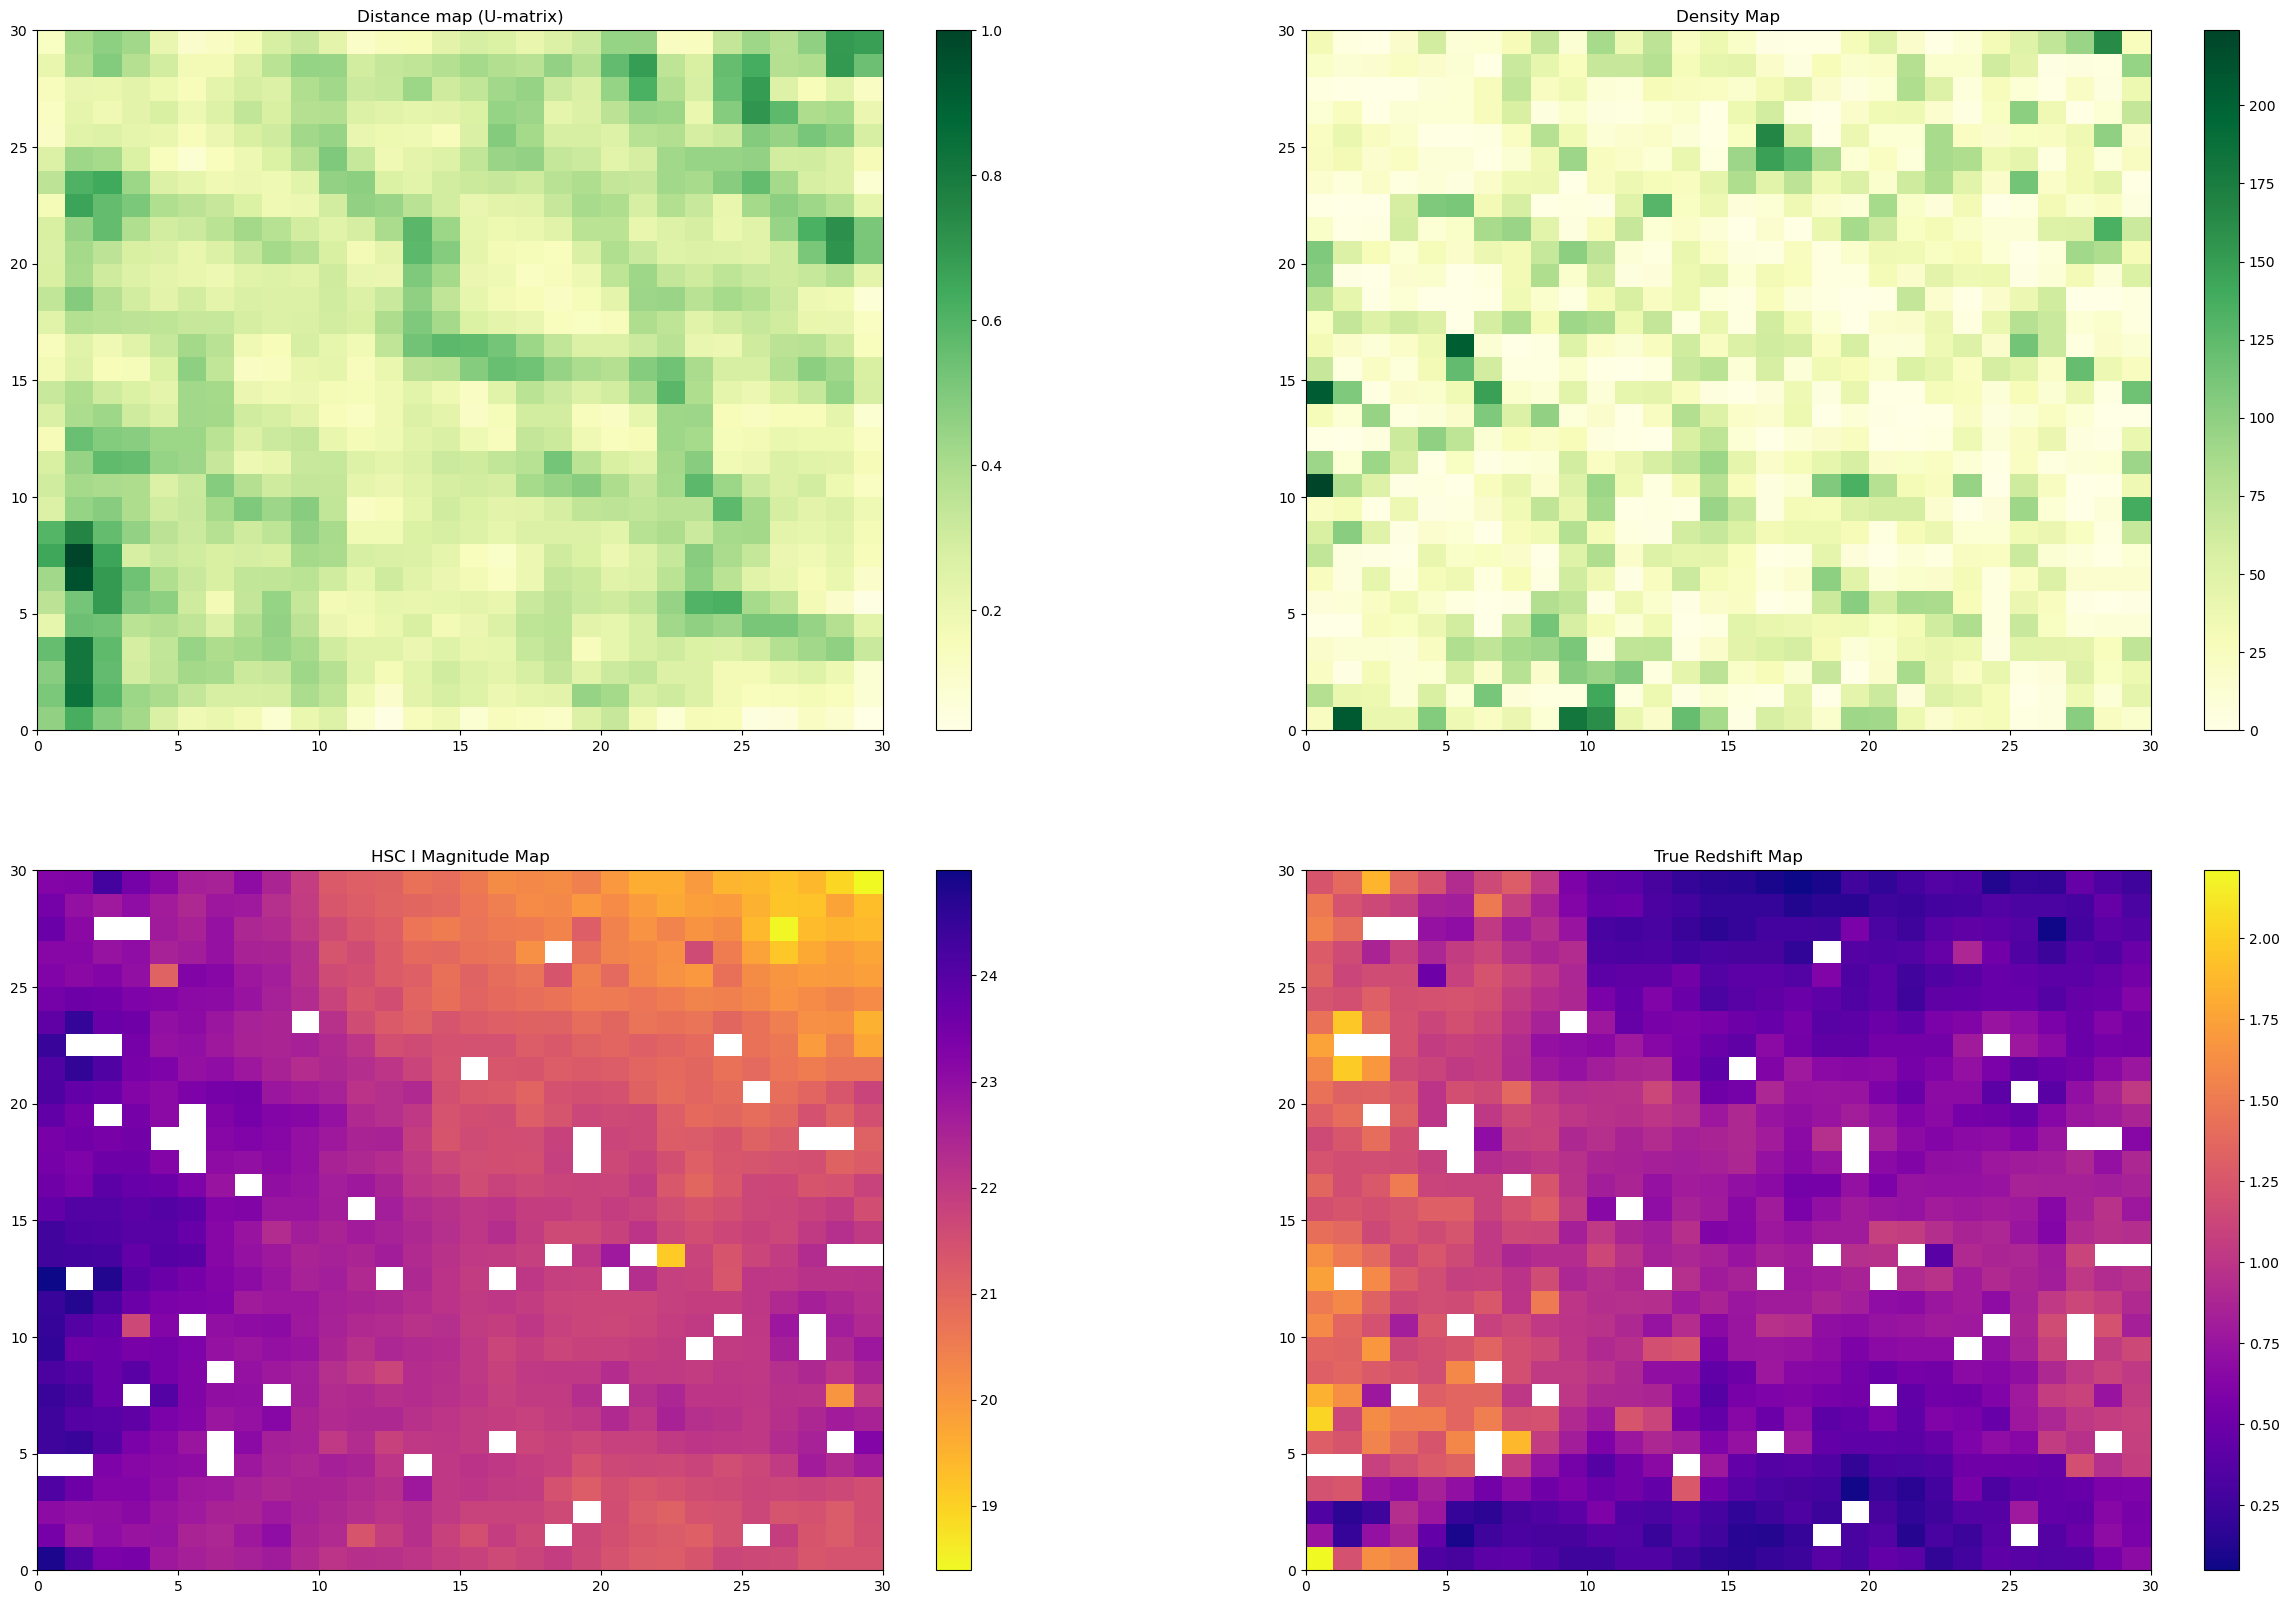

Topological error: 0.48323956473402285
Quantization error: 0.7124037894682916
Topological error: 0.48323956473402285
Quantization error: 0.7124037894682916


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


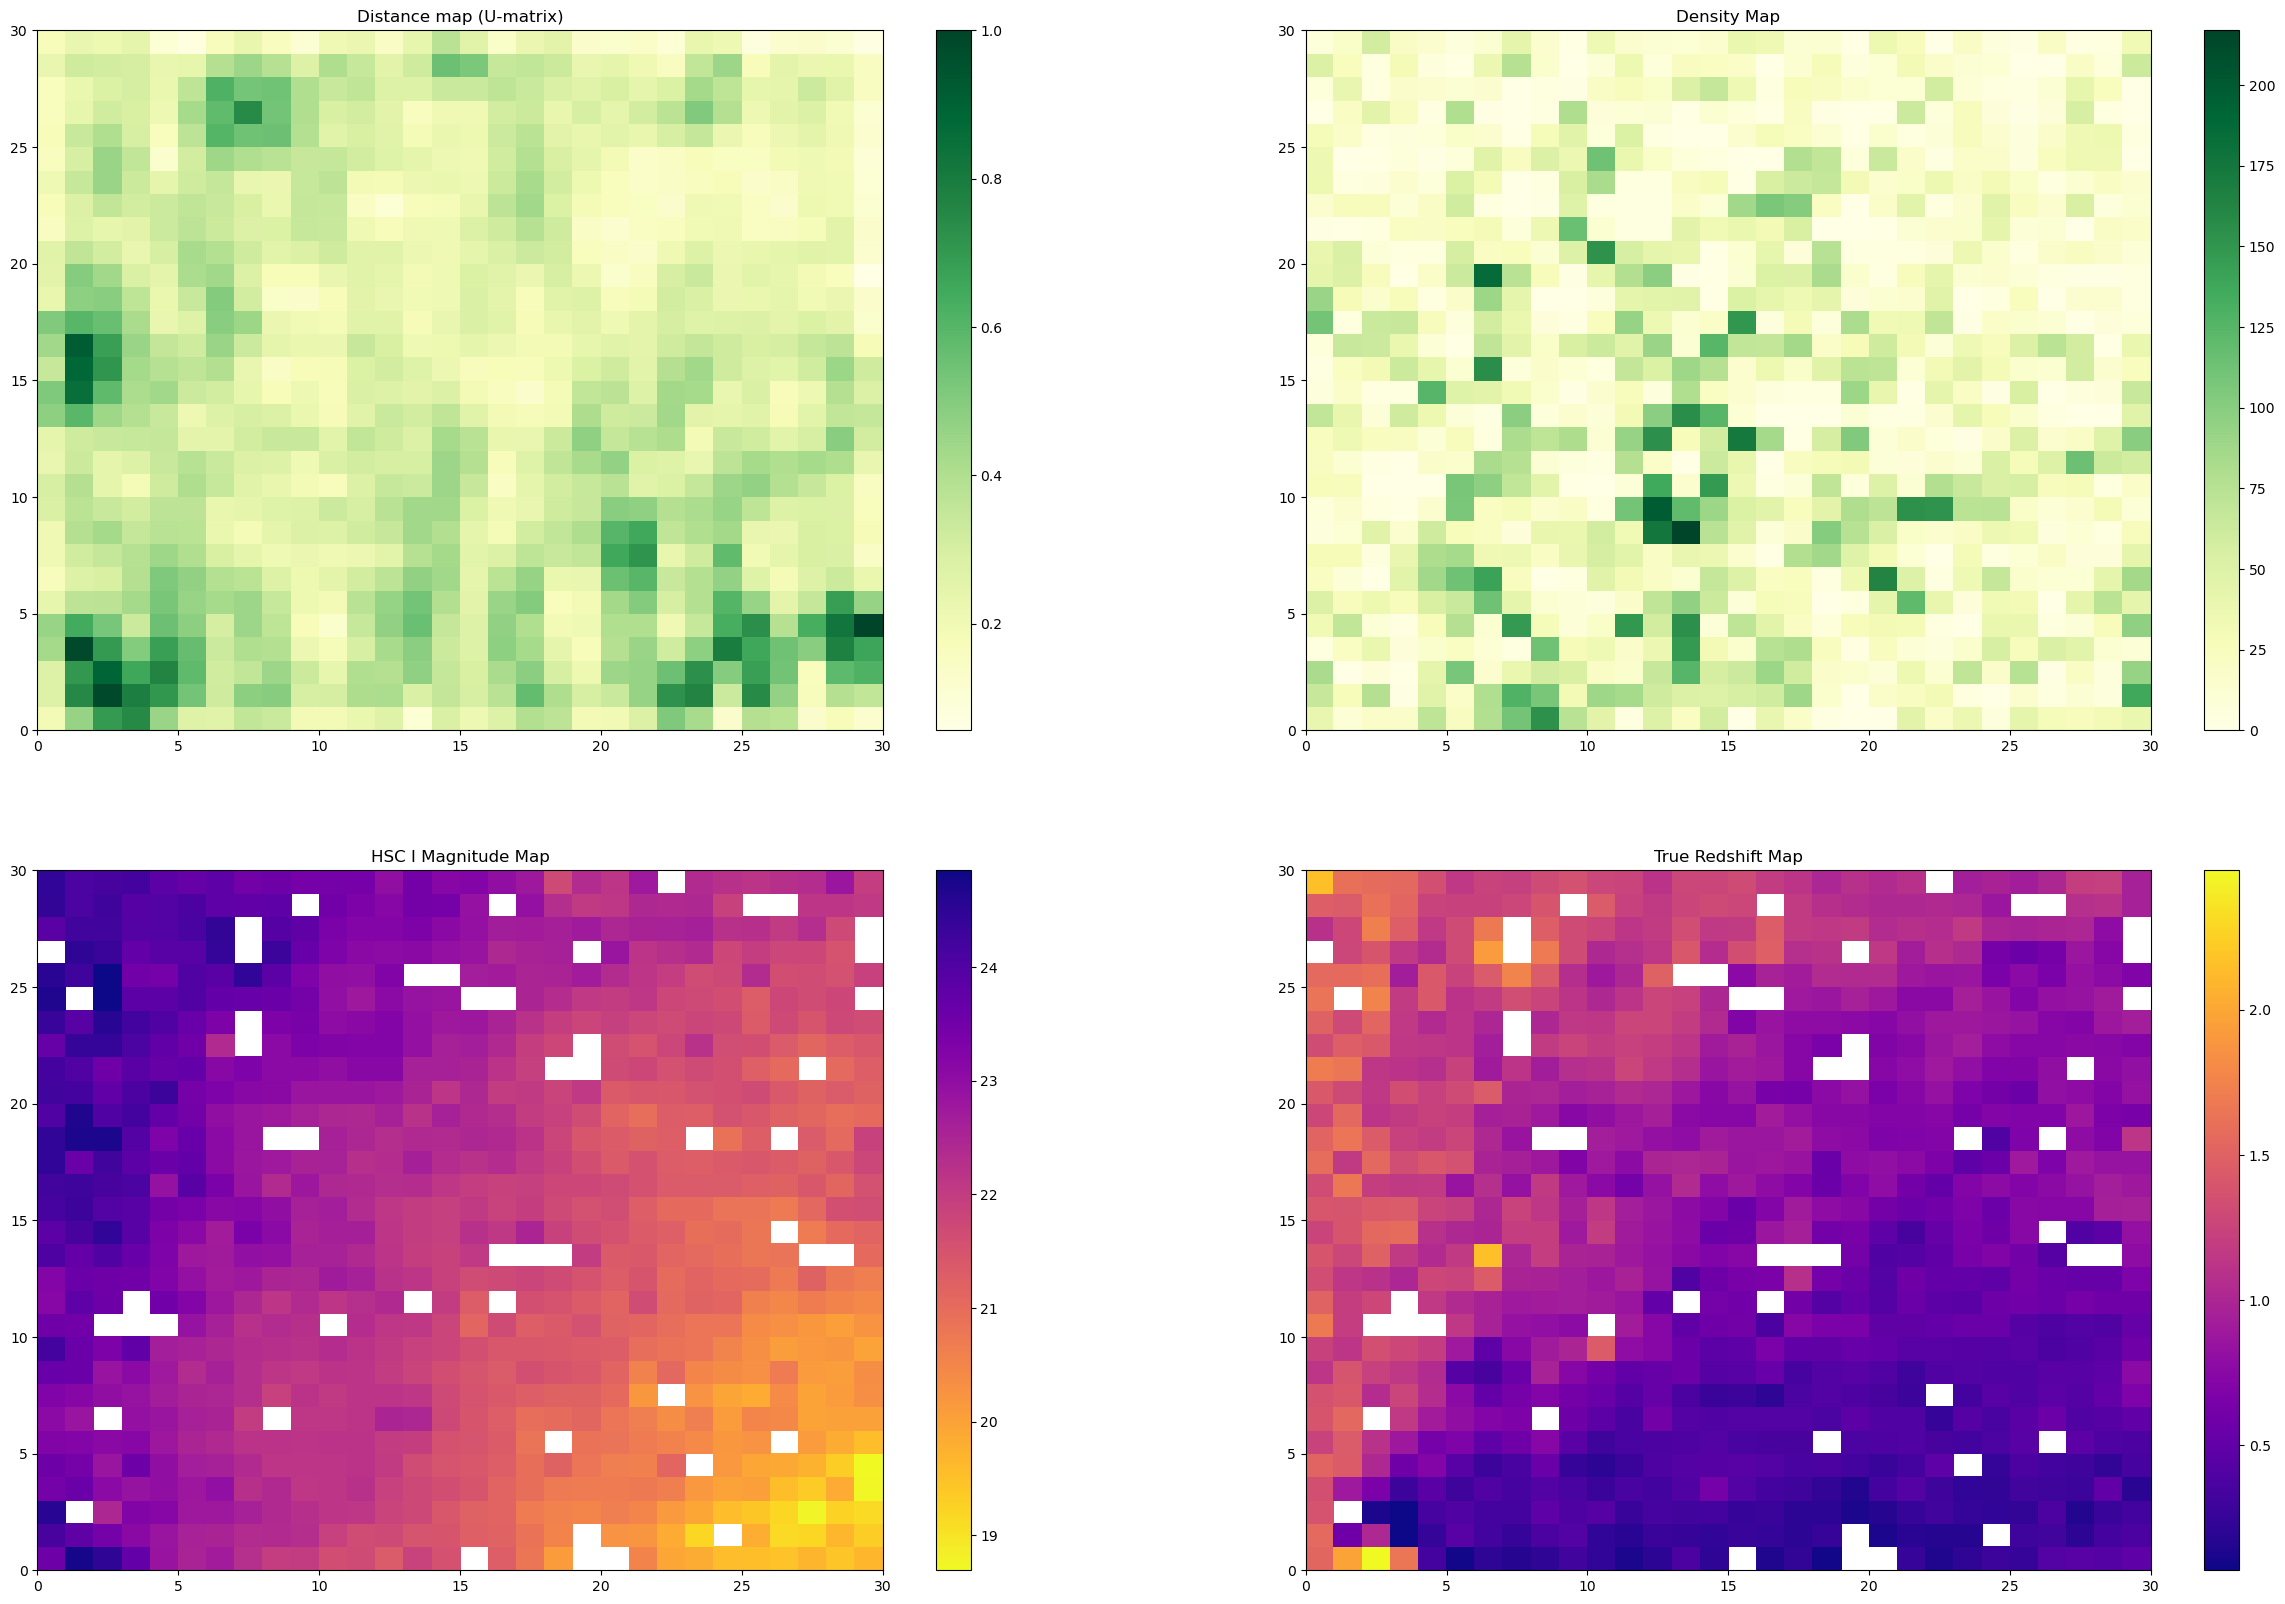

Topological error: 0.5312468416265202
Quantization error: 0.7608765540892464
Topological error: 0.5312468416265202
Quantization error: 0.7608765540892464


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


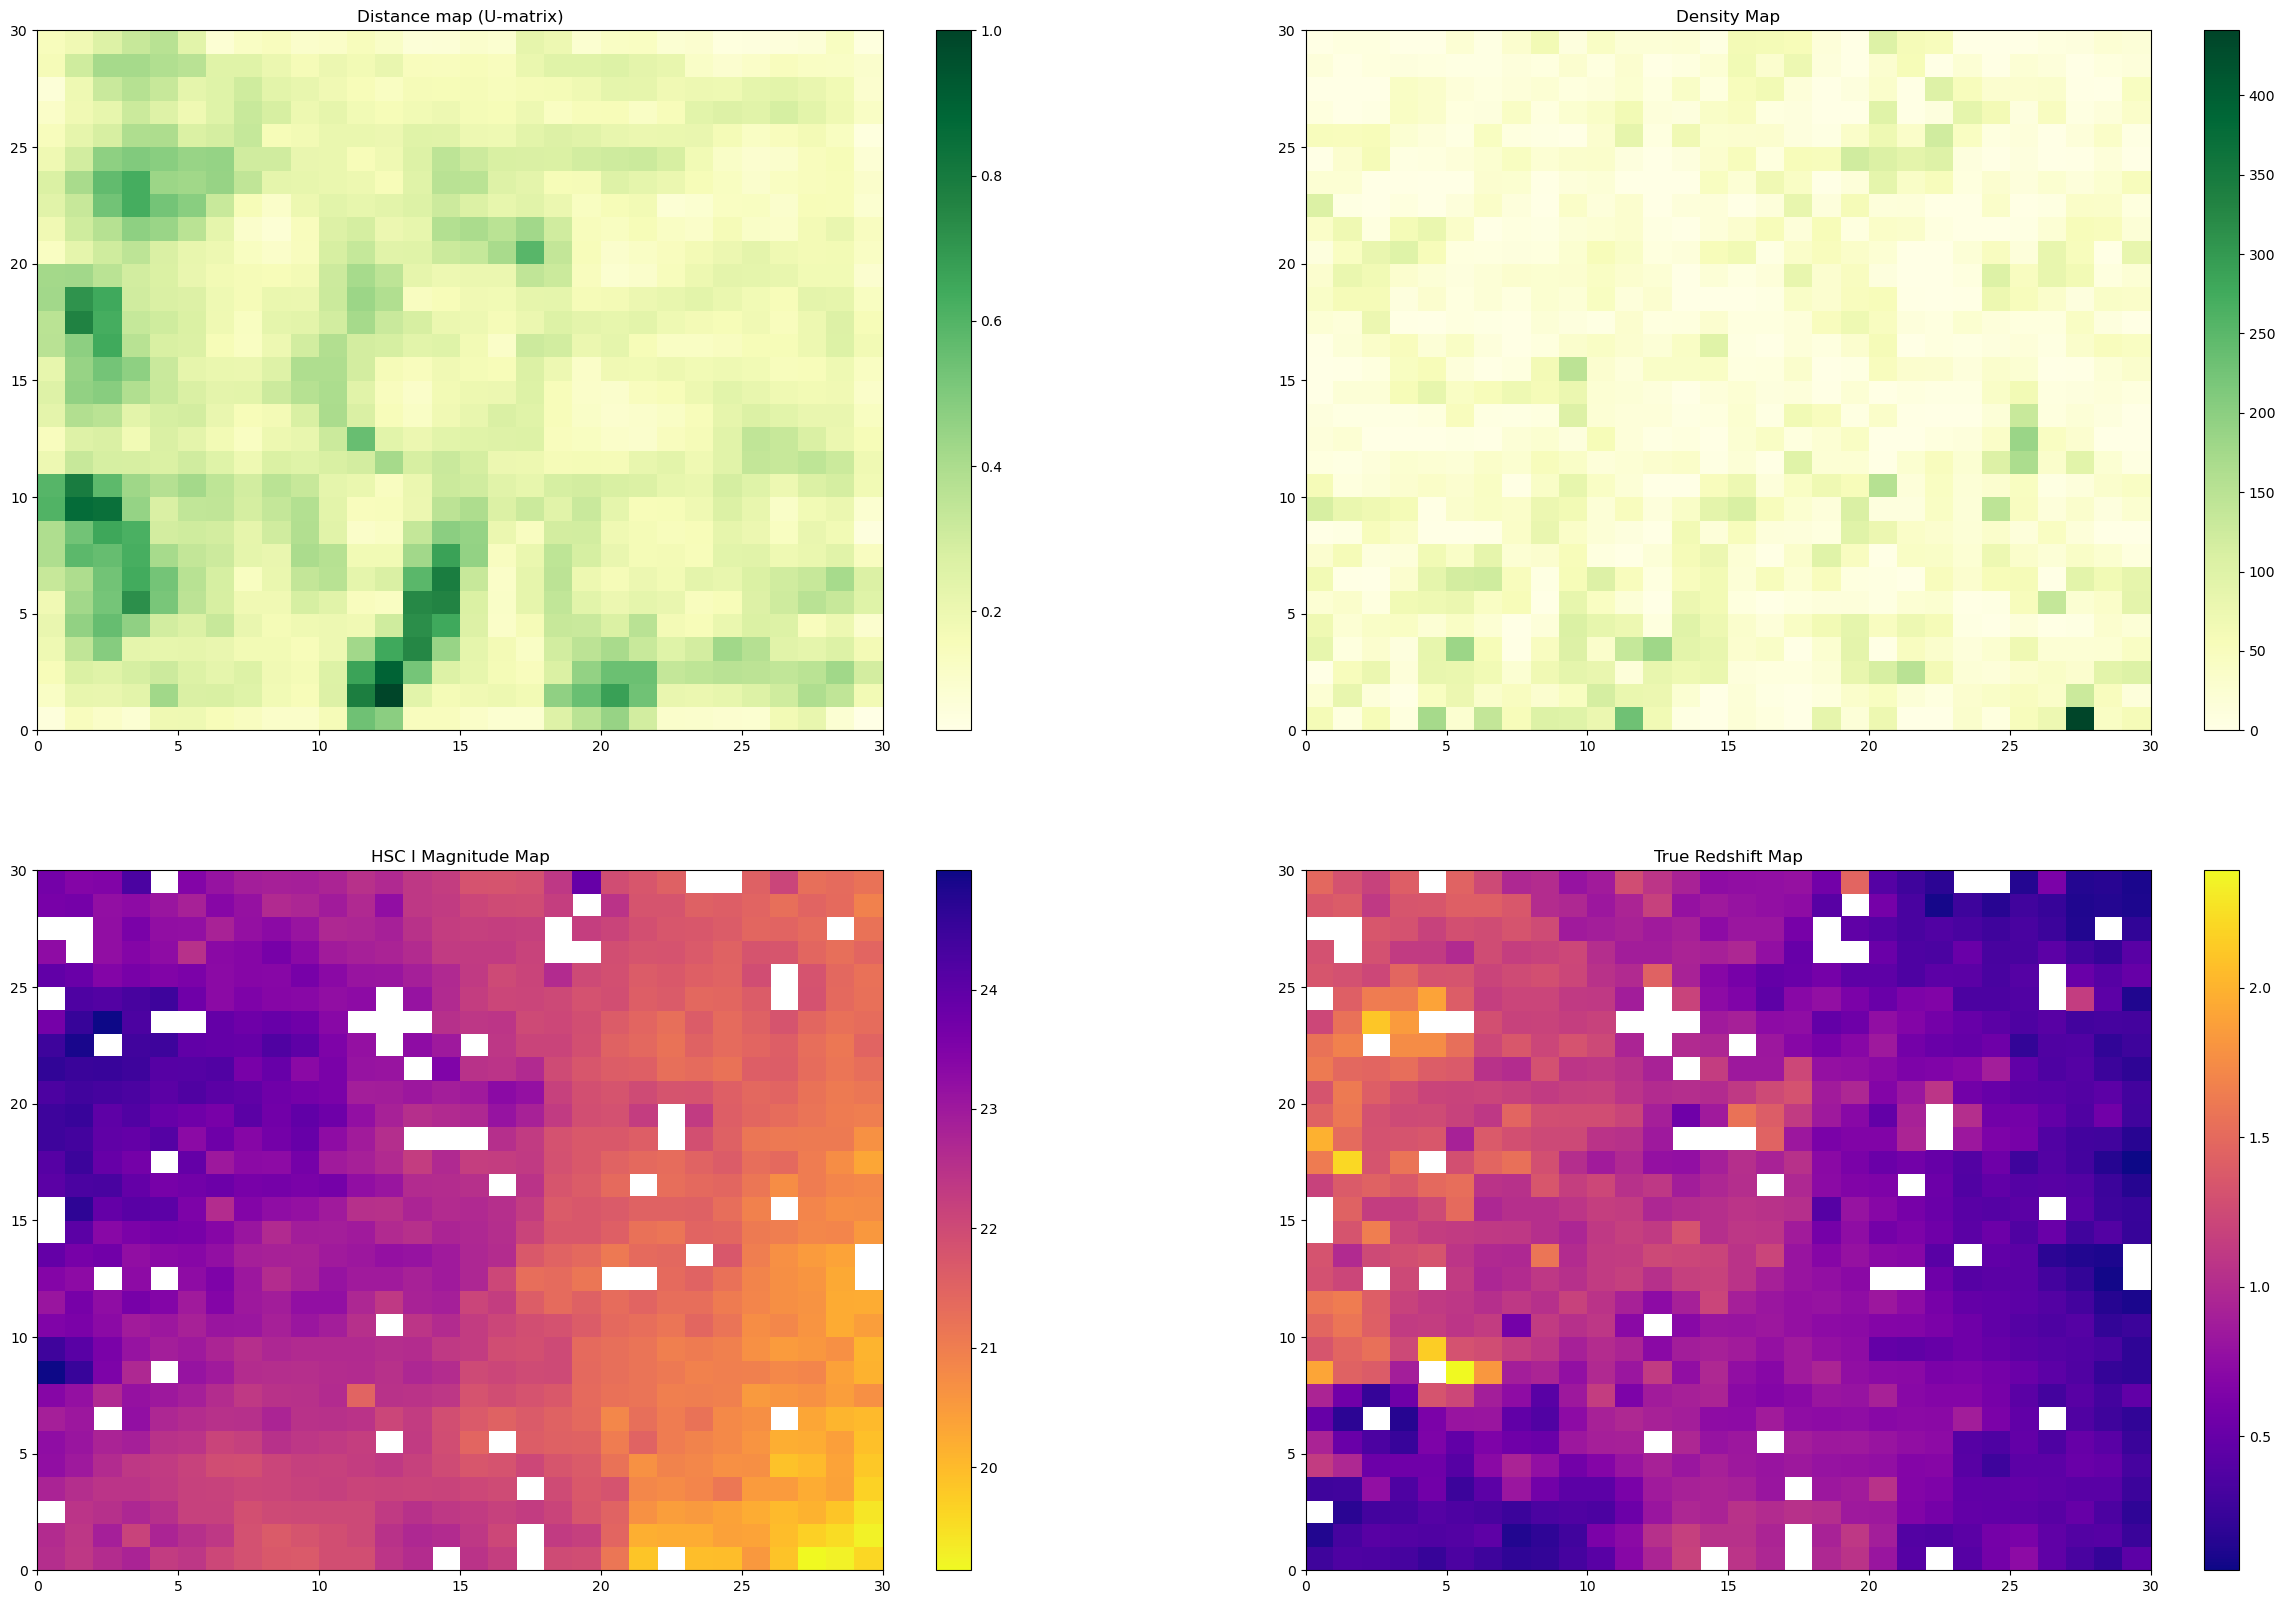

Topological error: 0.5357612101202709
Quantization error: 0.7592238180872125
Topological error: 0.5357612101202709
Quantization error: 0.7592238180872125


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


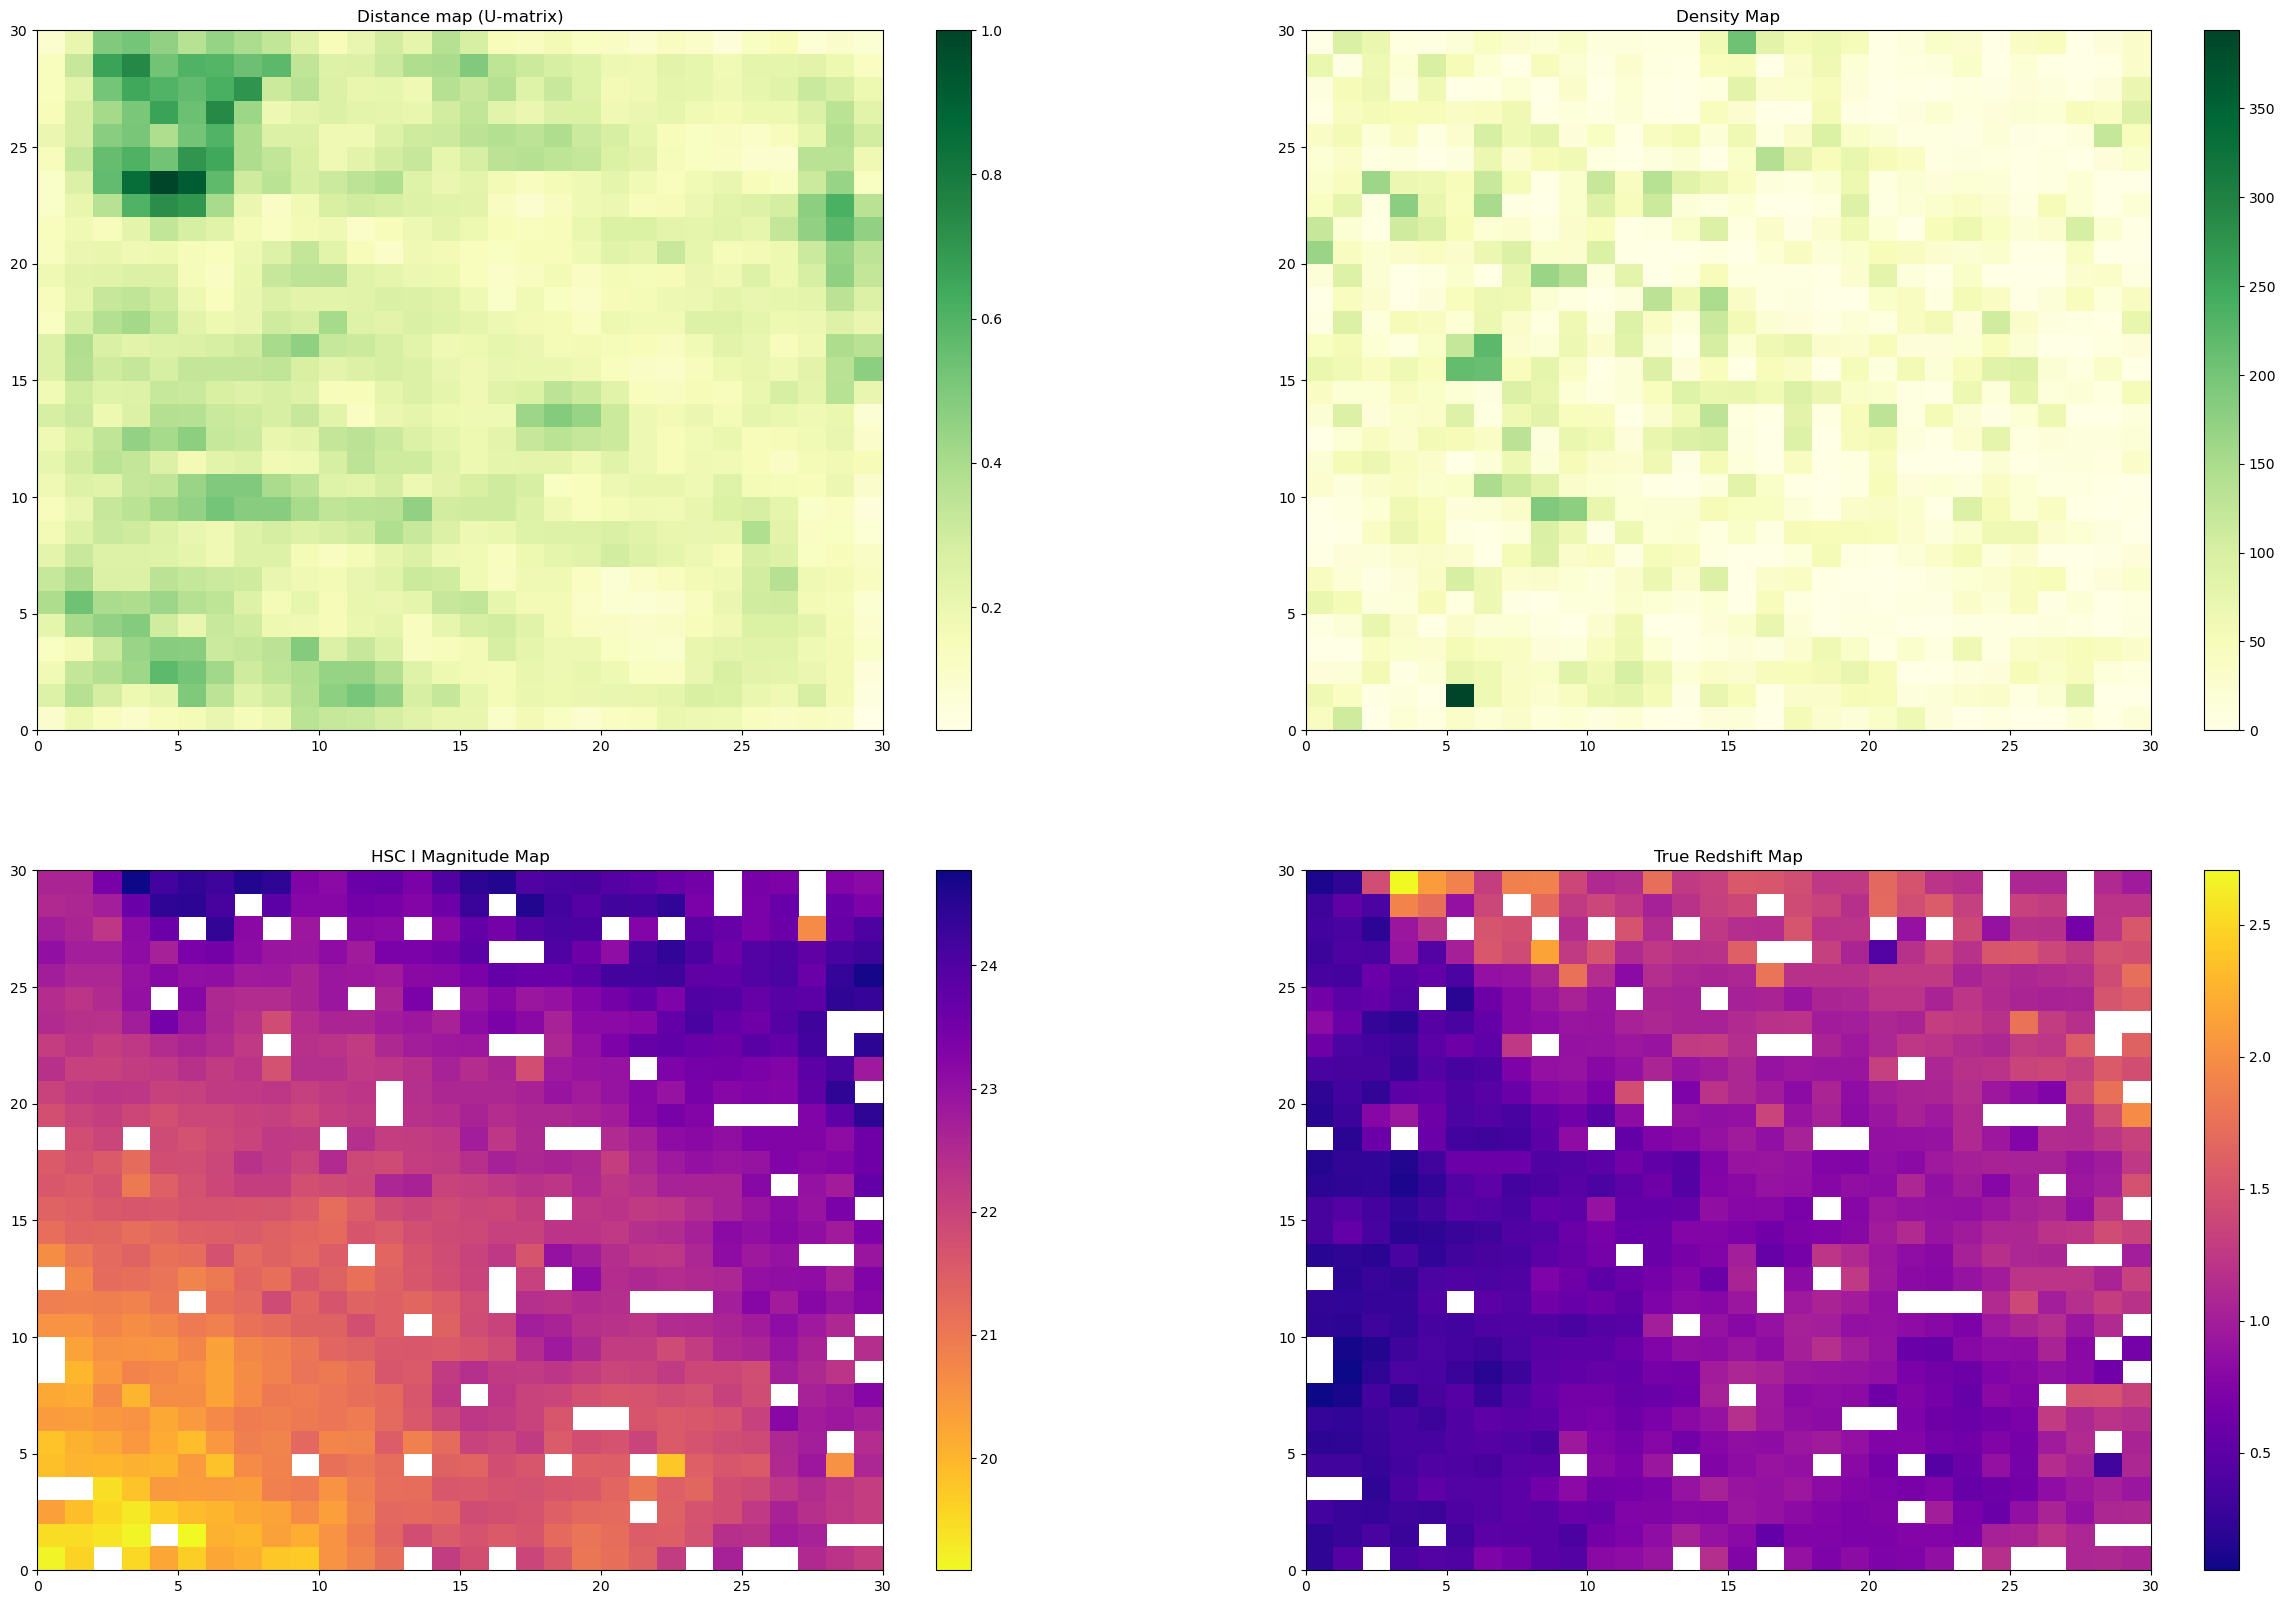

Topological error: 0.5484957719907018
Quantization error: 0.7640536707224731
Topological error: 0.5484957719907018
Quantization error: 0.7640536707224731


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


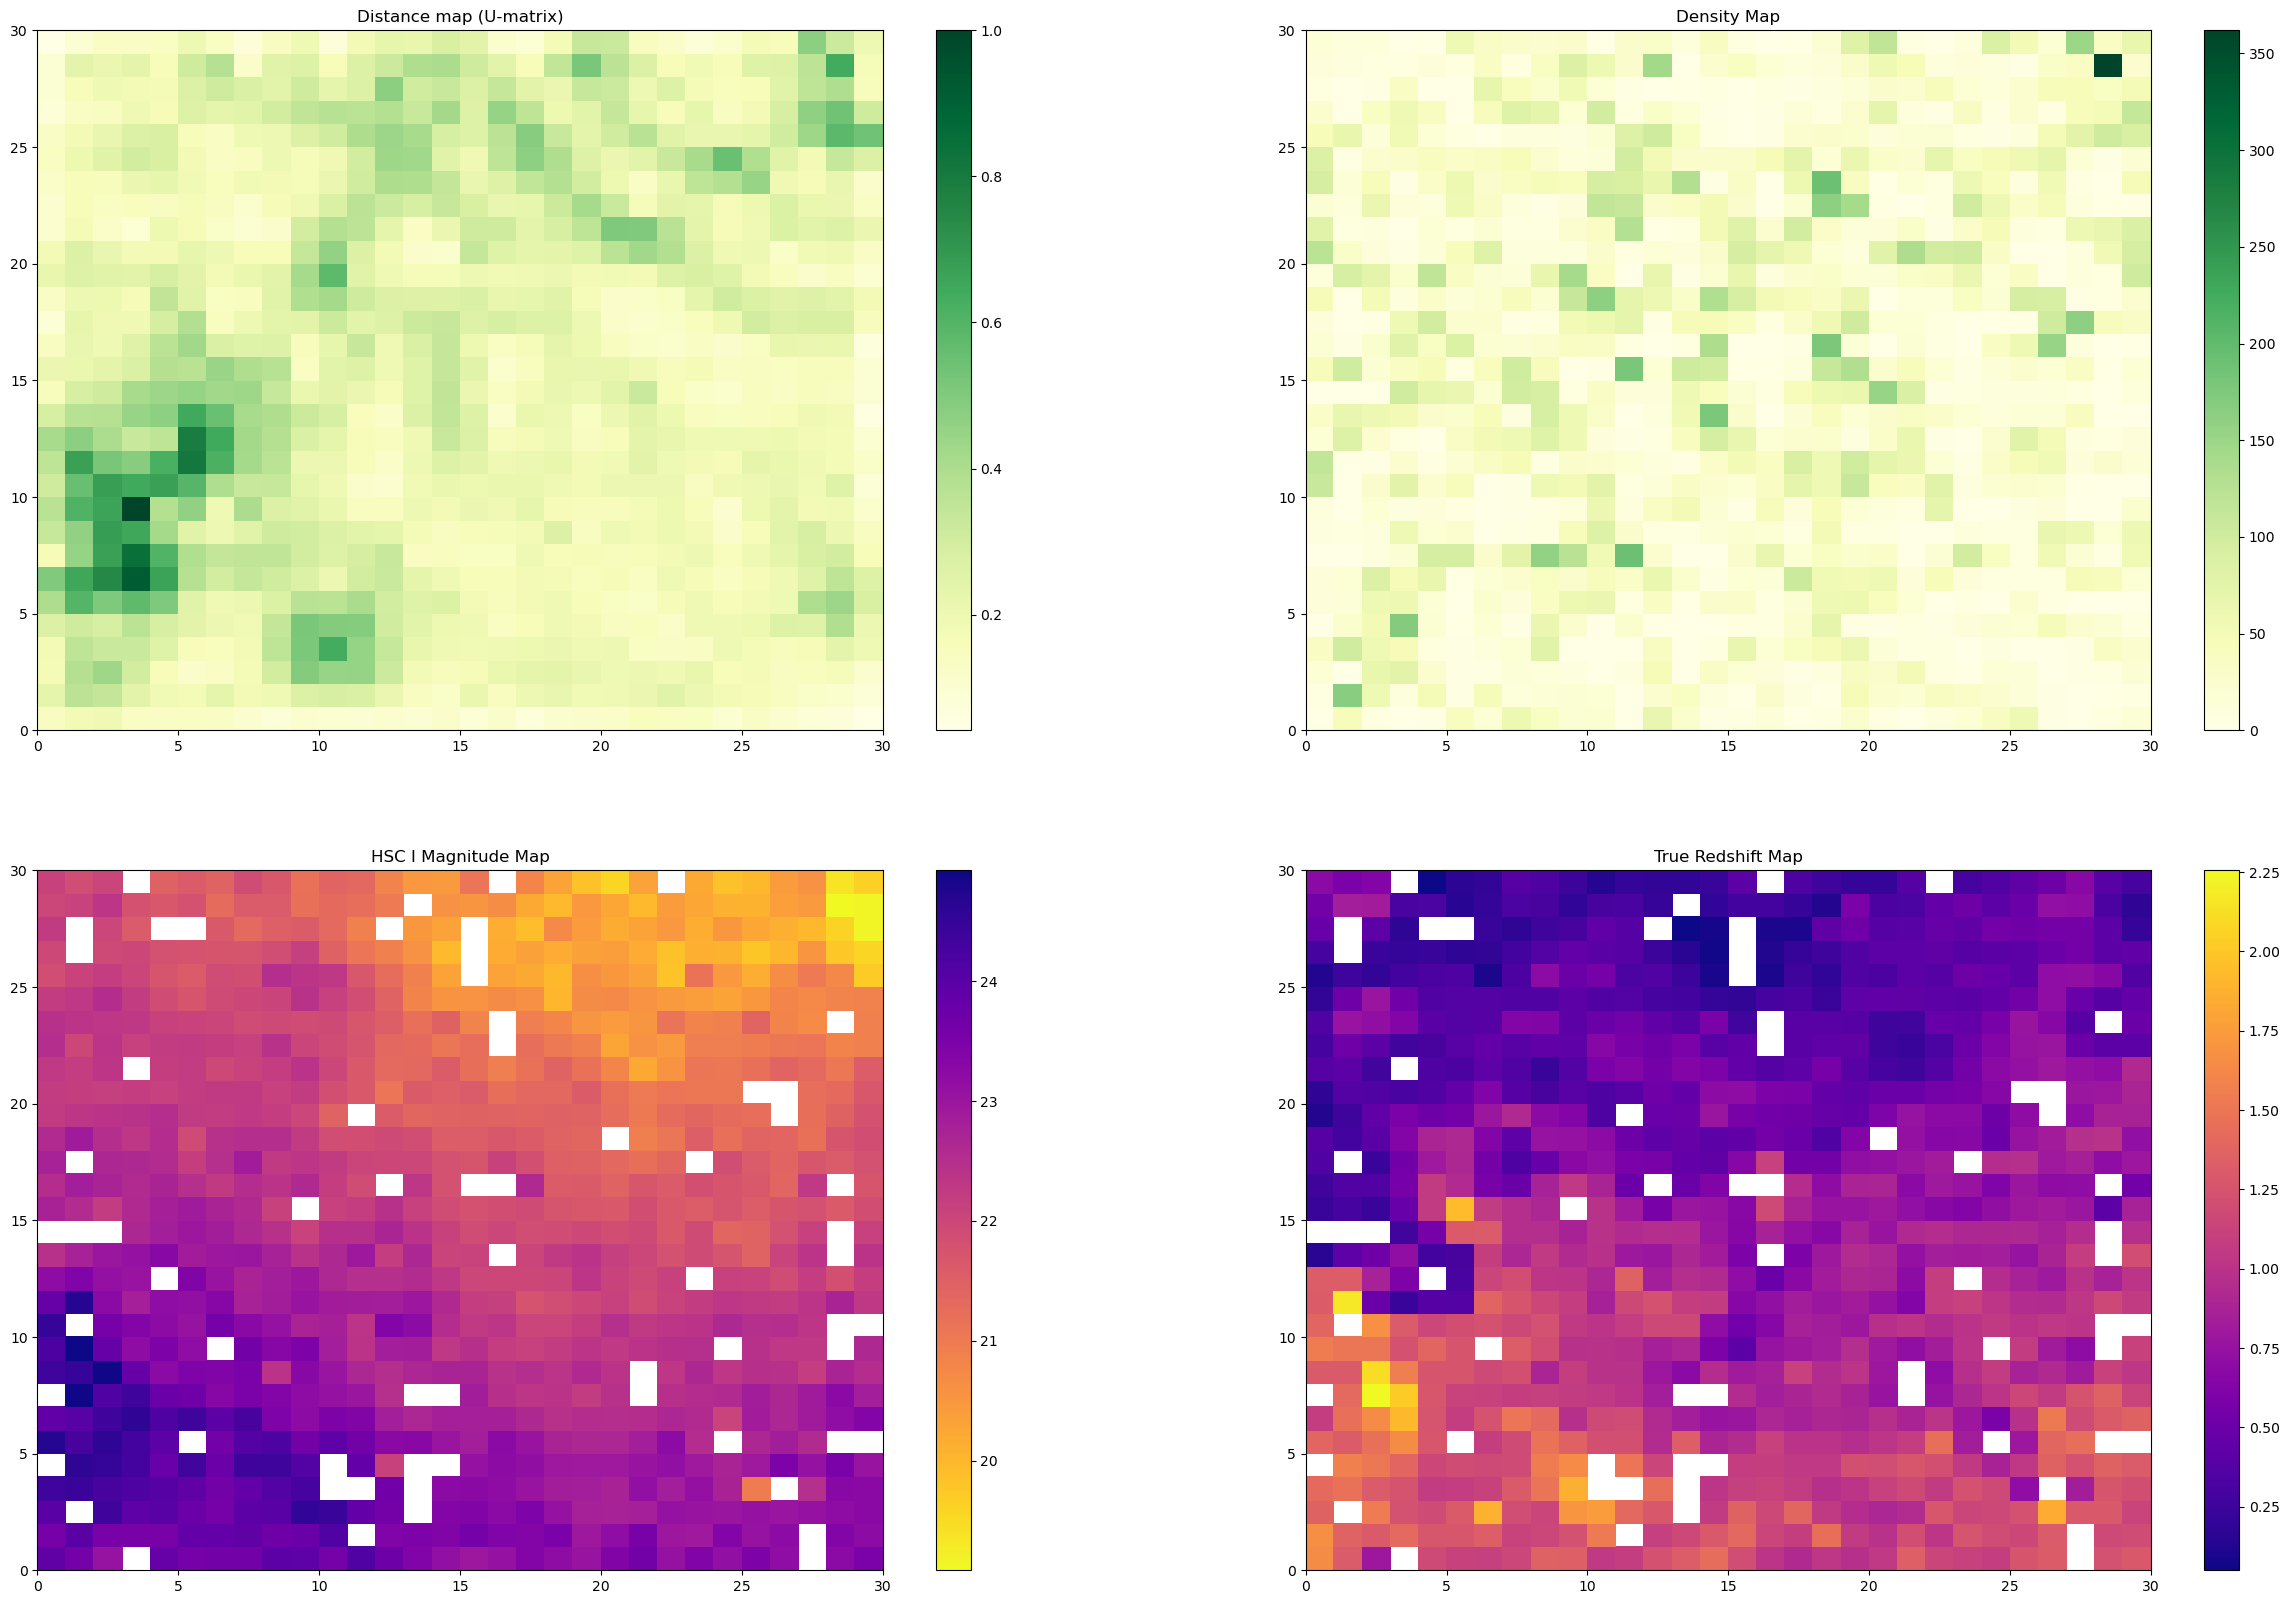

Topological error: 0.6036451841121181
Quantization error: 0.7569982203148246
Topological error: 0.6036451841121181
Quantization error: 0.7569982203148246


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


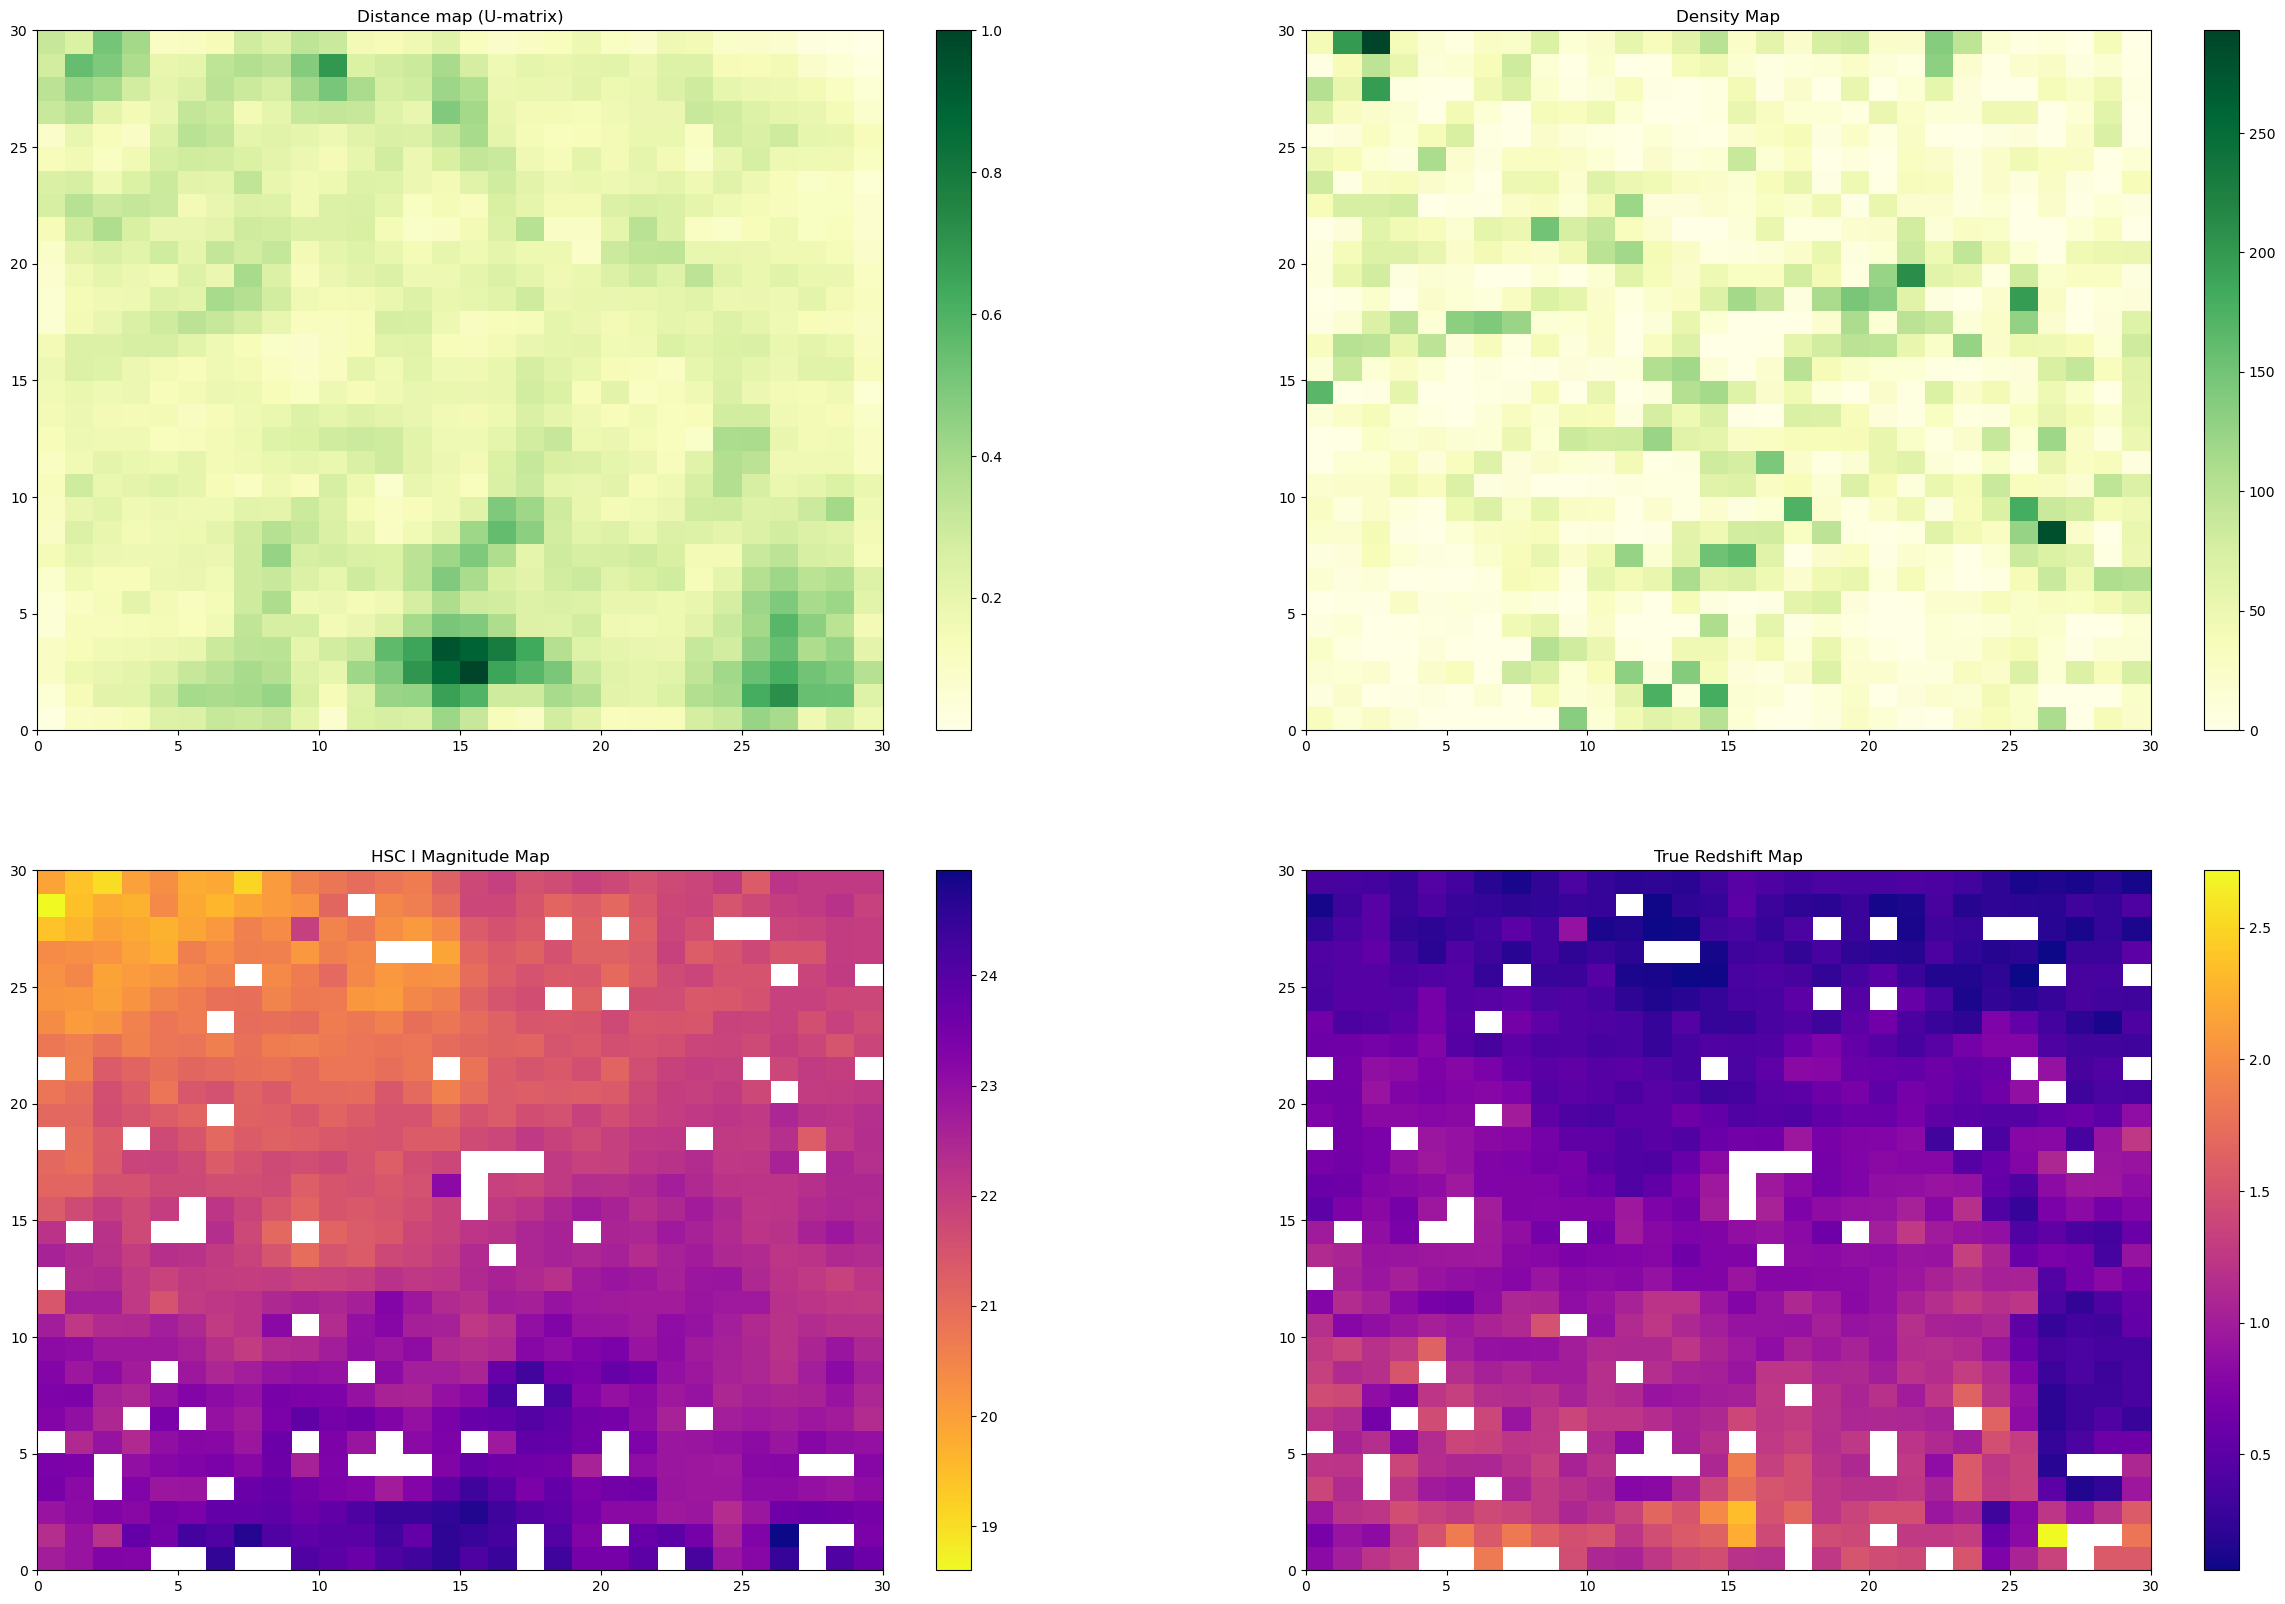

Topological error: 0.606003436310346
Quantization error: 0.7567472340669453
Topological error: 0.606003436310346
Quantization error: 0.7567472340669453


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


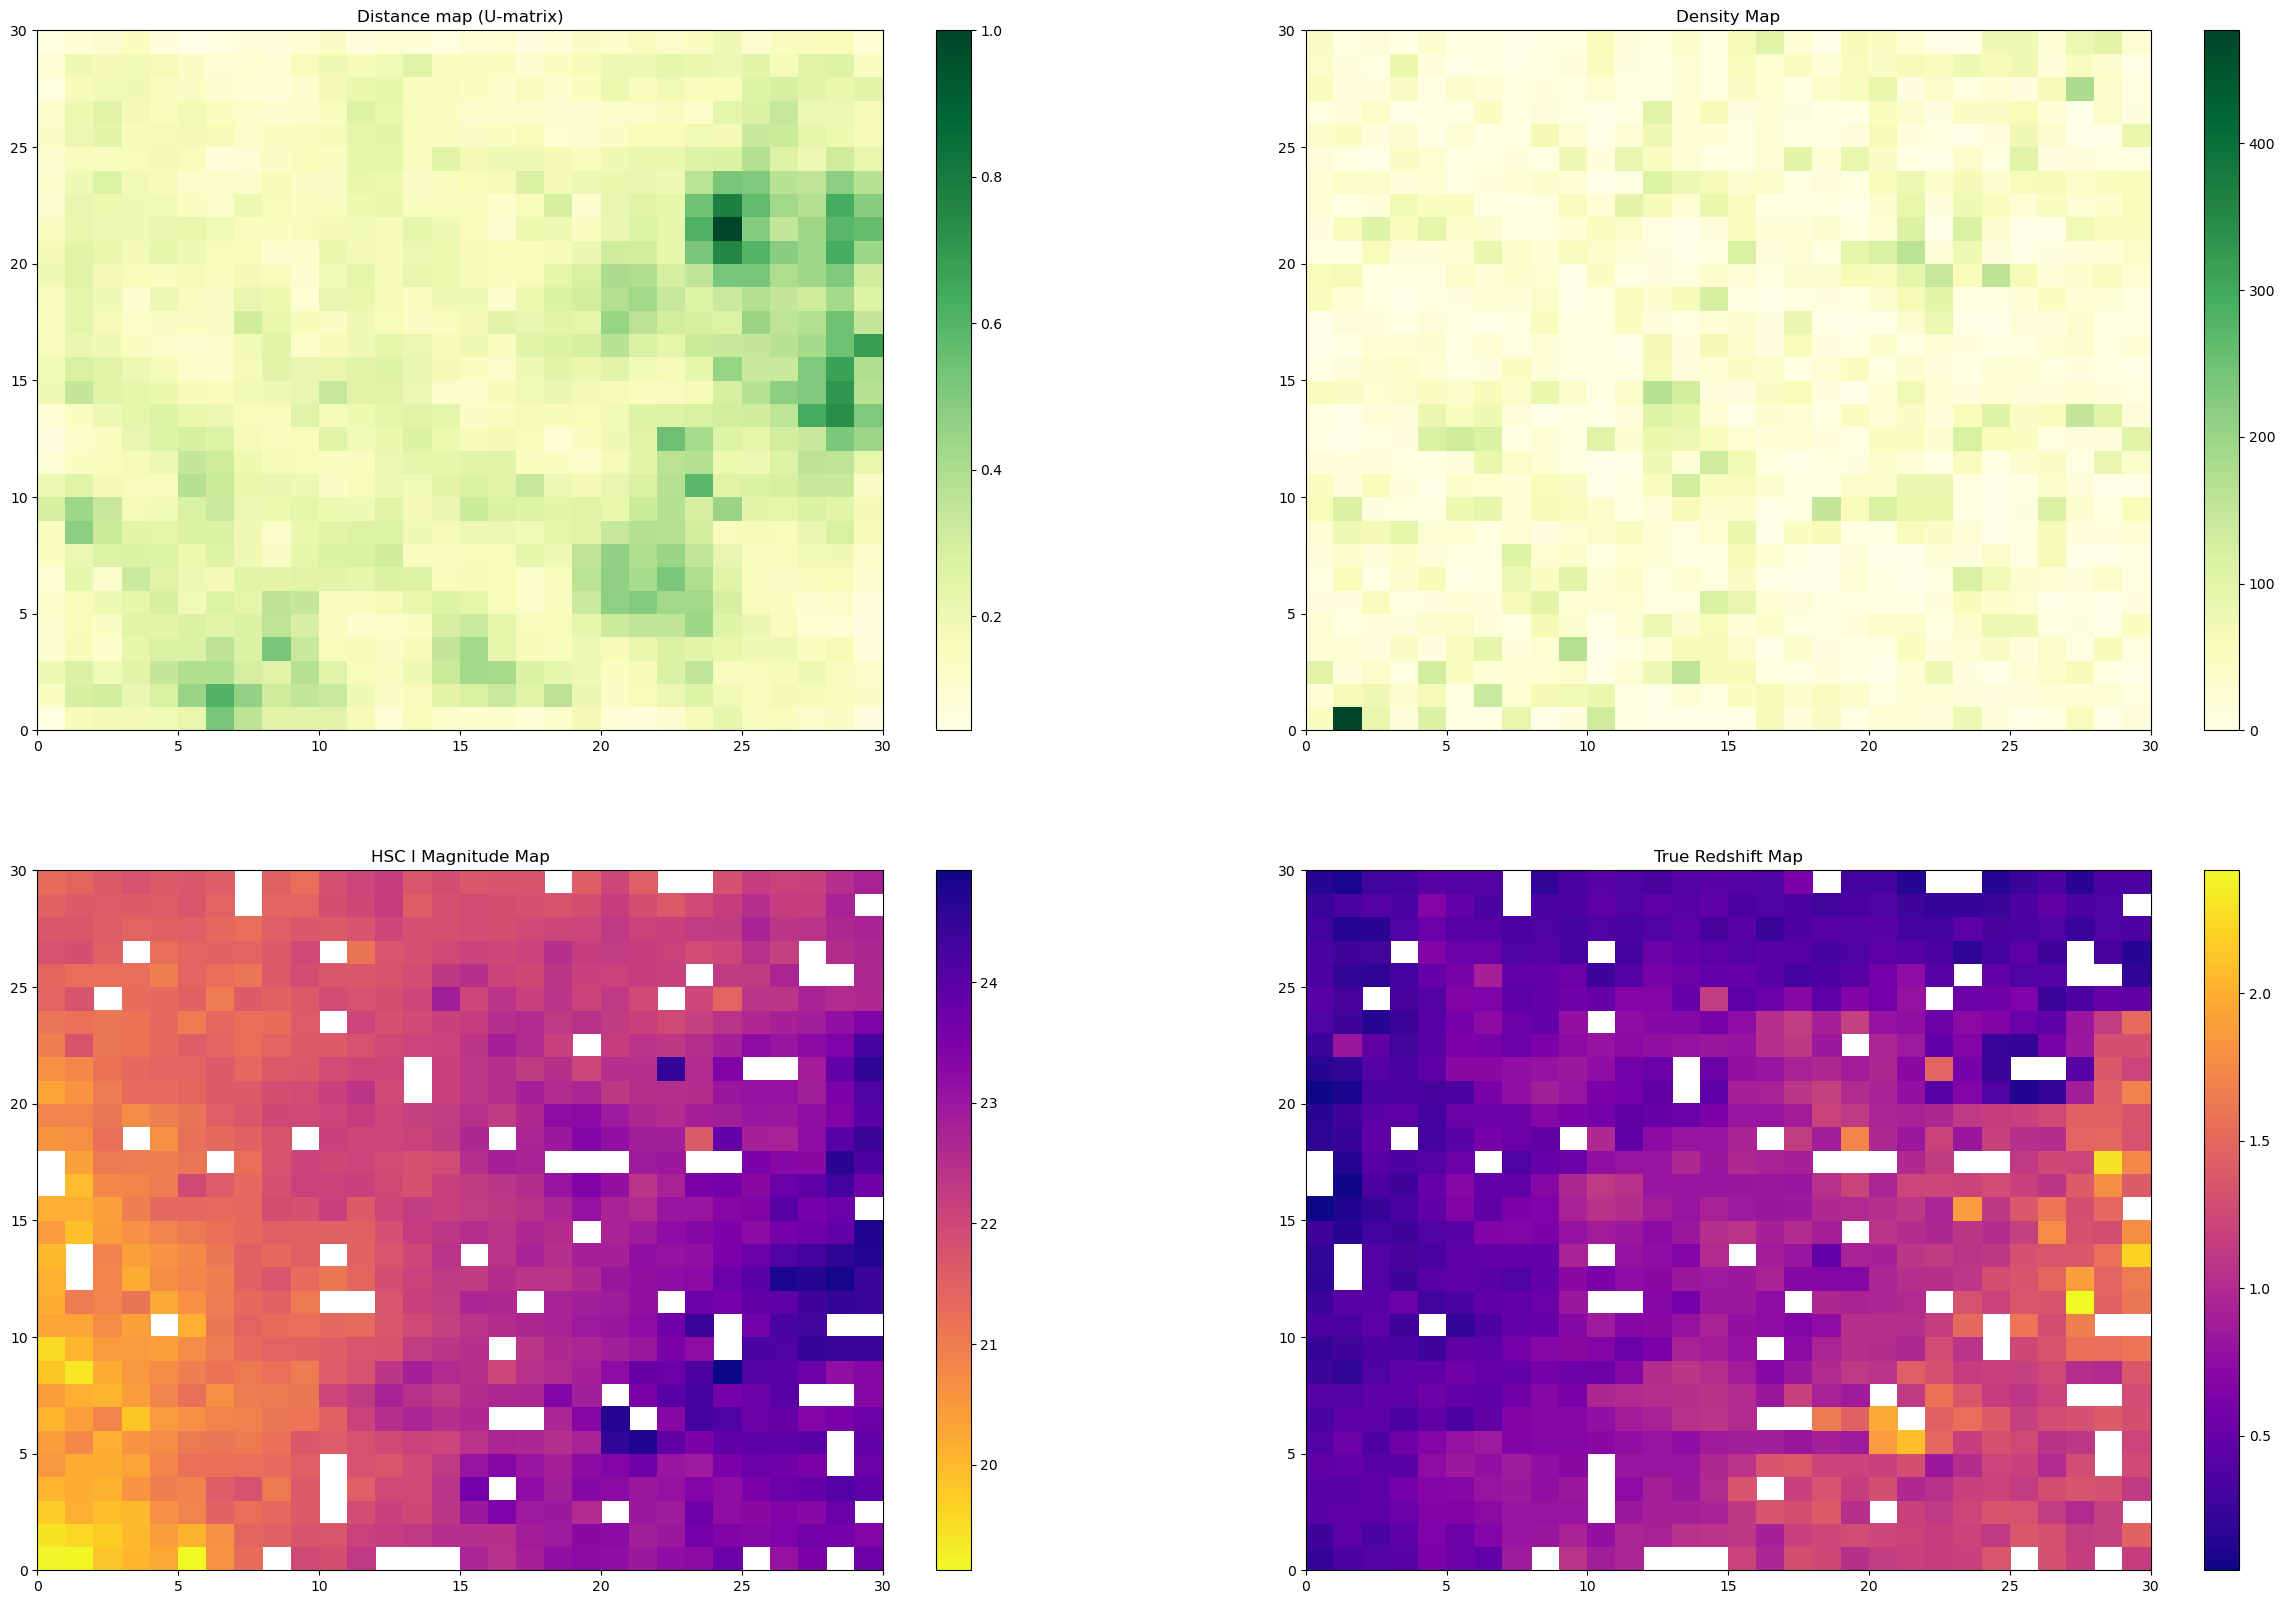

Topological error: 0.6629720715561096
Quantization error: 0.7886715877577033
Topological error: 0.6629720715561096
Quantization error: 0.7886715877577033


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


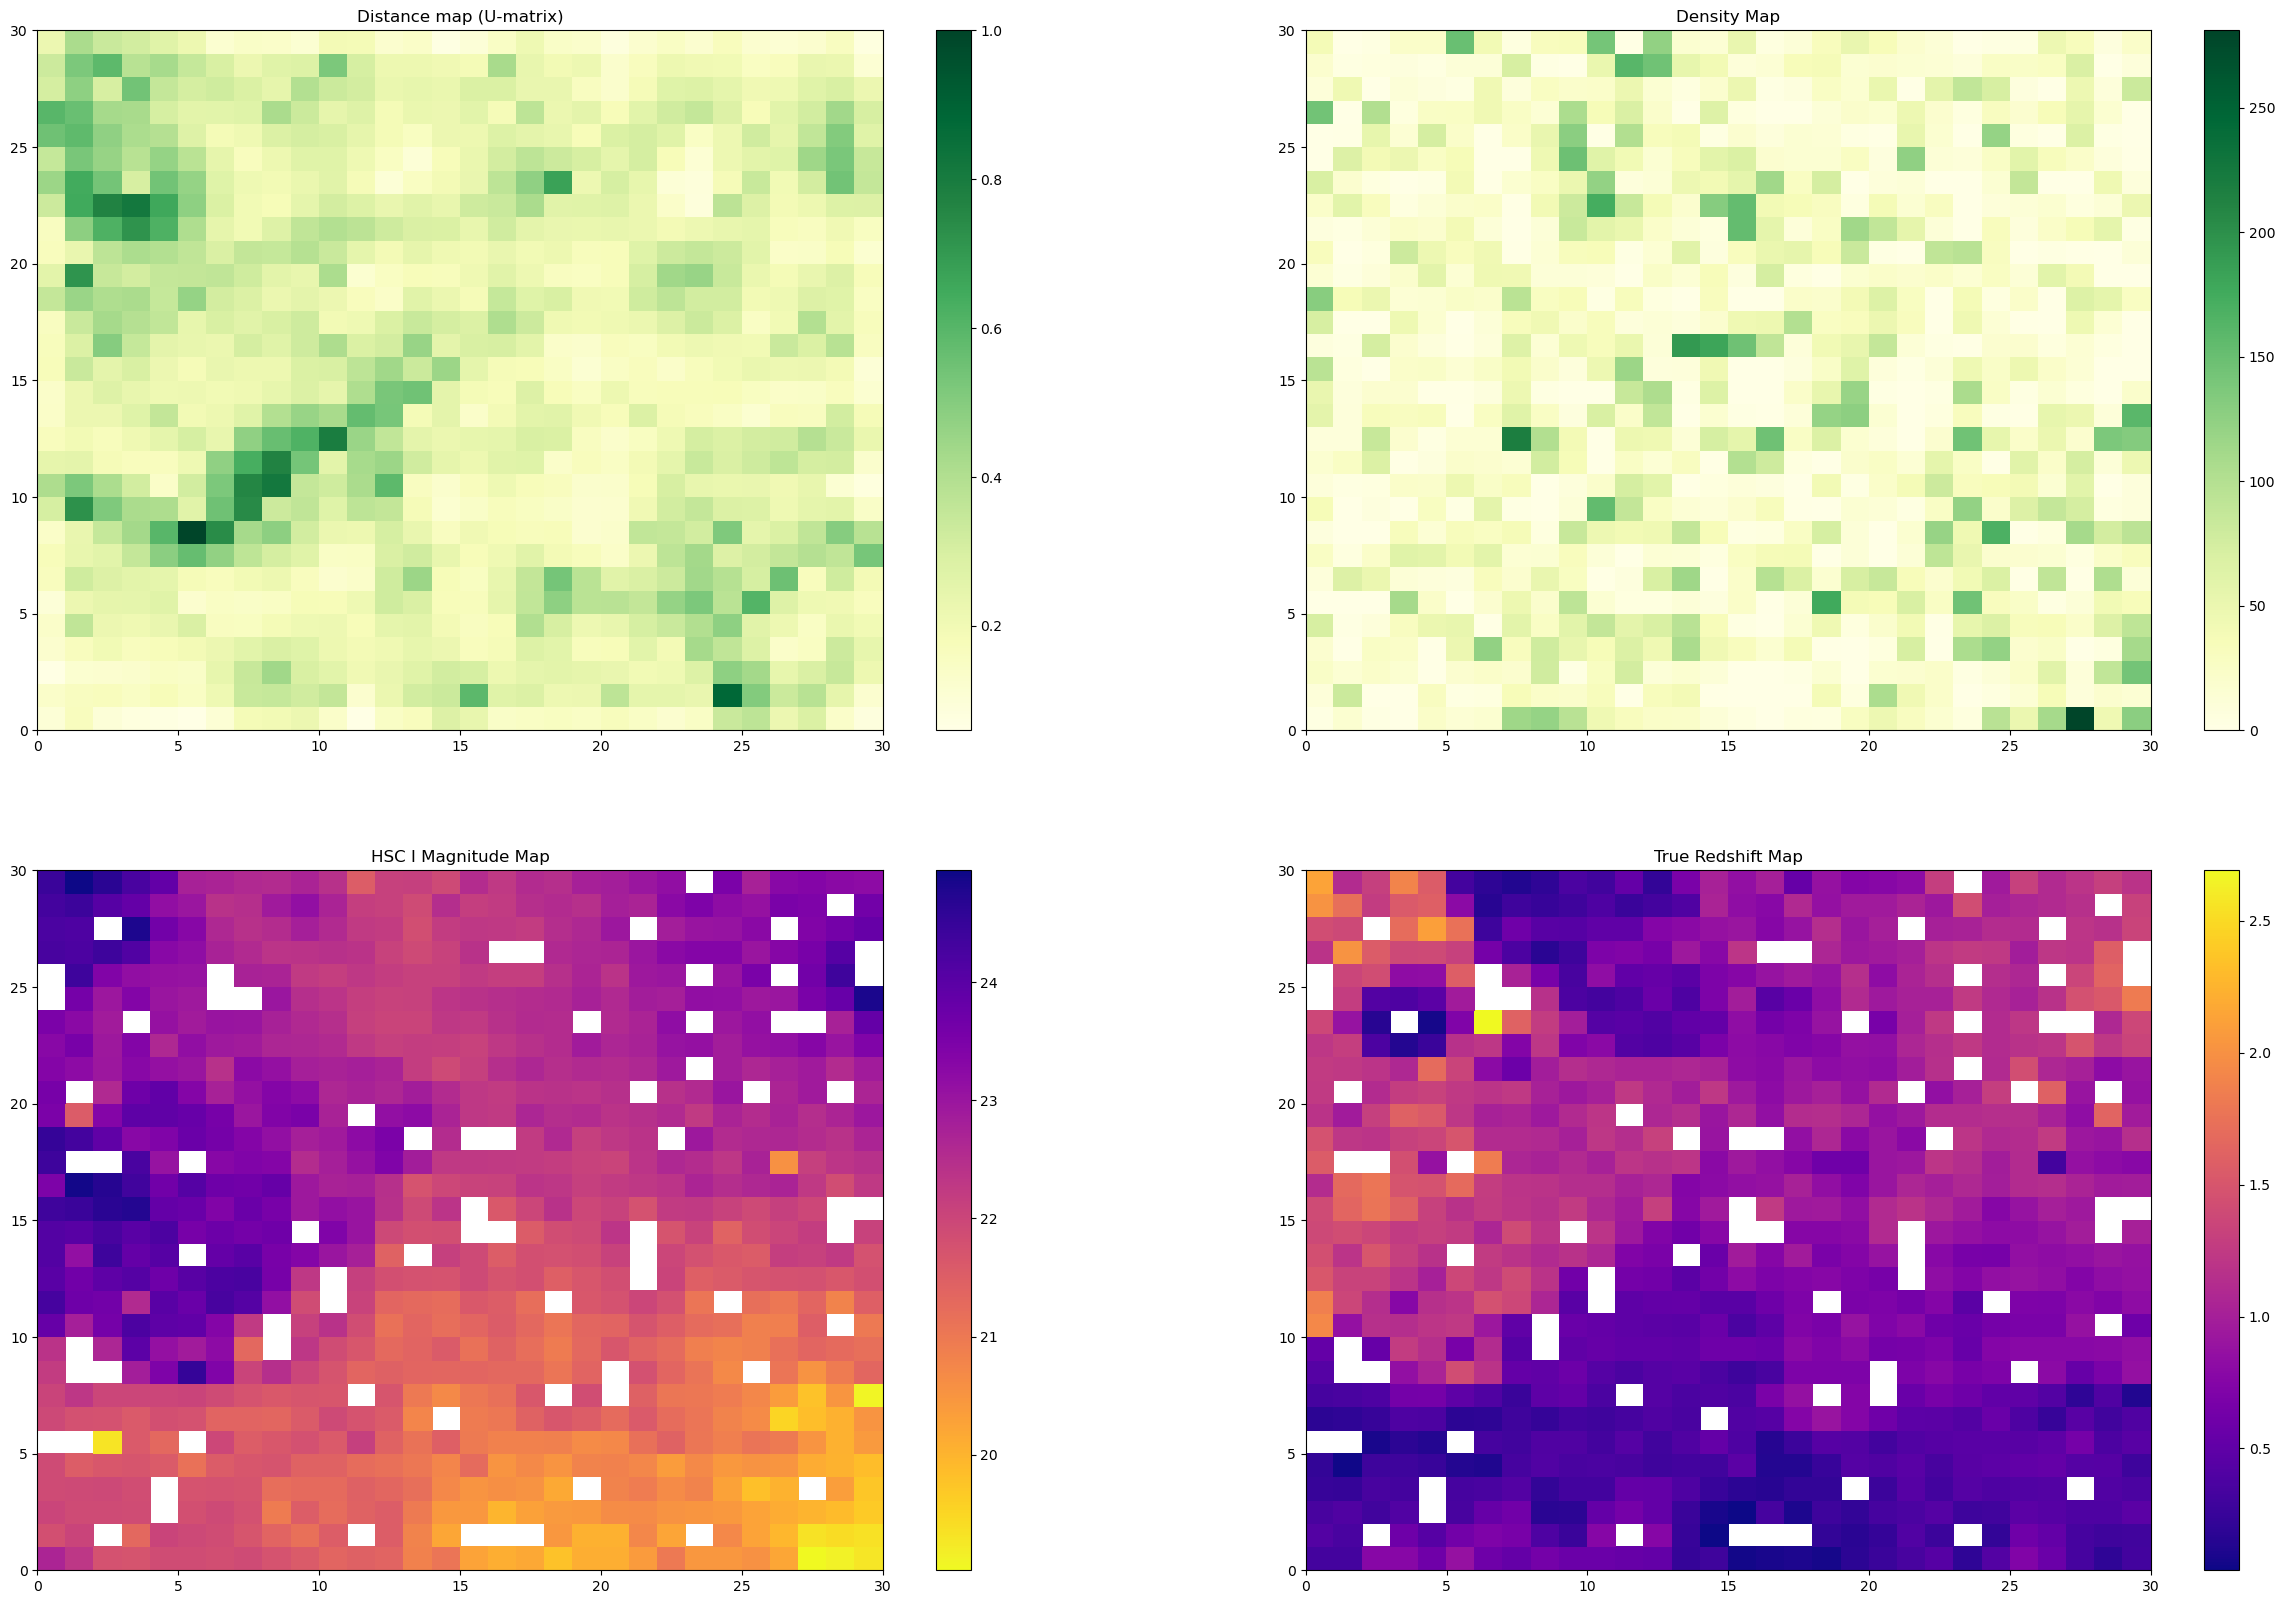

Topological error: 0.6974025536502375
Quantization error: 0.7482692494090789
Topological error: 0.6974025536502375
Quantization error: 0.7482692494090789


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


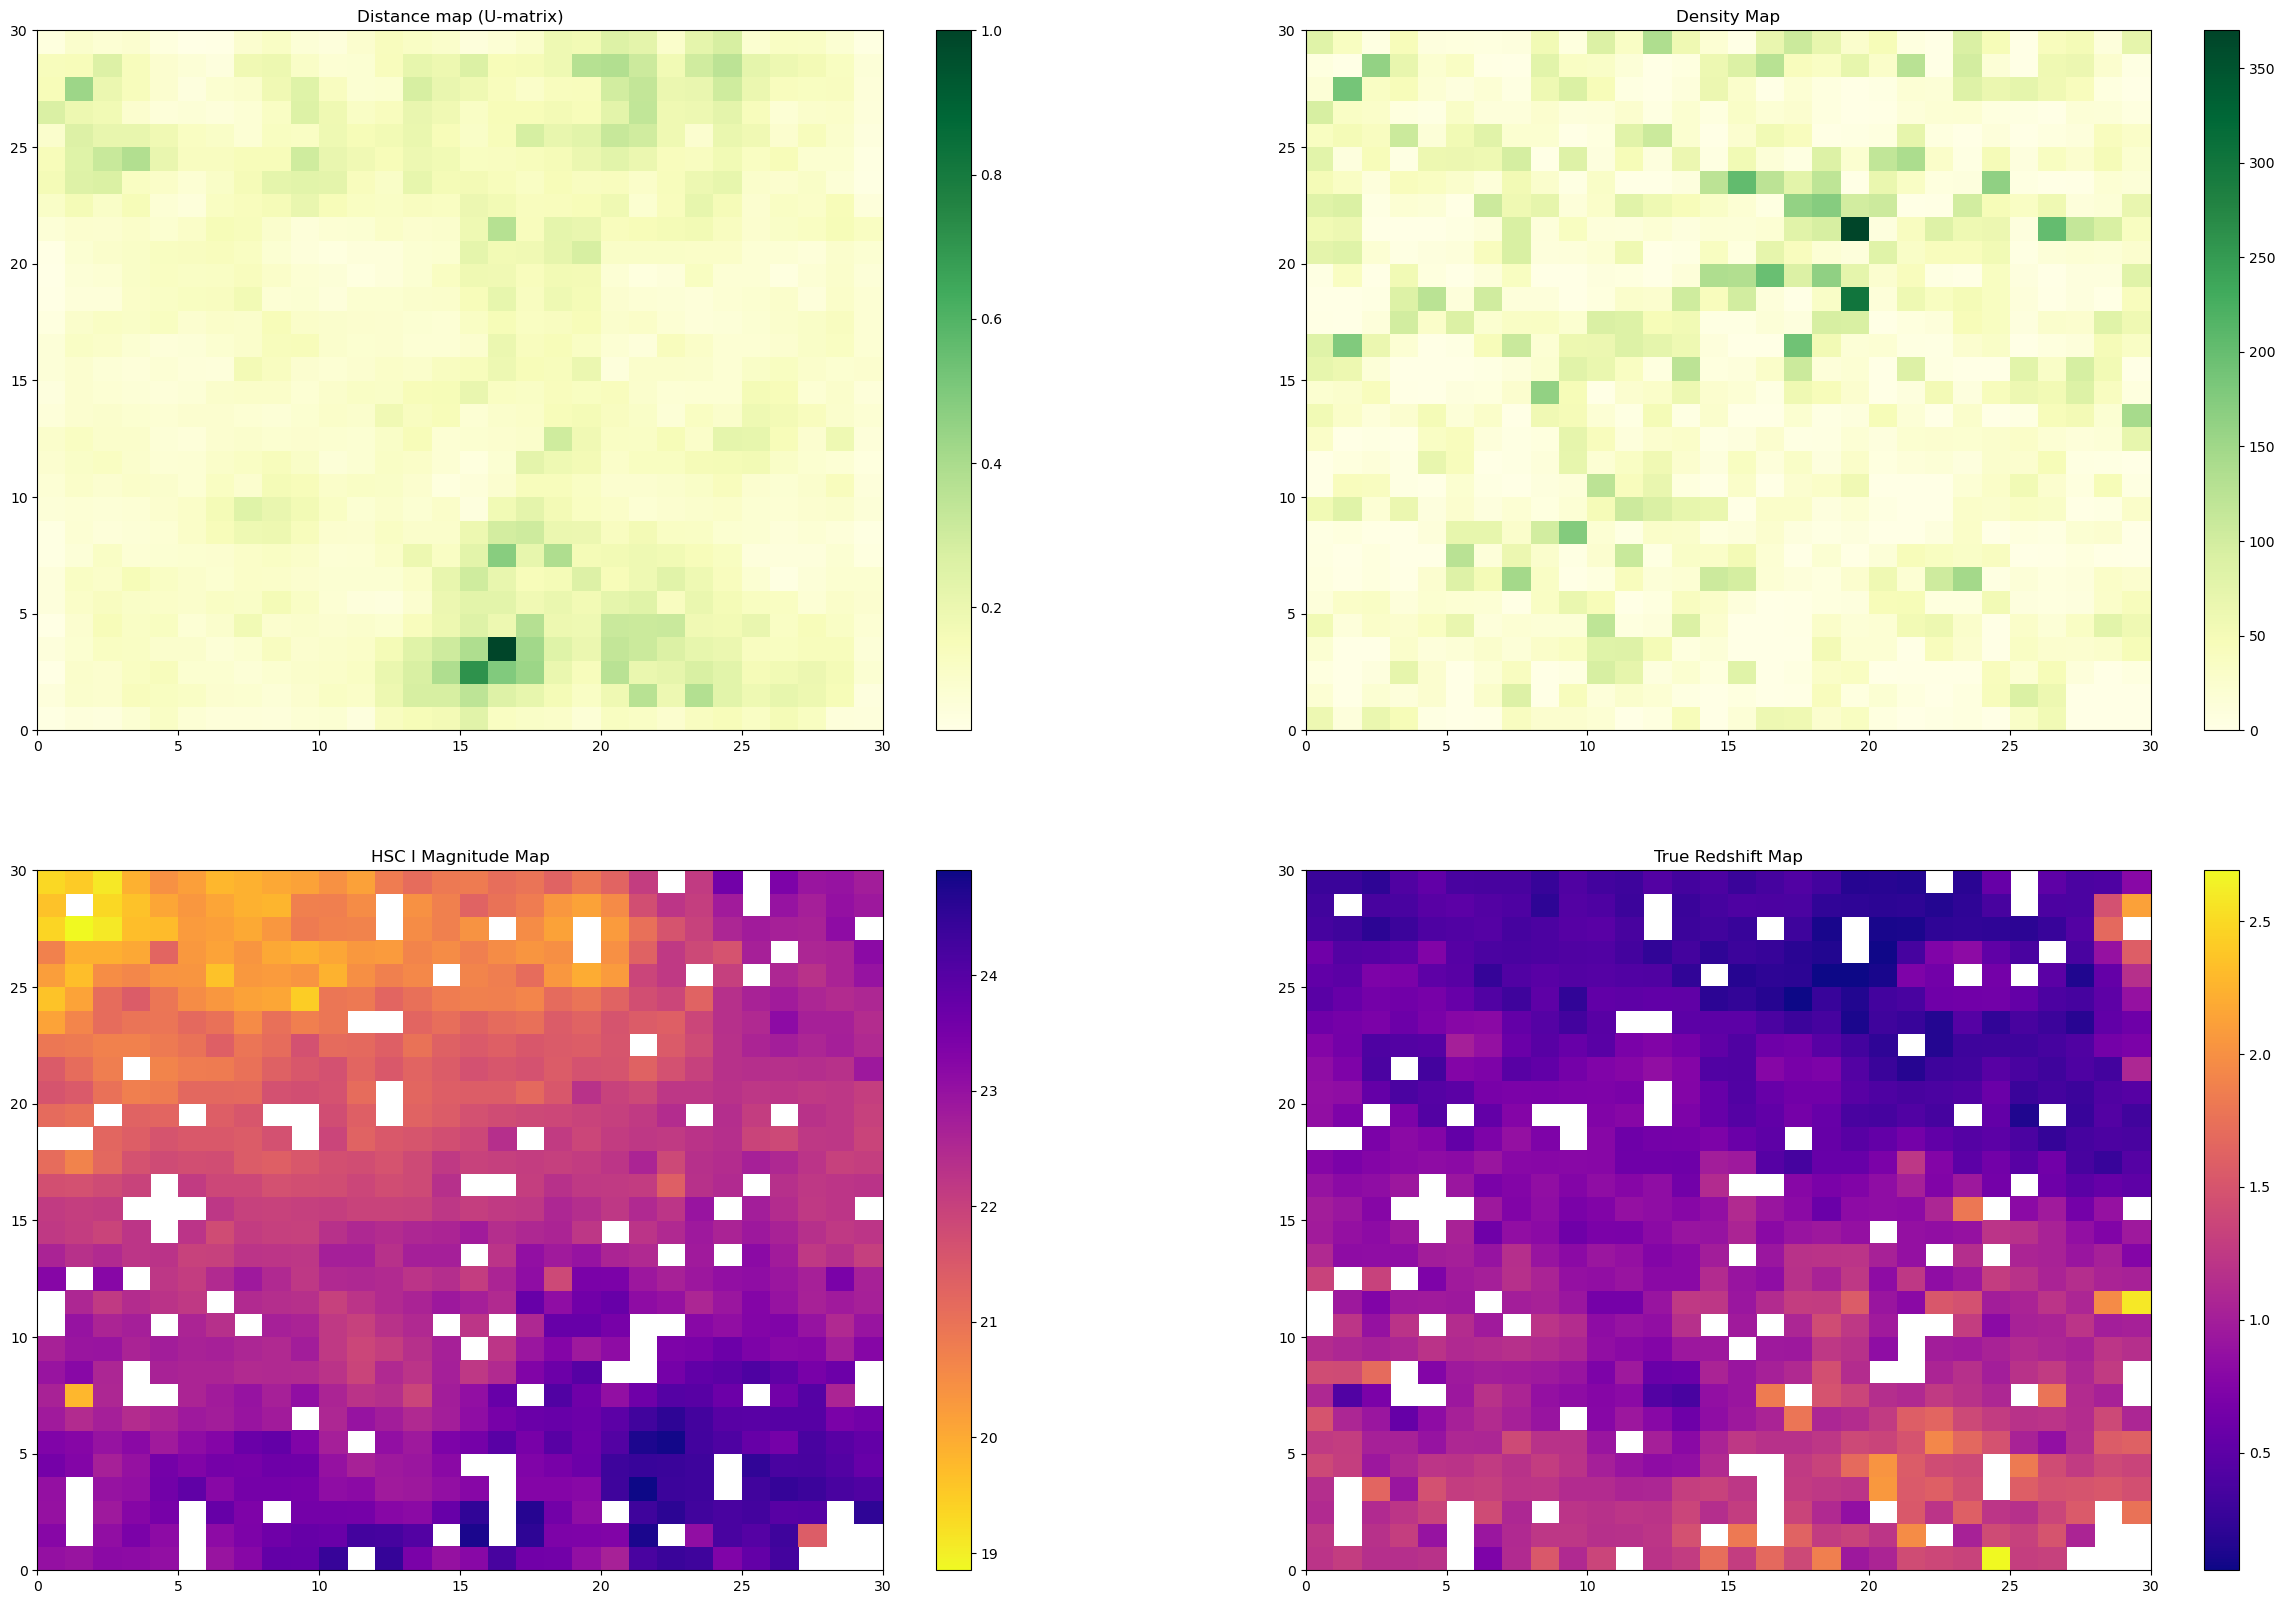

Topological error: 0.7500589563049557
Quantization error: 0.7562452341348398
Topological error: 0.7500589563049557
Quantization error: 0.7562452341348398


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


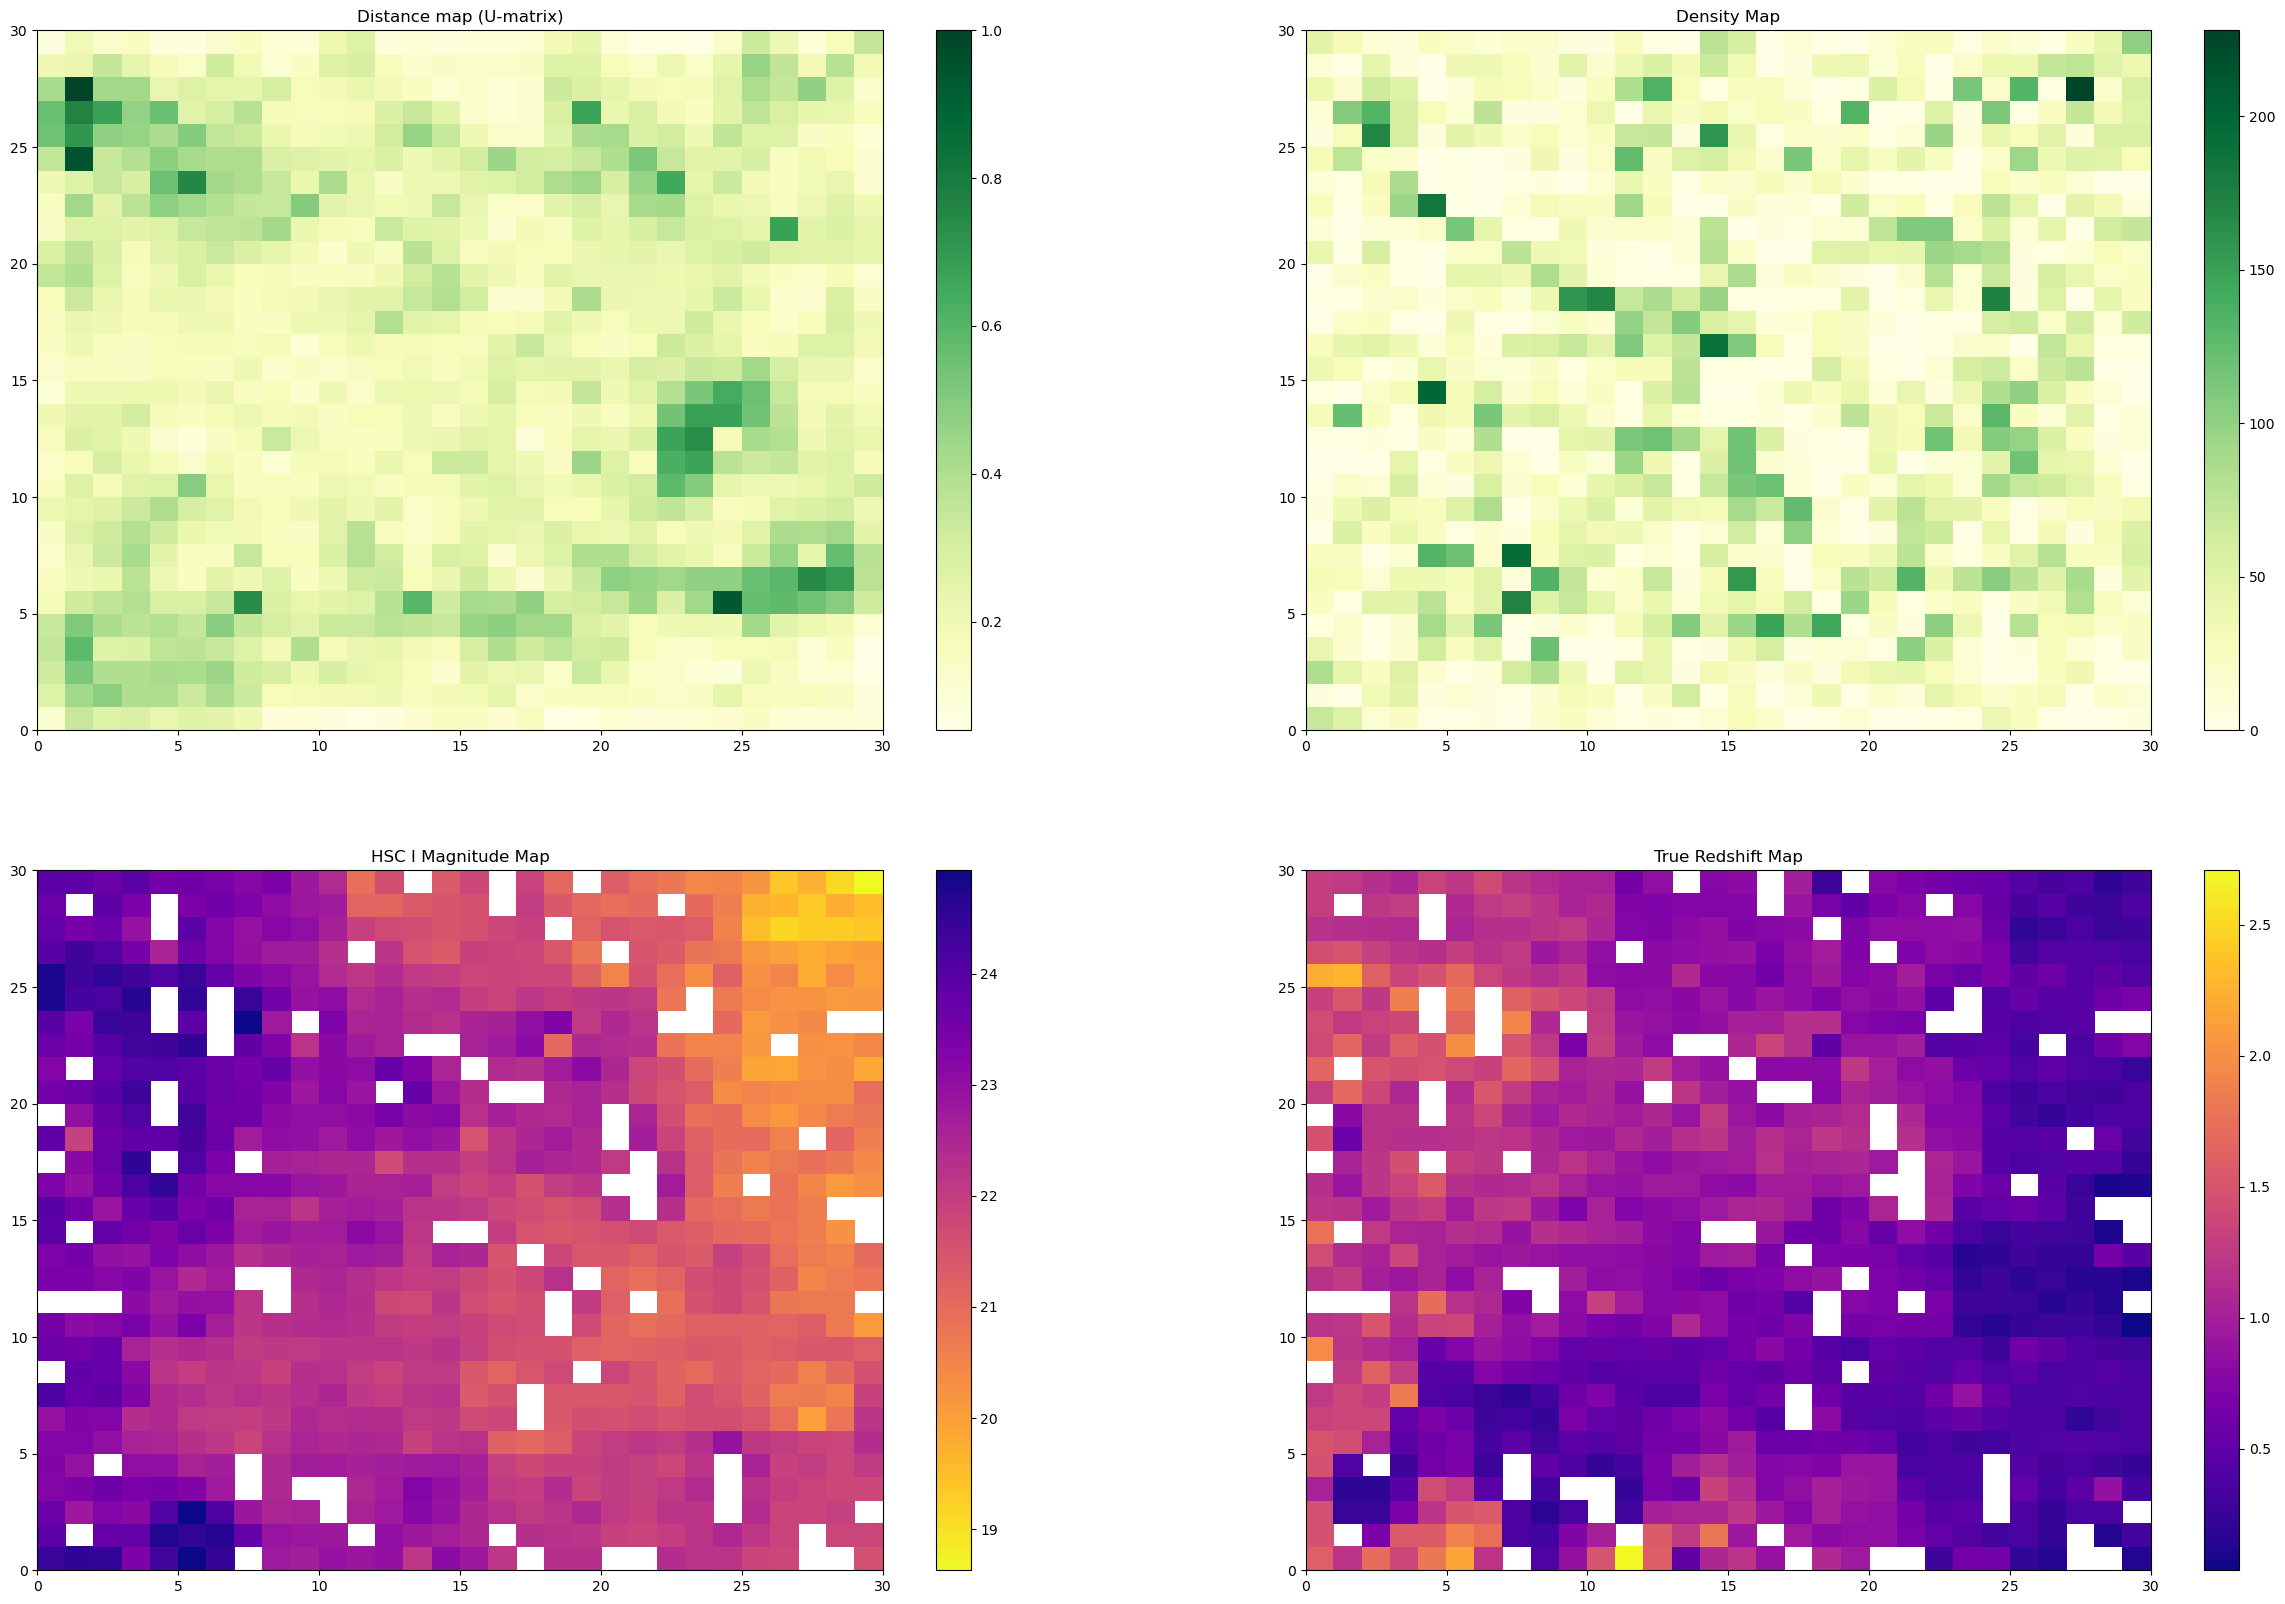

Topological error: 0.7561230333861133
Quantization error: 0.7656477945495671
Topological error: 0.7561230333861133
Quantization error: 0.7656477945495671


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


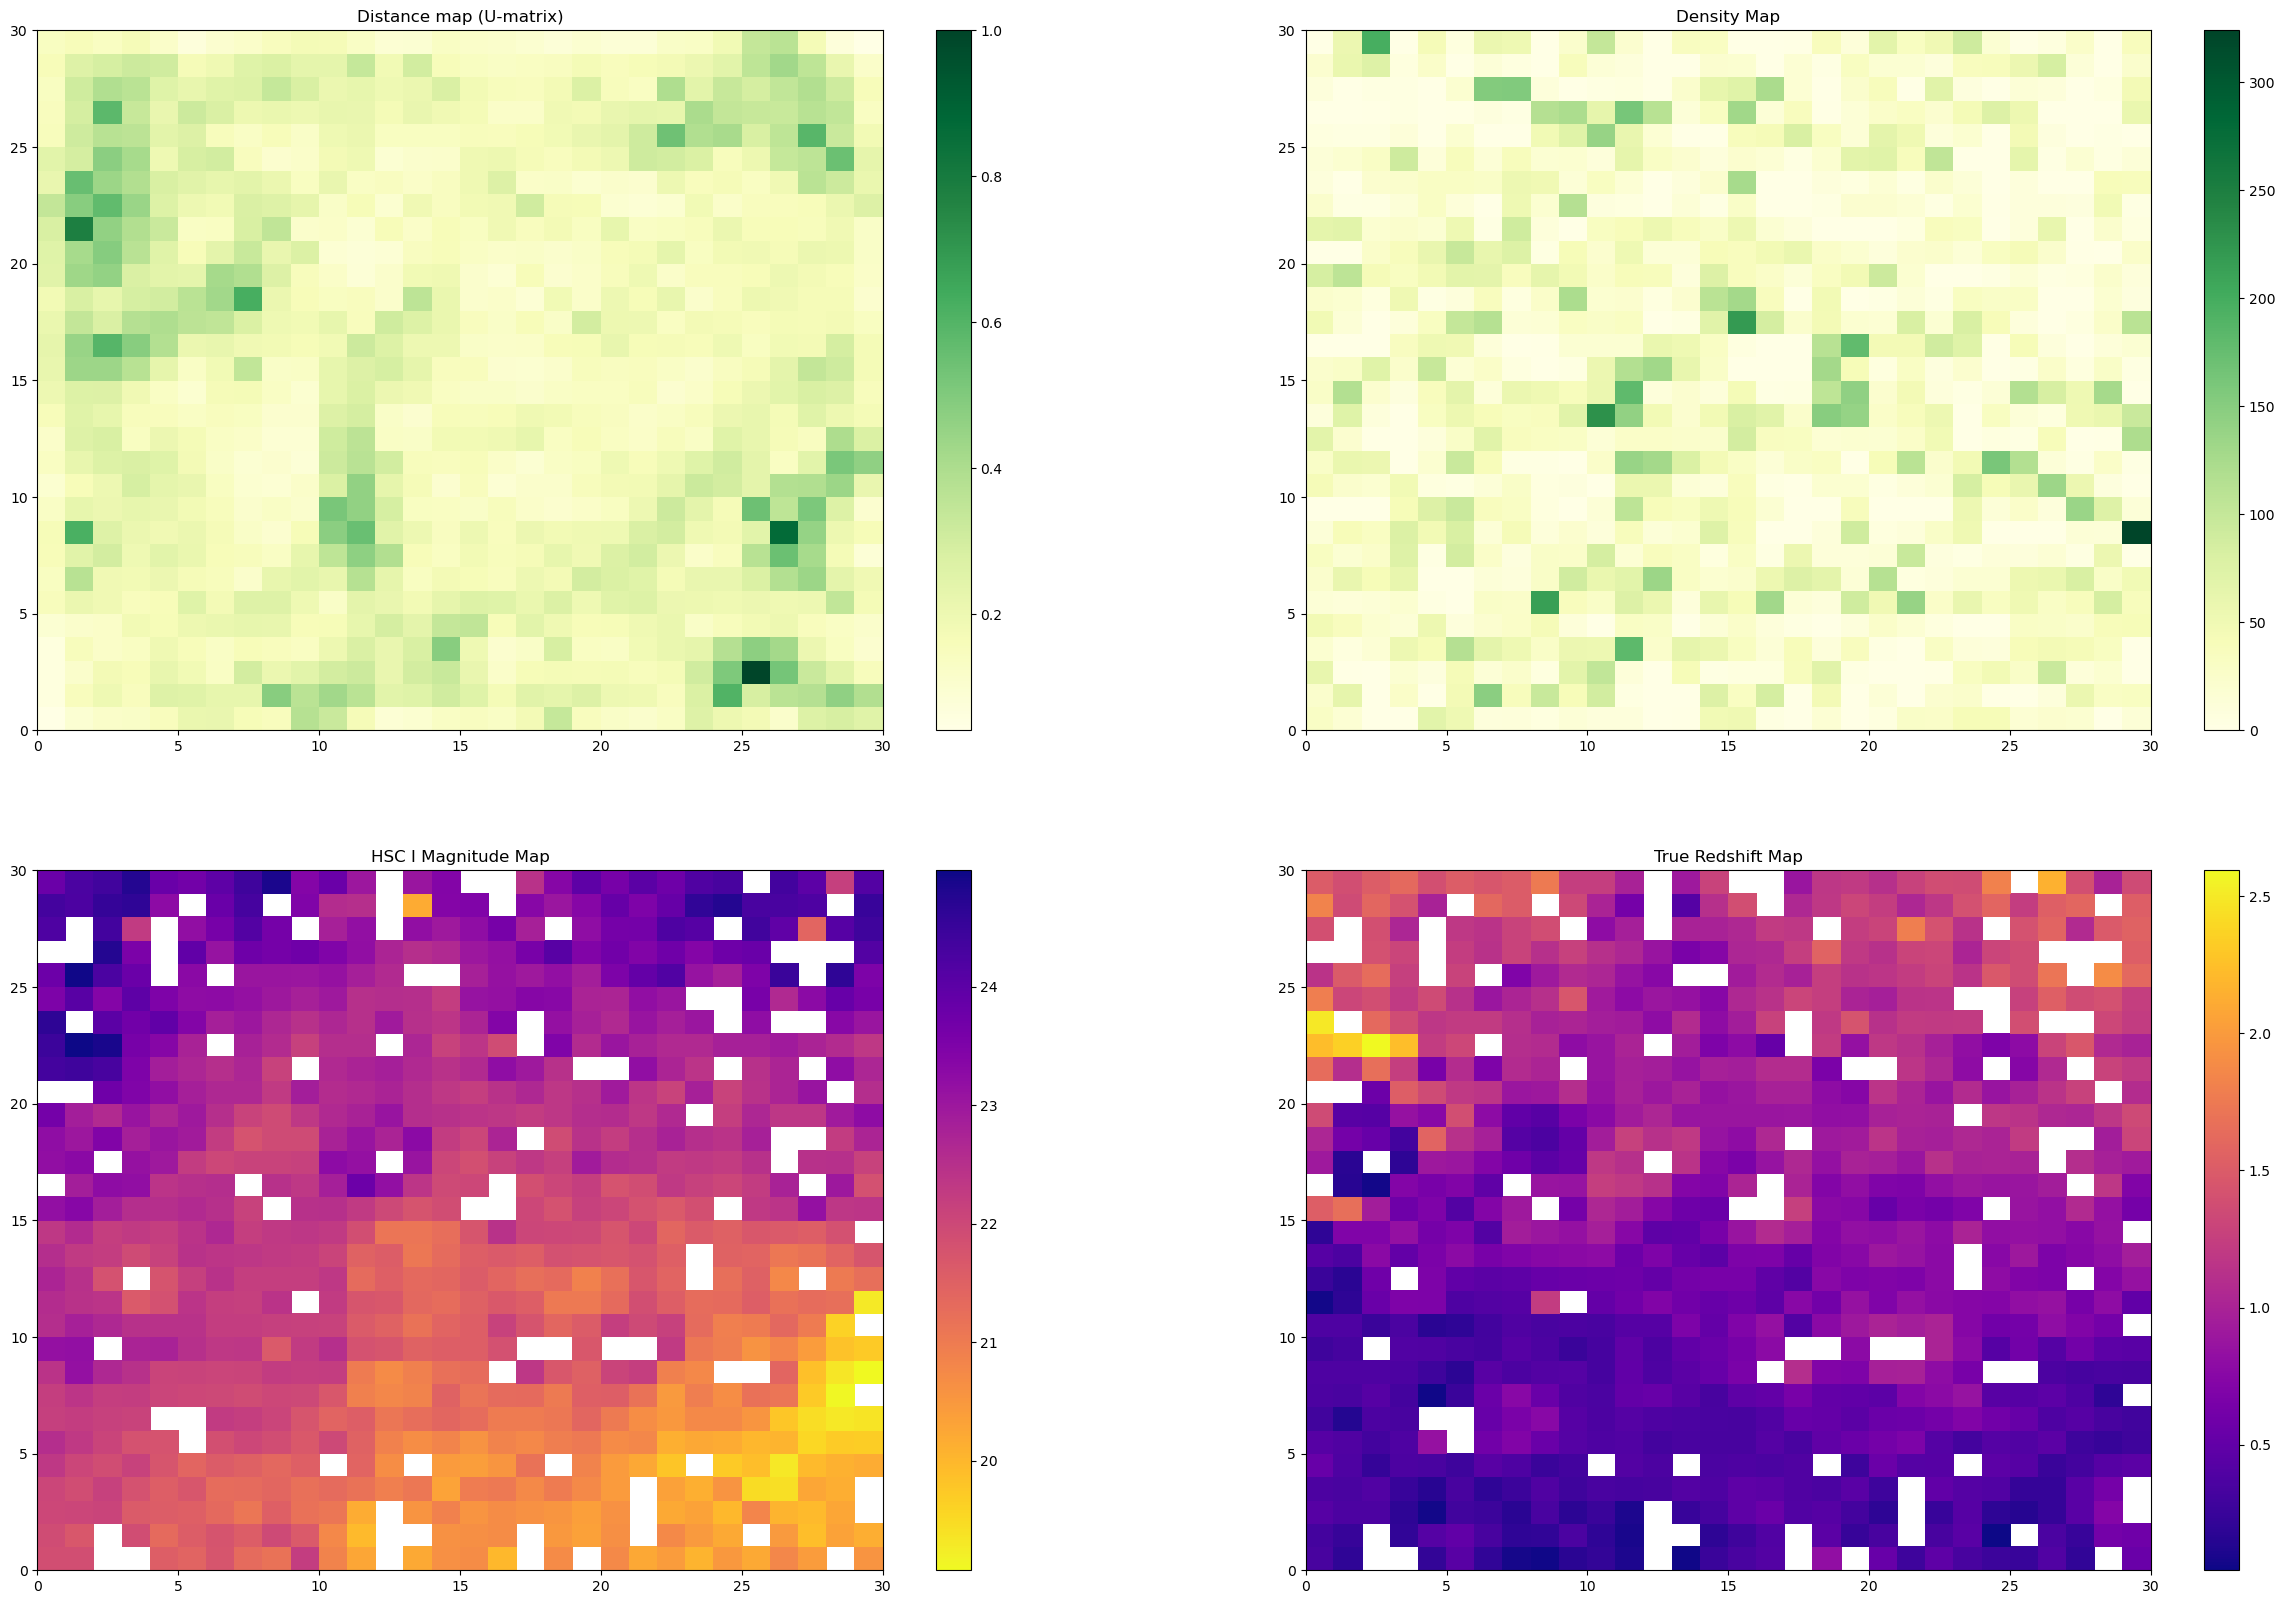

Topological error: 0.7492504126941347
Quantization error: 0.7664148611005054
Topological error: 0.7492504126941347
Quantization error: 0.7664148611005054


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:81: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2508\3168159588.py:86: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


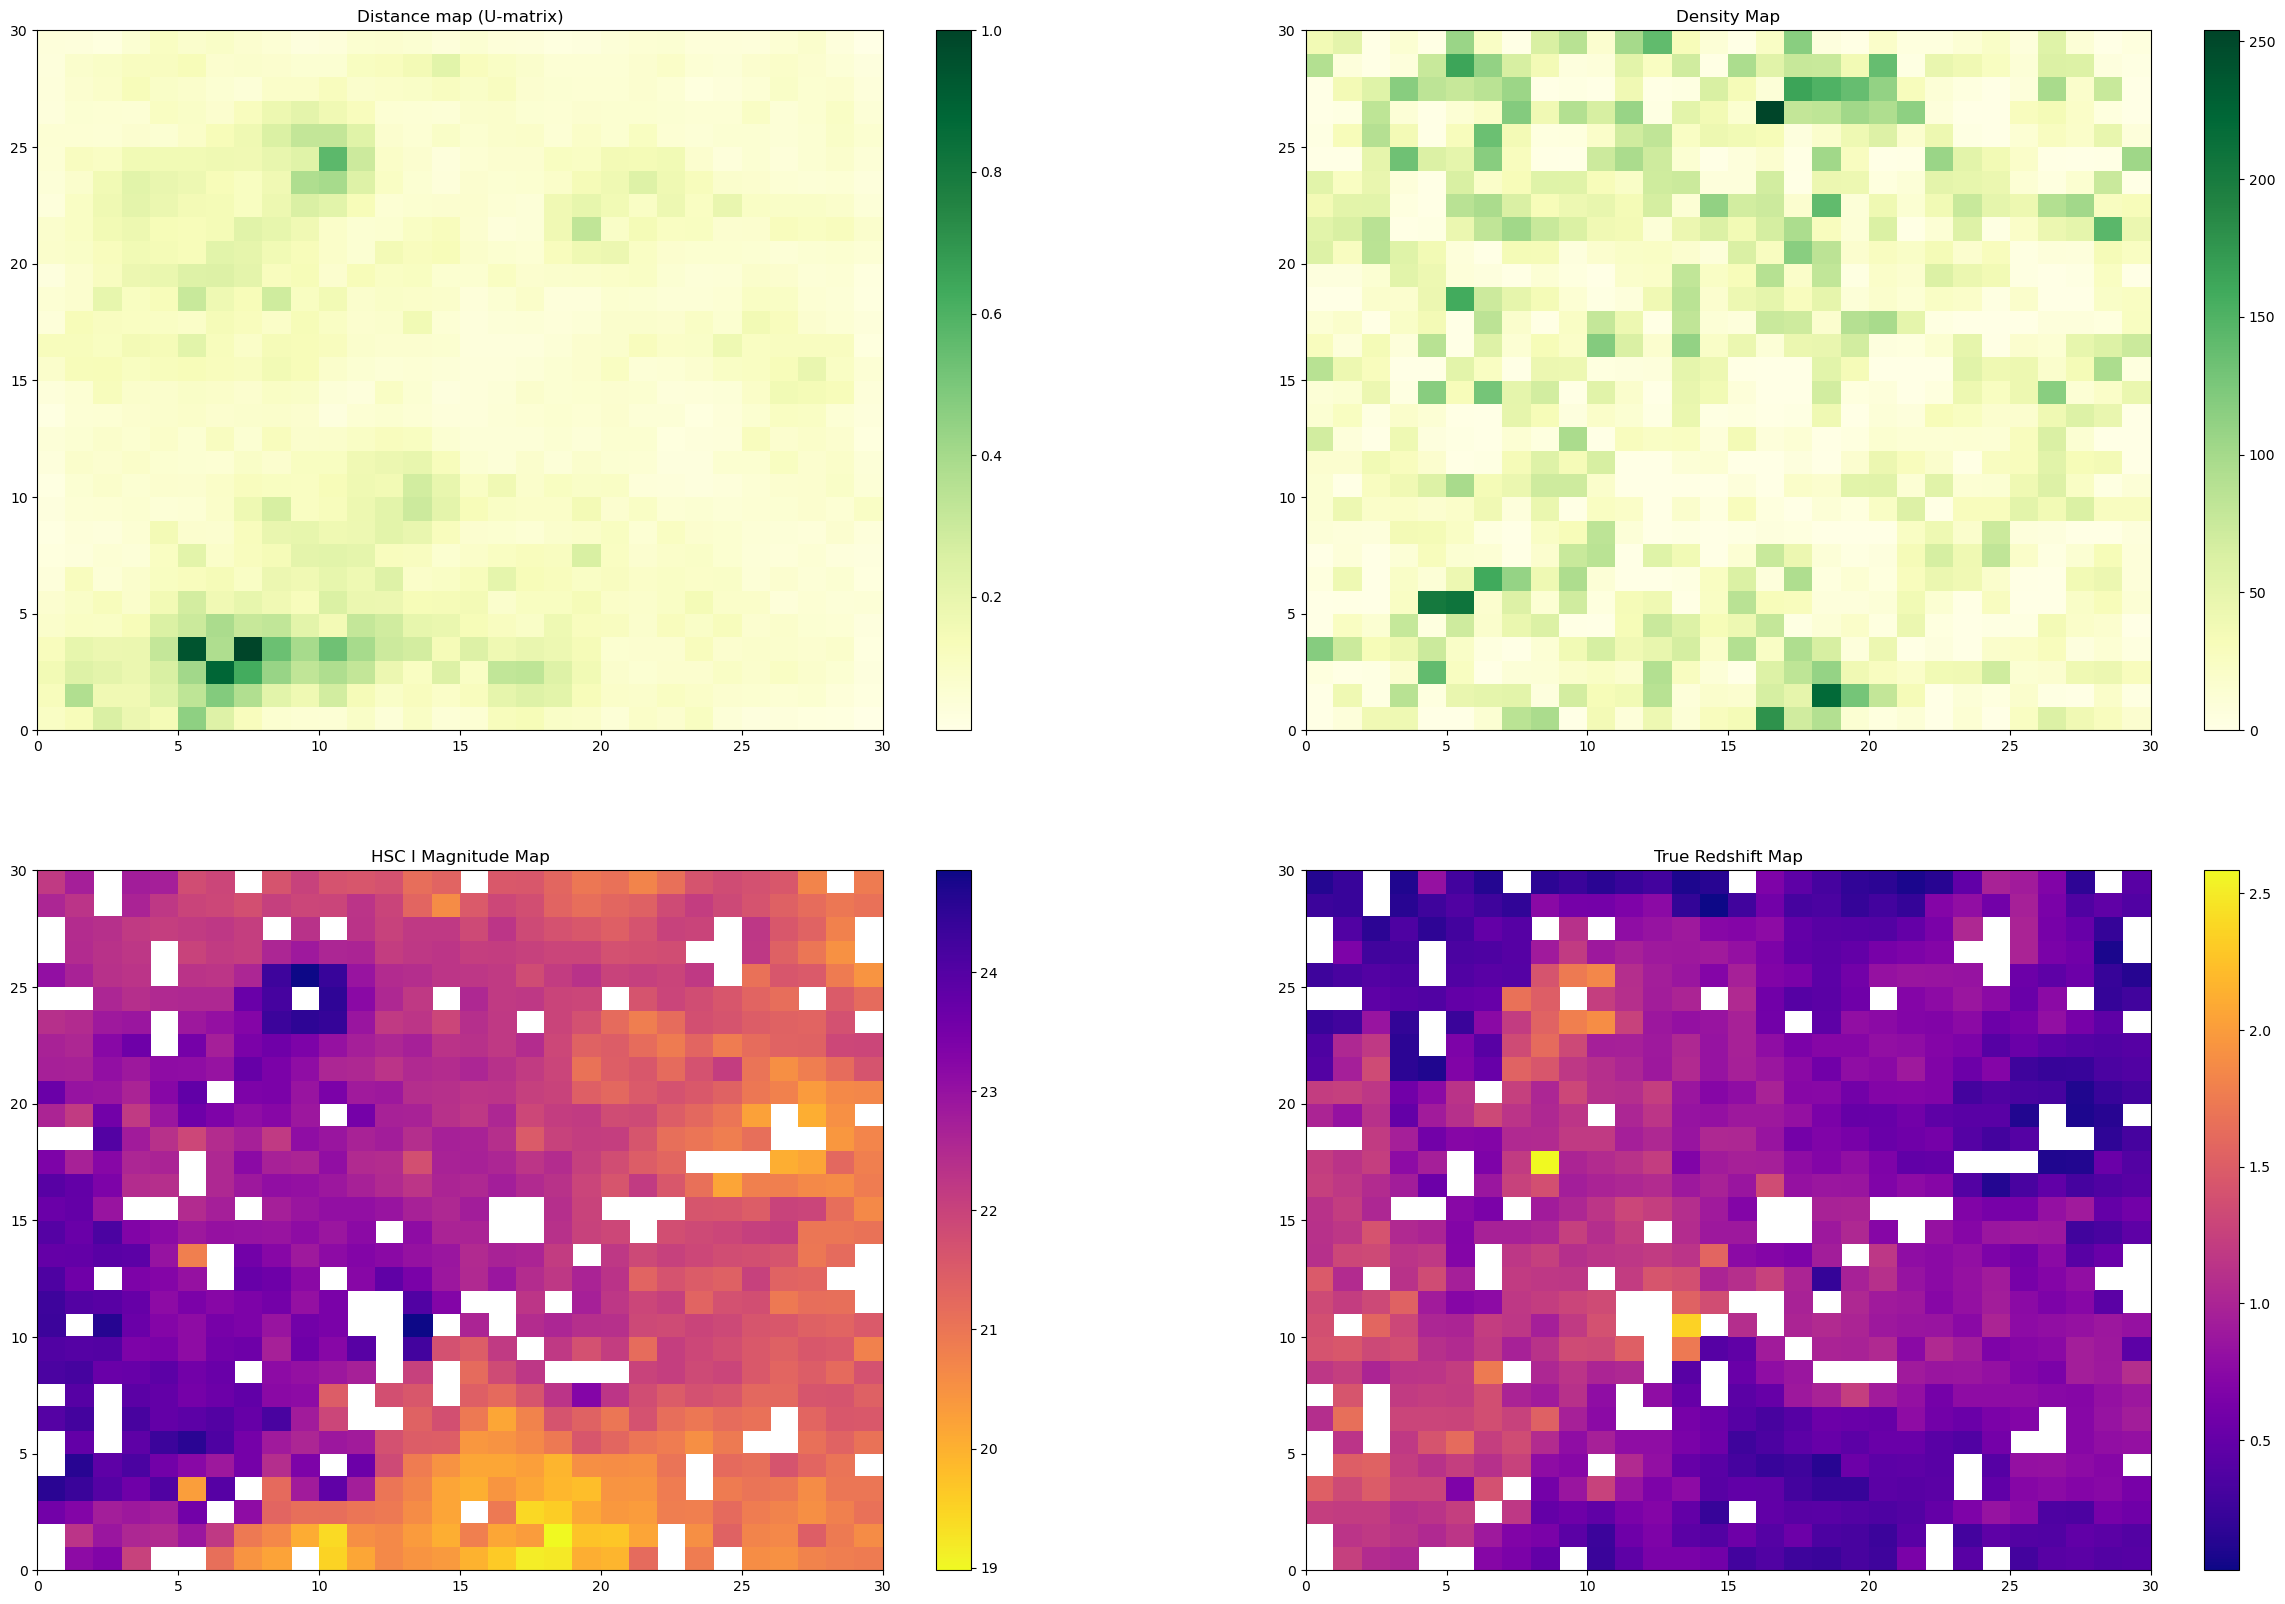

finish


In [19]:
for i in range(1, 31):
    visual_map(file = "D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/noiseless_mag_band_cut.pkl", dim = 30, sigma = 1, rate = i / 10, data = proc_data, err = err, info_data = info, save = "D:/SPHEREx_SOM/record/2nd_grid_search/noiseless_mag_band_cut/diagram/")
print("finish")